<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 500px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src= ".github/public_html/fig/building_model.svg"
/>
</figure>


<h1 style="width: 60%; color: #EC6842; font-size: 55pt;">
    <Strong>
        FEA Study
    </Strong>
</h1>

<h2 id="Background"><B>
    Rationale of this notebook<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     This notebook presents the Finite Element Analysis (FEA) conducted as part of an investigation into the assessment capabilities of unreinforced masonry structures affected by subsidence. The FEA plays a critical role in understanding and validating the model's ability to predict subsidence-induced damage, focusing on key aspects such as damage severity, location, and patterns.<br><br> 
     This case study evaluates the effectiveness of FEA methods, demonstrating their strengths and limitations. The notebook showcases a variety of tools developed for analyzing such models, as well as their implementation across different analysis types. Due to limitations in the output characteristics from DIANA FEA, not all components of the analysis can be fully automated. For this reason, it is recommended to consult the accompanying README.MD for detailed guidance on how to meet the requirements for specific analyses.
</p>

In [2]:
fpath = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS\2DW2O_-_TS_NLA.tb'

df = process_tb(fpath)

analysis_info = {
    'Damage level': { 
        'parameters': {'auto': True, 'mesh': 200}  
    },
    'Crack': {
        'parameters': {'auto': True, 'mesh': 200}  
    }
}

# data = analyse_tabulated(df, analysis_info)
analysis = 'Crack'

if analysis_info[analysis].get('parameters'):
    mesh_size = analysis_info[analysis]['parameters']['mesh']

    temp = []
    for step in df['Step nr.'].unique():
        max_cw = df[df['Step nr.'] == step]['Ecw1'].max()
        df_filtered = df[(df['Step nr.'] == step) & 
                        (df['Ecw1'] >= max_cw/10) & 
                        (pd.notna(df['Element']))][['Element', 'Integration Point', 'X0', 'Y0', 'Ecw1']]                            

        points = df_filtered[['X0', 'Y0']].values
        dist_matrix = distance_matrix(points, points)

        d_threshold = np.sqrt(2 * (mesh_size / 2)**2)  # Max diagonal distance between int points in quadratic mesh
        connectivity = dist_matrix <= d_threshold
        connectivity_sparse = csr_matrix(connectivity)
        n_components, labels = connected_components(csgraph=connectivity_sparse, directed=False, return_labels=True) 

        df_filtered['Component'] = labels
        cracks = {}
        
        for component in range(n_components):
            component_data = df_filtered[df_filtered['Component'] == component]
            component_points = component_data[['X0', 'Y0']].values
            component_elements = component_data['Element'].unique()
            if len(component_points) > 1:
                component_dist_matrix = distance_matrix(component_points, component_points)
                crack_length = np.max(component_dist_matrix)
                components = component_elements.tolist()
                max_mean_crack_width = component_data['Ecw1'].mean()

                if len(components) > 2 and crack_length > 2 * d_threshold:  # Crack Length should go through a minimum of 3 IntPoints
                    cracks[f'Crack {component}'] = {
                        'length': crack_length,
                        'max_mean_width': max_mean_crack_width,
                        'component': components,
                    }
        
        psi = compute_damage_parameter(cracks)
        temp.append({'step': step, 'psi': psi})
    vals = pd.DataFrame(temp)

In [28]:
component_data

,Element,Integration Point,X0,Y0,Ecw1,Component
3622945,9.0,1.0,5214.0,686.599976,3.020,1
3622946,9.0,2.0,5197.0,809.099976,4.919,1
3622948,9.0,4.0,5307.0,809.400024,3.732,1
3623734,206.0,2.0,5053.0,464.799988,2.382,1
3623735,206.0,3.0,5147.0,593.700012,3.005,1
3623736,206.0,4.0,5038.0,589.000000,4.004,1
3623961,263.0,1.0,5118.0,806.700012,2.826,1
3623962,263.0,2.0,5134.0,684.299988,4.400,1
3623964,263.0,4.0,5027.0,678.900024,3.230,1
3625178,567.0,2.0,4861.0,370.500000,2.882,1


In [27]:
component_points

array([[5214. ,  686.6],
       [5197. ,  809.1],
       [5307. ,  809.4],
       [5053. ,  464.8],
       [5147. ,  593.7],
       [5038. ,  589. ],
       [5118. ,  806.7],
       [5134. ,  684.3],
       [5027. ,  678.9],
       [4861. ,  370.5],
       [4976. ,  372.7],
       [4970. ,  462.6],
       [4856. ,  460.1]], dtype=float32)

In [19]:
connectivity

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

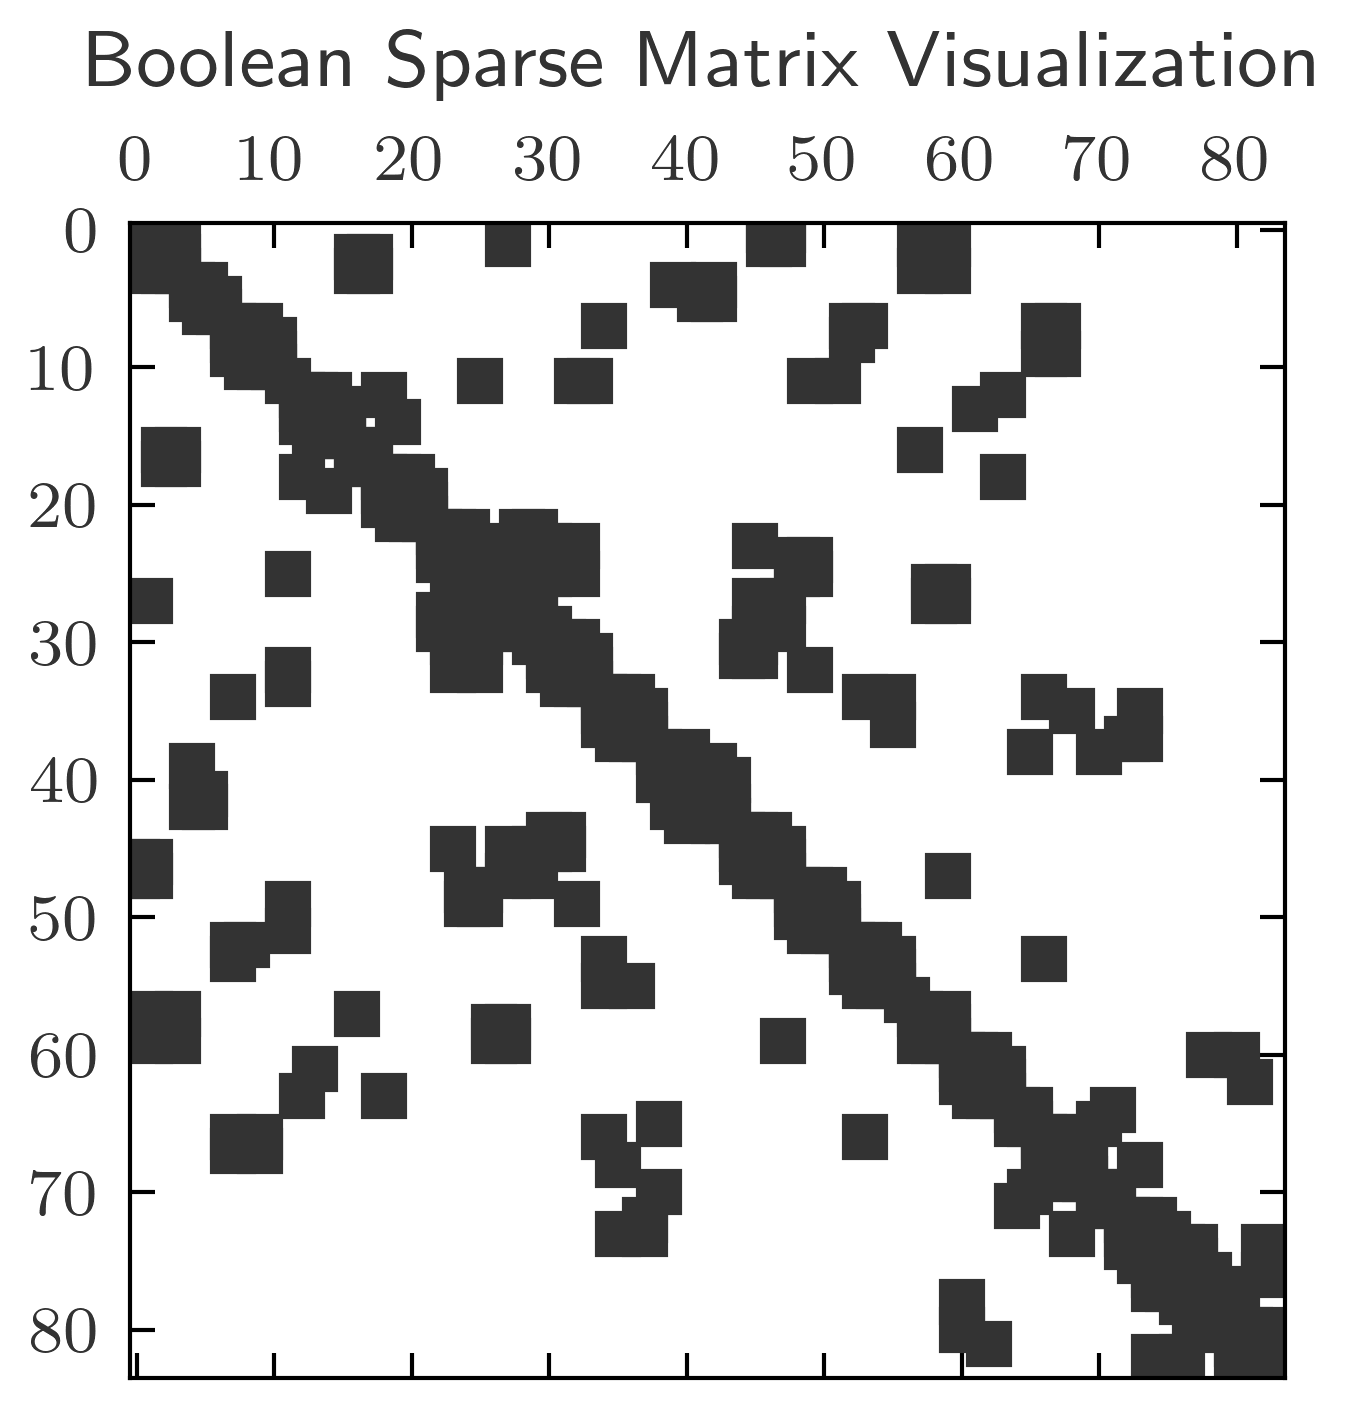

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix




# Plot the matrix
plt.spy(connectivity_sparse, markersize=5)
plt.title('Boolean Sparse Matrix Visualization')
plt.show()

In [55]:
df

,Analysis type,Step nr.,Load factor,X0,Y0,Z0,Element,Integration Point,E1,E2,...,Node,TDtX,TDtY,TDtZ,FBX,FBY,FBZ,Ecw1,Ecw2,Ecw3
0,NONLIN,1,0.0330,240.600006,5093.0,0.0,1.0,1.0,8.171000e-08,-4.547000e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NONLIN,1,0.0330,239.699997,5208.0,0.0,1.0,2.0,2.078000e-07,-2.086000e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NONLIN,1,0.0330,354.600006,5093.0,0.0,1.0,3.0,3.397000e-08,-1.912000e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NONLIN,1,0.0330,353.799988,5208.0,0.0,1.0,4.0,1.820000e-07,-1.611000e-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NONLIN,1,0.0330,563.200012,1973.0,0.0,2.0,1.0,3.369000e-08,-3.383000e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3627745,NONLIN,750,0.9994,3331.000000,3218.0,NaN,NaN,NaN,NaN,NaN,...,1066.0,-16.969999,-17.080,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3627746,NONLIN,750,0.9994,4500.000000,2764.0,NaN,NaN,NaN,NaN,NaN,...,1067.0,-14.660000,-11.090,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3627747,NONLIN,750,0.9994,5536.000000,3012.0,NaN,NaN,NaN,NaN,NaN,...,1068.0,-8.191000,-8.696,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3627748,NONLIN,750,0.9994,6859.000000,3017.0,NaN,NaN,NaN,NaN,NaN,...,1069.0,-7.641000,-5.246,0.0,NaN,NaN,NaN,NaN,NaN,NaN


: 

In [44]:
df_filtered = df[(df['Step nr.'] == 1) &  
                (pd.notna(df['Element']))][['X0', 'Y0']]                            


In [45]:
df_filtered

,X0,Y0
0,240.600006,5093.000000
1,239.699997,5208.000000
2,354.600006,5093.000000
3,353.799988,5208.000000
4,563.200012,1973.000000
...,...,...
3762,4350.000000,2930.000000
3763,4340.000000,2816.000000
3764,3216.000000,587.299988
3765,5635.000000,586.700012


## <strong> X | Imports</strong>

In [1]:
from bricks.fea.analysis.main import *
from bricks.fea.analysis.tabulated import *
from bricks.fea.analysis.crackdetection import *
from bricks.fea.plots import *

import numpy as np
import matplotlib.pyplot as plt

## <strong> 1 | Process runs</strong>

### <strong> 1.1 | Run individual analysis</strong>

The three main individual plots for the relative displacement, crack width progression and damage level progression

In [ ]:
analysis_info = {
    'Damage level': { 
        'parameters': {'auto': True, 'mesh': None}  
    },
    'Crack': {
        'parameters': {'auto': True, 'mesh': None}  
    }
}

model_dirs = [
r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS',
r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS - 0.1m',
r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS - 0.05m',
r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS',
r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS - 0.1m',
r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS - 0.05m',
]

mesh_sizes = [200,100,50,200,100,50]

for model_dir, mesh_size in zip(model_dirs, mesh_sizes):
    analysis_info['Damage level']['parameters']['mesh'] = mesh_size
    analysis_info['Crack']['parameters']['mesh'] = mesh_size
    data_l = analyse_models(model_dir, analysis_info = analysis_info)
    print(f"Analysis completed for model: {model_dir} with mesh size: {mesh_size}")

ValueError: x and y must have same first dimension, but have shapes (751,) and (750,)

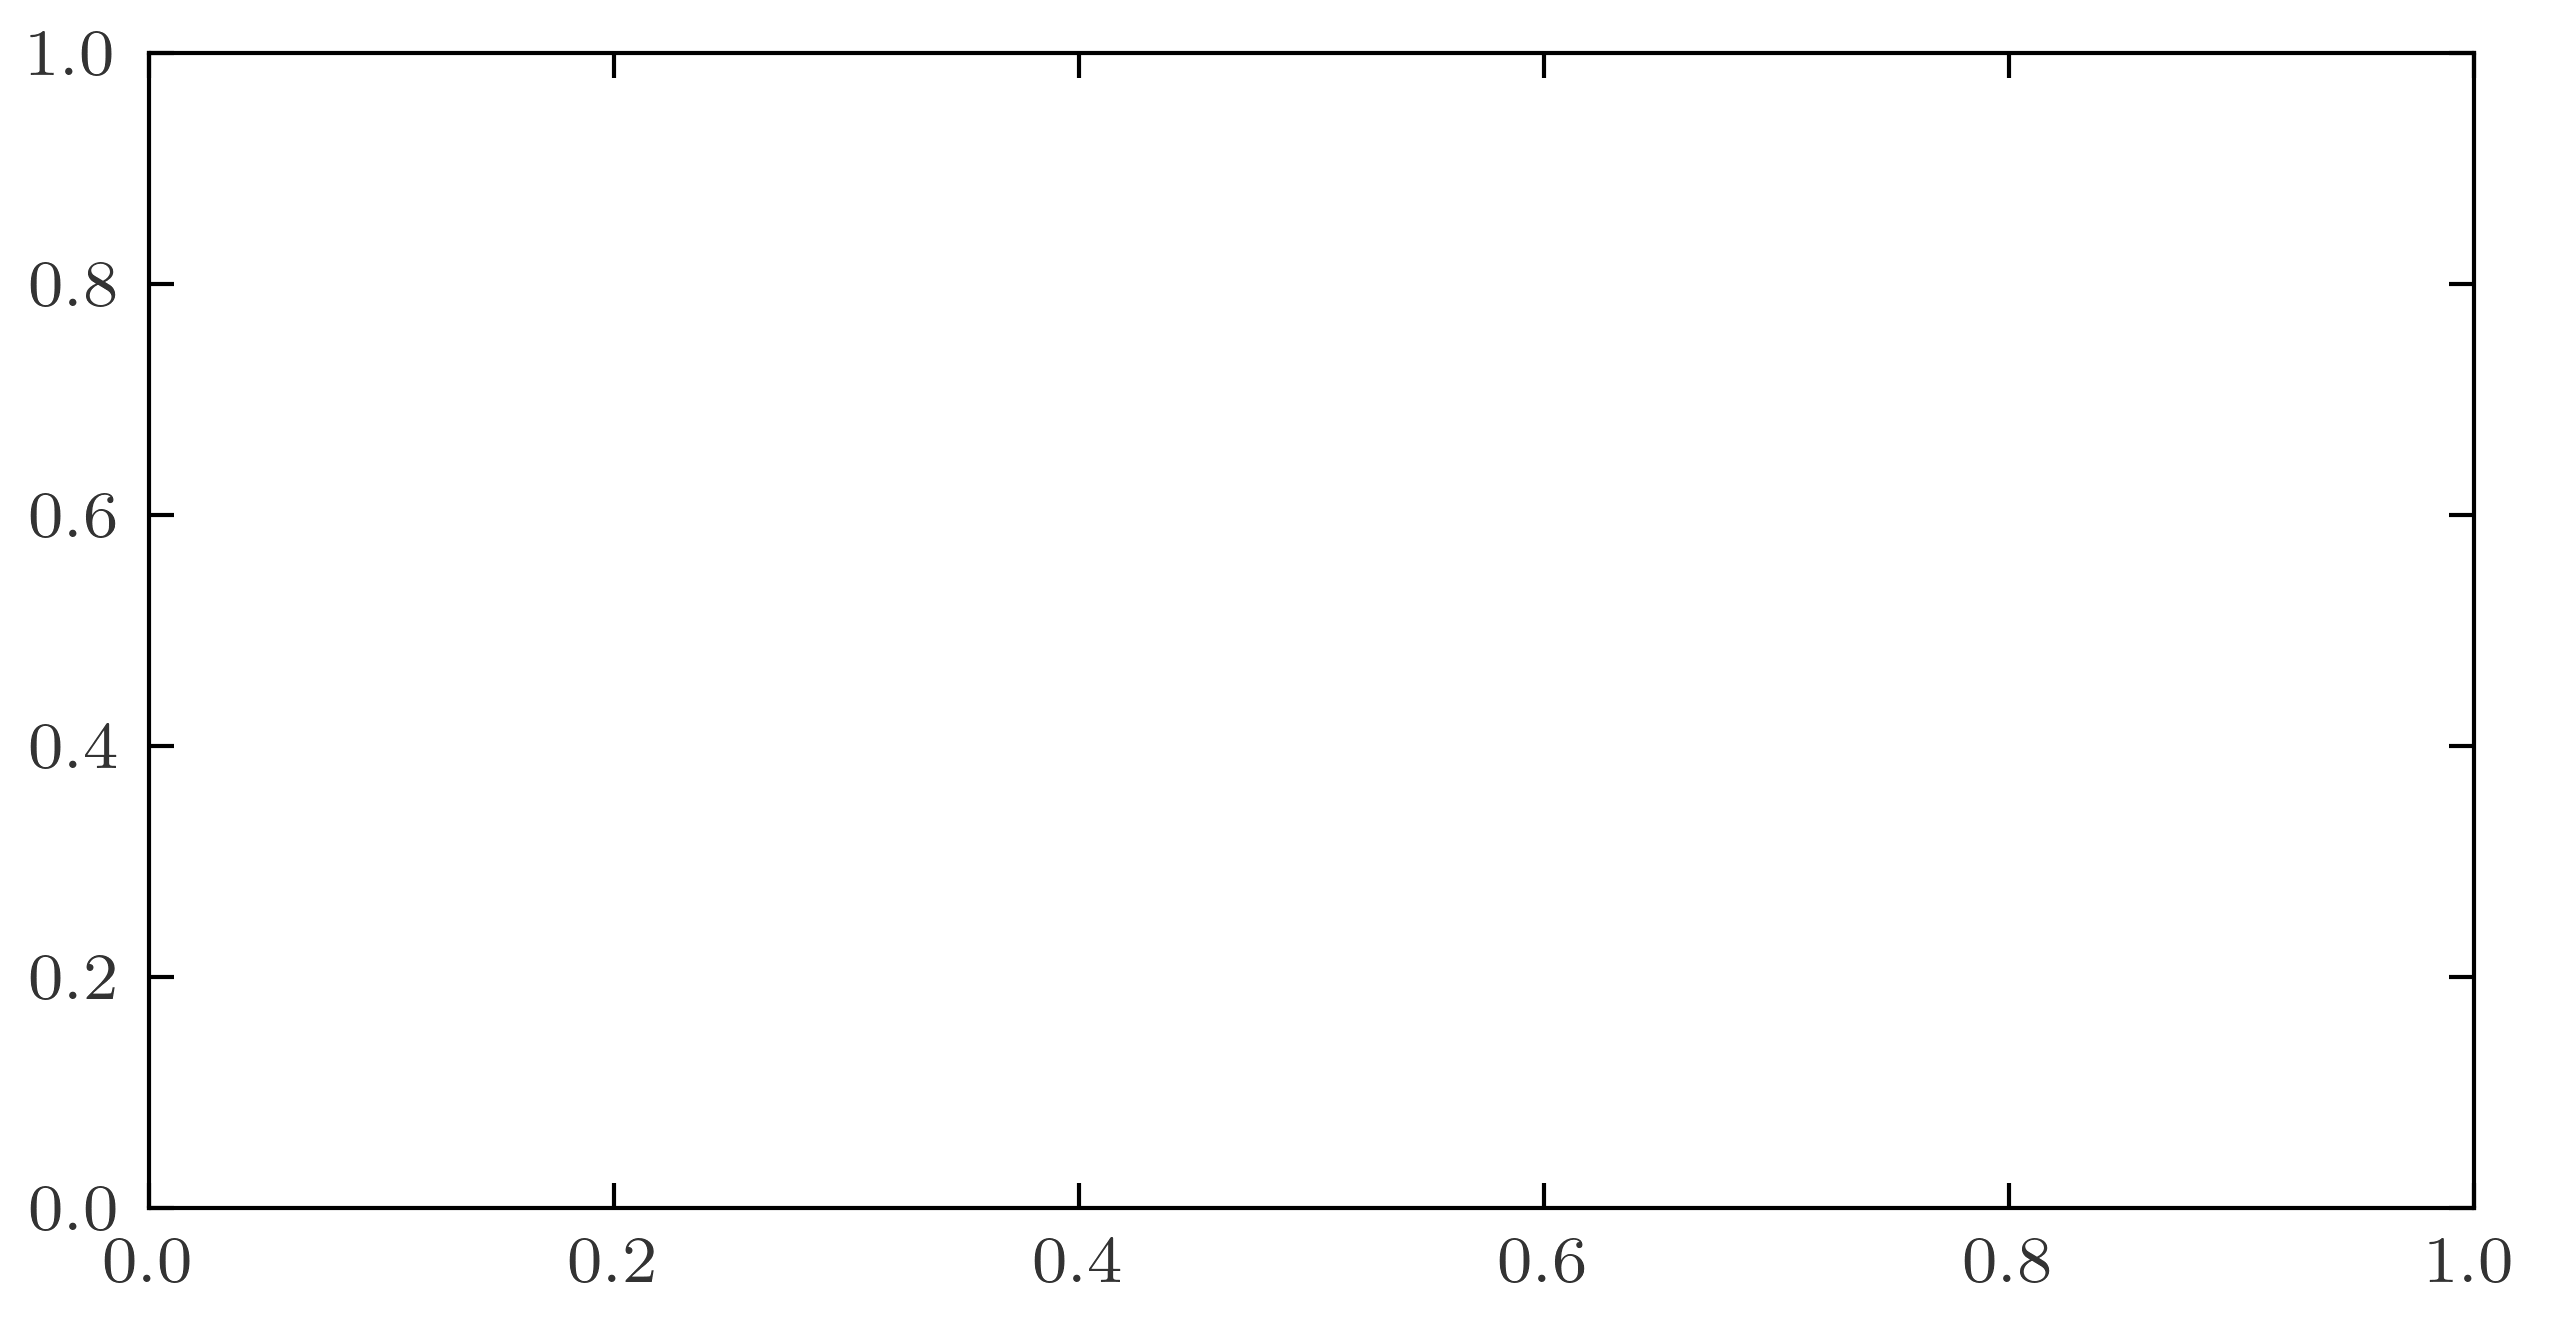

In [3]:
# ------------------------------- TSRCM ------------------------------ #
combined_info_TSRCM = {
    'Crack width': {
        'EOI': [[177,178,179,435],
                [35, 166, 203, 387, 523, 684, 723, 867],
                [9, 206, 263, 612]],
    },
}

combined_settings_TSRCM = {
    'Crack width': {
        'traces': ['Crack 1 TSCM ','Crack 5 TSCM','Crack 9 TSCM'],
        'labels': ['Load factor $\lambda$', 'Crack Width $c_w$ [mm]'],
        'titles': 'Major crack Width development',
        'scientific': True
    },
}


data_TSCM = {}
data_TSCM['name'] = 'TSCM-O',
data_TSCM['analysis_info'] = combined_info_TSRCM
data_TSCM['plot_settings'] = combined_settings_TSRCM
data_TSCM['dir'] = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS\2DW2O_-_TS_NLA.tb'

# ------------------------------- EMM S ------------------------------ #
combined_info_EMMS = {
    'Crack width': {
        'EOI': [[34, 35, 154, 248],
                [65, 66, 145, 212, 219, 226, 227, 354],
                [679, 706, 737, 822],],
    },
}

combined_settings_EMMS = {
    'Crack width': {
        'traces': ['Crack 1 EMM','Crack 5 EMM','Crack 9 EMM'],
        'labels': ['Load factor $\lambda$', 'Crack Width $c_w$ [mm]'],
        'titles': 'Major crack Width development',
        'scientific': True
    },
}

data_EMMO = {}
data_EMMO['name'] = 'EMM - O '
data_EMMO['analysis_info'] = combined_info_EMMS
data_EMMO['plot_settings'] = combined_settings_EMMS
data_EMMO['dir'] = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2O - EMS\2DW2O_-_EMS_NLA.tb'

plot_data_list = [data_TSCM, data_EMMO]
cfigs = compare_models(plot_data_list)

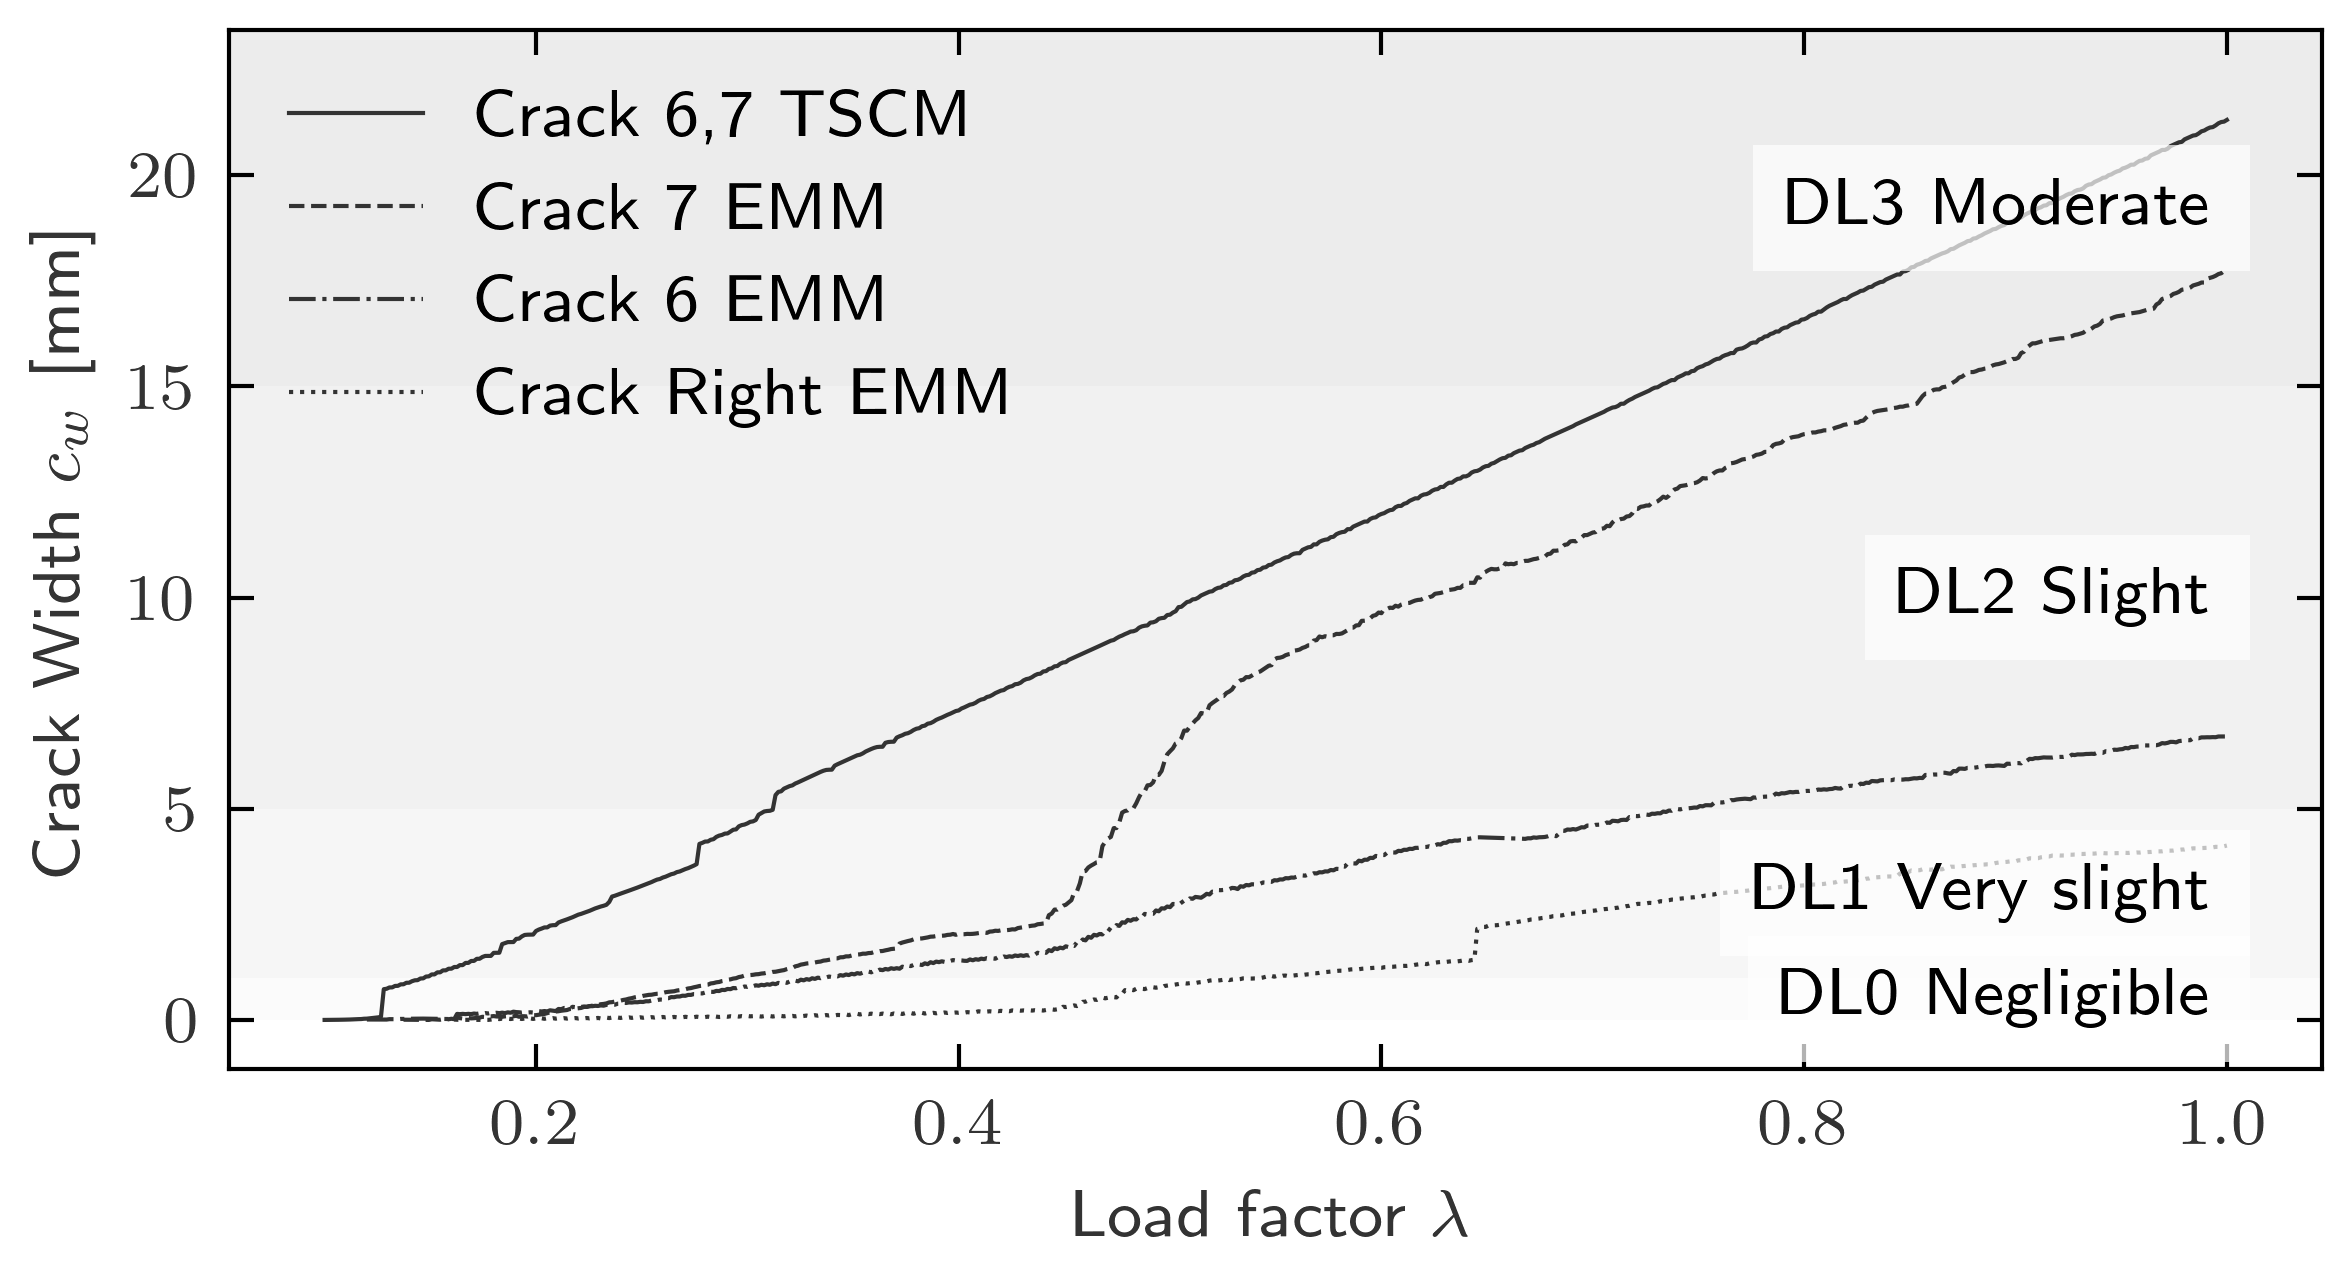

In [3]:
# ------------------------------- TSRCM ------------------------------ #
combined_info_TSRCM = {
    'Crack width': {
        'EOI': [[34, 35, 71, 88, 146, 184, 248, 259, 276, 318, 335, 363, 364, 367, 420, 607, 609, 731, 736, 750, 794, 815, 850, 877, 887]]
    },
}

combined_settings_TSRCM = {
    'Crack width': {
        'traces': ['Crack 6,7 TSCM'],
        'labels': ['Load factor $\lambda$', 'Crack Width $c_w$ [mm]'],
        'titles': 'Major crack Width development',
        'scientific': True
    },
}

data_TSCM = {}
data_TSCM['name'] = 'TSCM-I'
data_TSCM['analysis_info'] = combined_info_TSRCM
data_TSCM['plot_settings'] = combined_settings_TSRCM
data_TSCM['dir'] = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS\2DW2I_-_TS_NLA.tb'

# ------------------------------- EMM S ------------------------------ #
combined_info_EMMS = {
    'Crack width': {
        'EOI': [[34, 35, 154, 248],
                [65, 66, 145, 212, 219, 226, 227, 354],
                [613, 646, 692, 699, 701, 703, 758, 876, 910, 920]]
    },
}

combined_settings_EMMS = {
    'Crack width': {
        'traces': ['Crack 7 EMM','Crack 6 EMM','Crack Right EMM'],
        'labels': ['Load factor $\lambda$', 'Crack Width $c_w$ [mm]'],
        'titles': 'Major crack Width development',
        'scientific': True
    },
}

data_EMMO = {}
data_EMMO['name'] = 'EMM-I'
data_EMMO['analysis_info'] = combined_info_EMMS
data_EMMO['plot_settings'] = combined_settings_EMMS
data_EMMO['dir'] = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2I - EMS\2DWI_-_EMS_NLA.tb'
plot_data_list = [data_TSCM, data_EMMO]
cfigs = compare_models(plot_data_list)

### <strong> 1.2 | Run compared analysis</strong>

The three main individual plots for the relative displacement, crack width progression and damage level progression between models

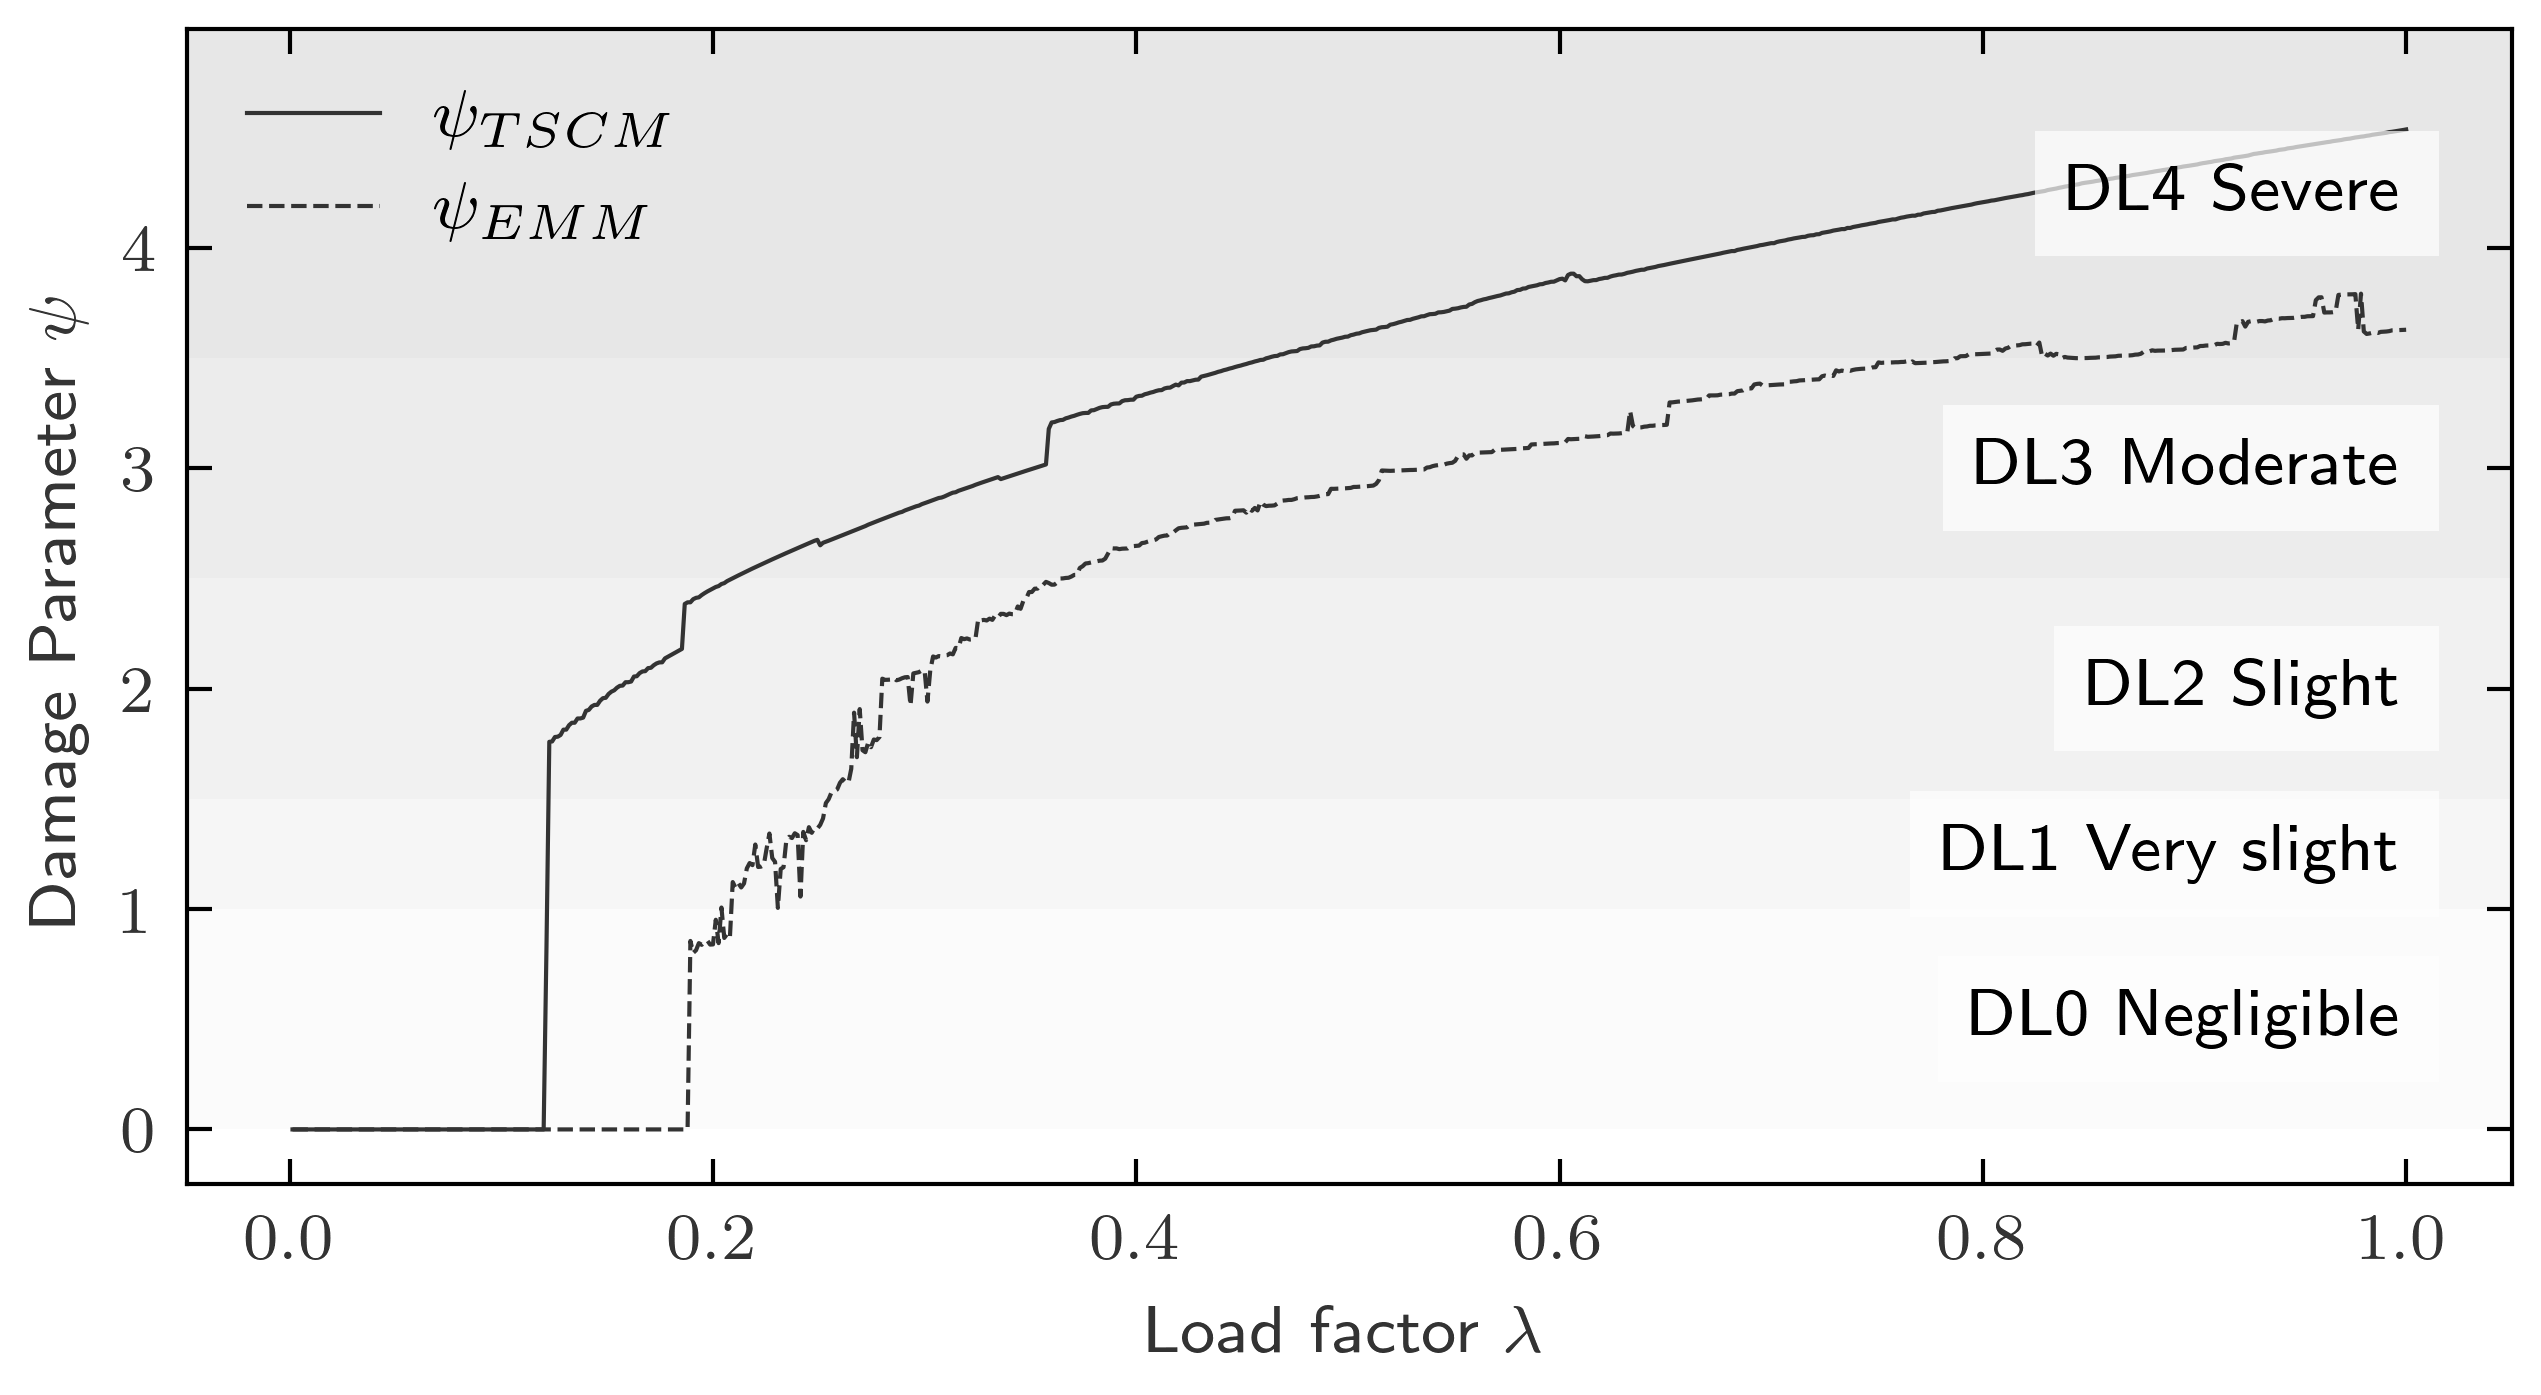

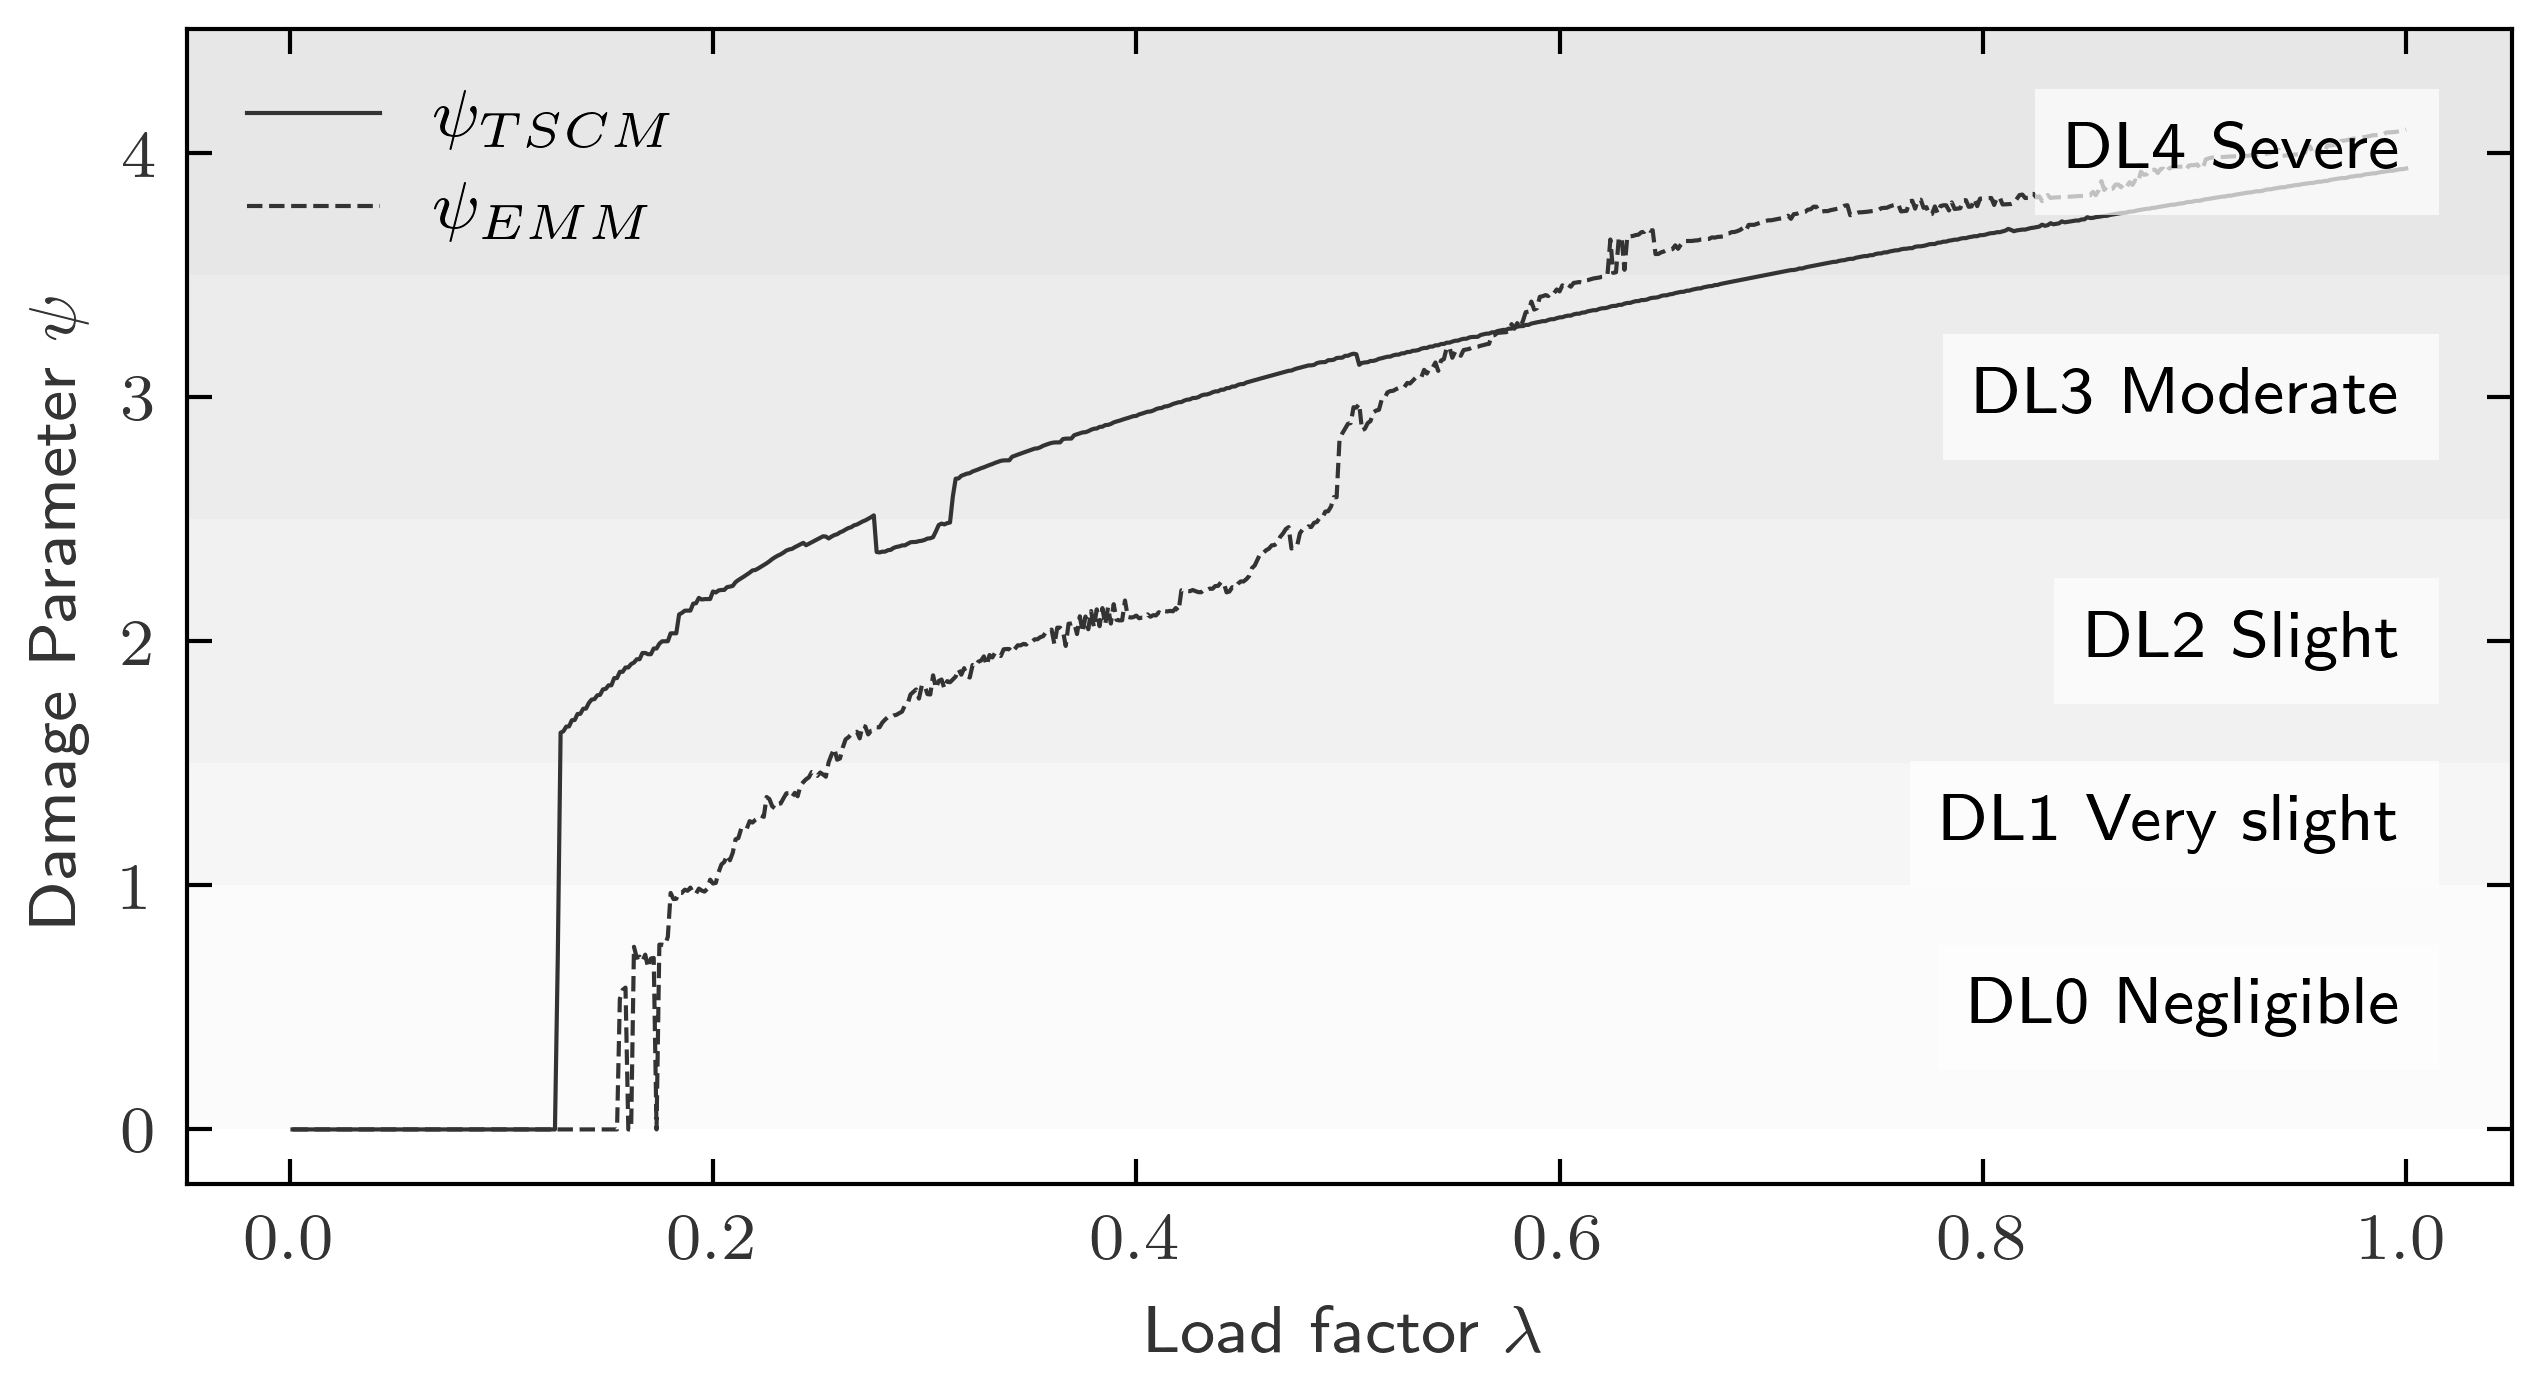

In [2]:
# ------------------------------- TSRCM ------------------------------ #
combined_info_TSRCM = {
    'Damage level': { 
        'parameters': {'auto': True,
                       'mesh': 200         
    }
}}

combined_settings_TSRCM = {
    'Damage level': {
        'traces': ['${\psi_{TSCM}}$'],
        'labels': ['Load factor $\lambda$', 'Damage Parameter $\psi$'],
        'titles': 'Damage level progression',
        'scientific': True,
        'figsize': (5, 2.5),
    }
}


data_TSCM = {}
data_TSCM['name'] = 'TSCM-O',
data_TSCM['analysis_info'] = combined_info_TSRCM
data_TSCM['plot_settings'] = combined_settings_TSRCM
data_TSCM['dir'] = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS\2DW2O_-_TS_NLA.tb'

combined_info_EMMS = {
    'Damage level': { 
            'parameters': {'auto': True,
                        'mesh': 200},
                         }}

combined_settings_EMMS = {
    'Damage level': {
        'traces': ['${\psi_{EMM}}$'],
        'labels': ['Load factor $\lambda$', 'Damage Parameter $\psi$'],
        'titles': 'Damage level progression',
        'scientific': True,
        'figsize': (5, 2.5)
    }
}

data_EMMO = {}
data_EMMO['name'] = 'EMM - O'
data_EMMO['analysis_info'] = combined_info_EMMS
data_EMMO['plot_settings'] = combined_settings_EMMS
data_EMMO['dir'] = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2O - EMS\2DW2O_-_EMS_NLA.tb'

plot_data_list = [data_TSCM, data_EMMO]
cfigso = compare_models(plot_data_list)

data_TSCMI = data_TSCM
data_TSCMI['dir'] = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS\2DW2I_-_TS_NLA.tb'

data_EMMI = data_EMMO
data_EMMI['dir'] = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2I - EMS\2DWI_-_EMS_NLA.tb'

plot_data_list = [data_TSCMI, data_EMMI]
cfigsi = compare_models(plot_data_list)

In [ ]:
from bricks.fea.analysis.processing.out import * 
from bricks.fea.analysis.plots.plots import *

file_path = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS\2DW2O_-_TS_NLA.out'

lines = read_file(file_path)  # Replace `dir` with `file_path`
iter, ncsteps = parse_lines(lines)
figures, titles, ax = plotconvergence(iter, ncsteps)
figures[2]
label = 'TSCM'

file_path = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2O - EMS\2DW2O_-_EMS_NLA.out'
lines = read_file(file_path)  # Replace `dir` with `file_path`
iter, ncsteps = parse_lines(lines)
figures, titles, ax = plotconvergence(iter, ncsteps)

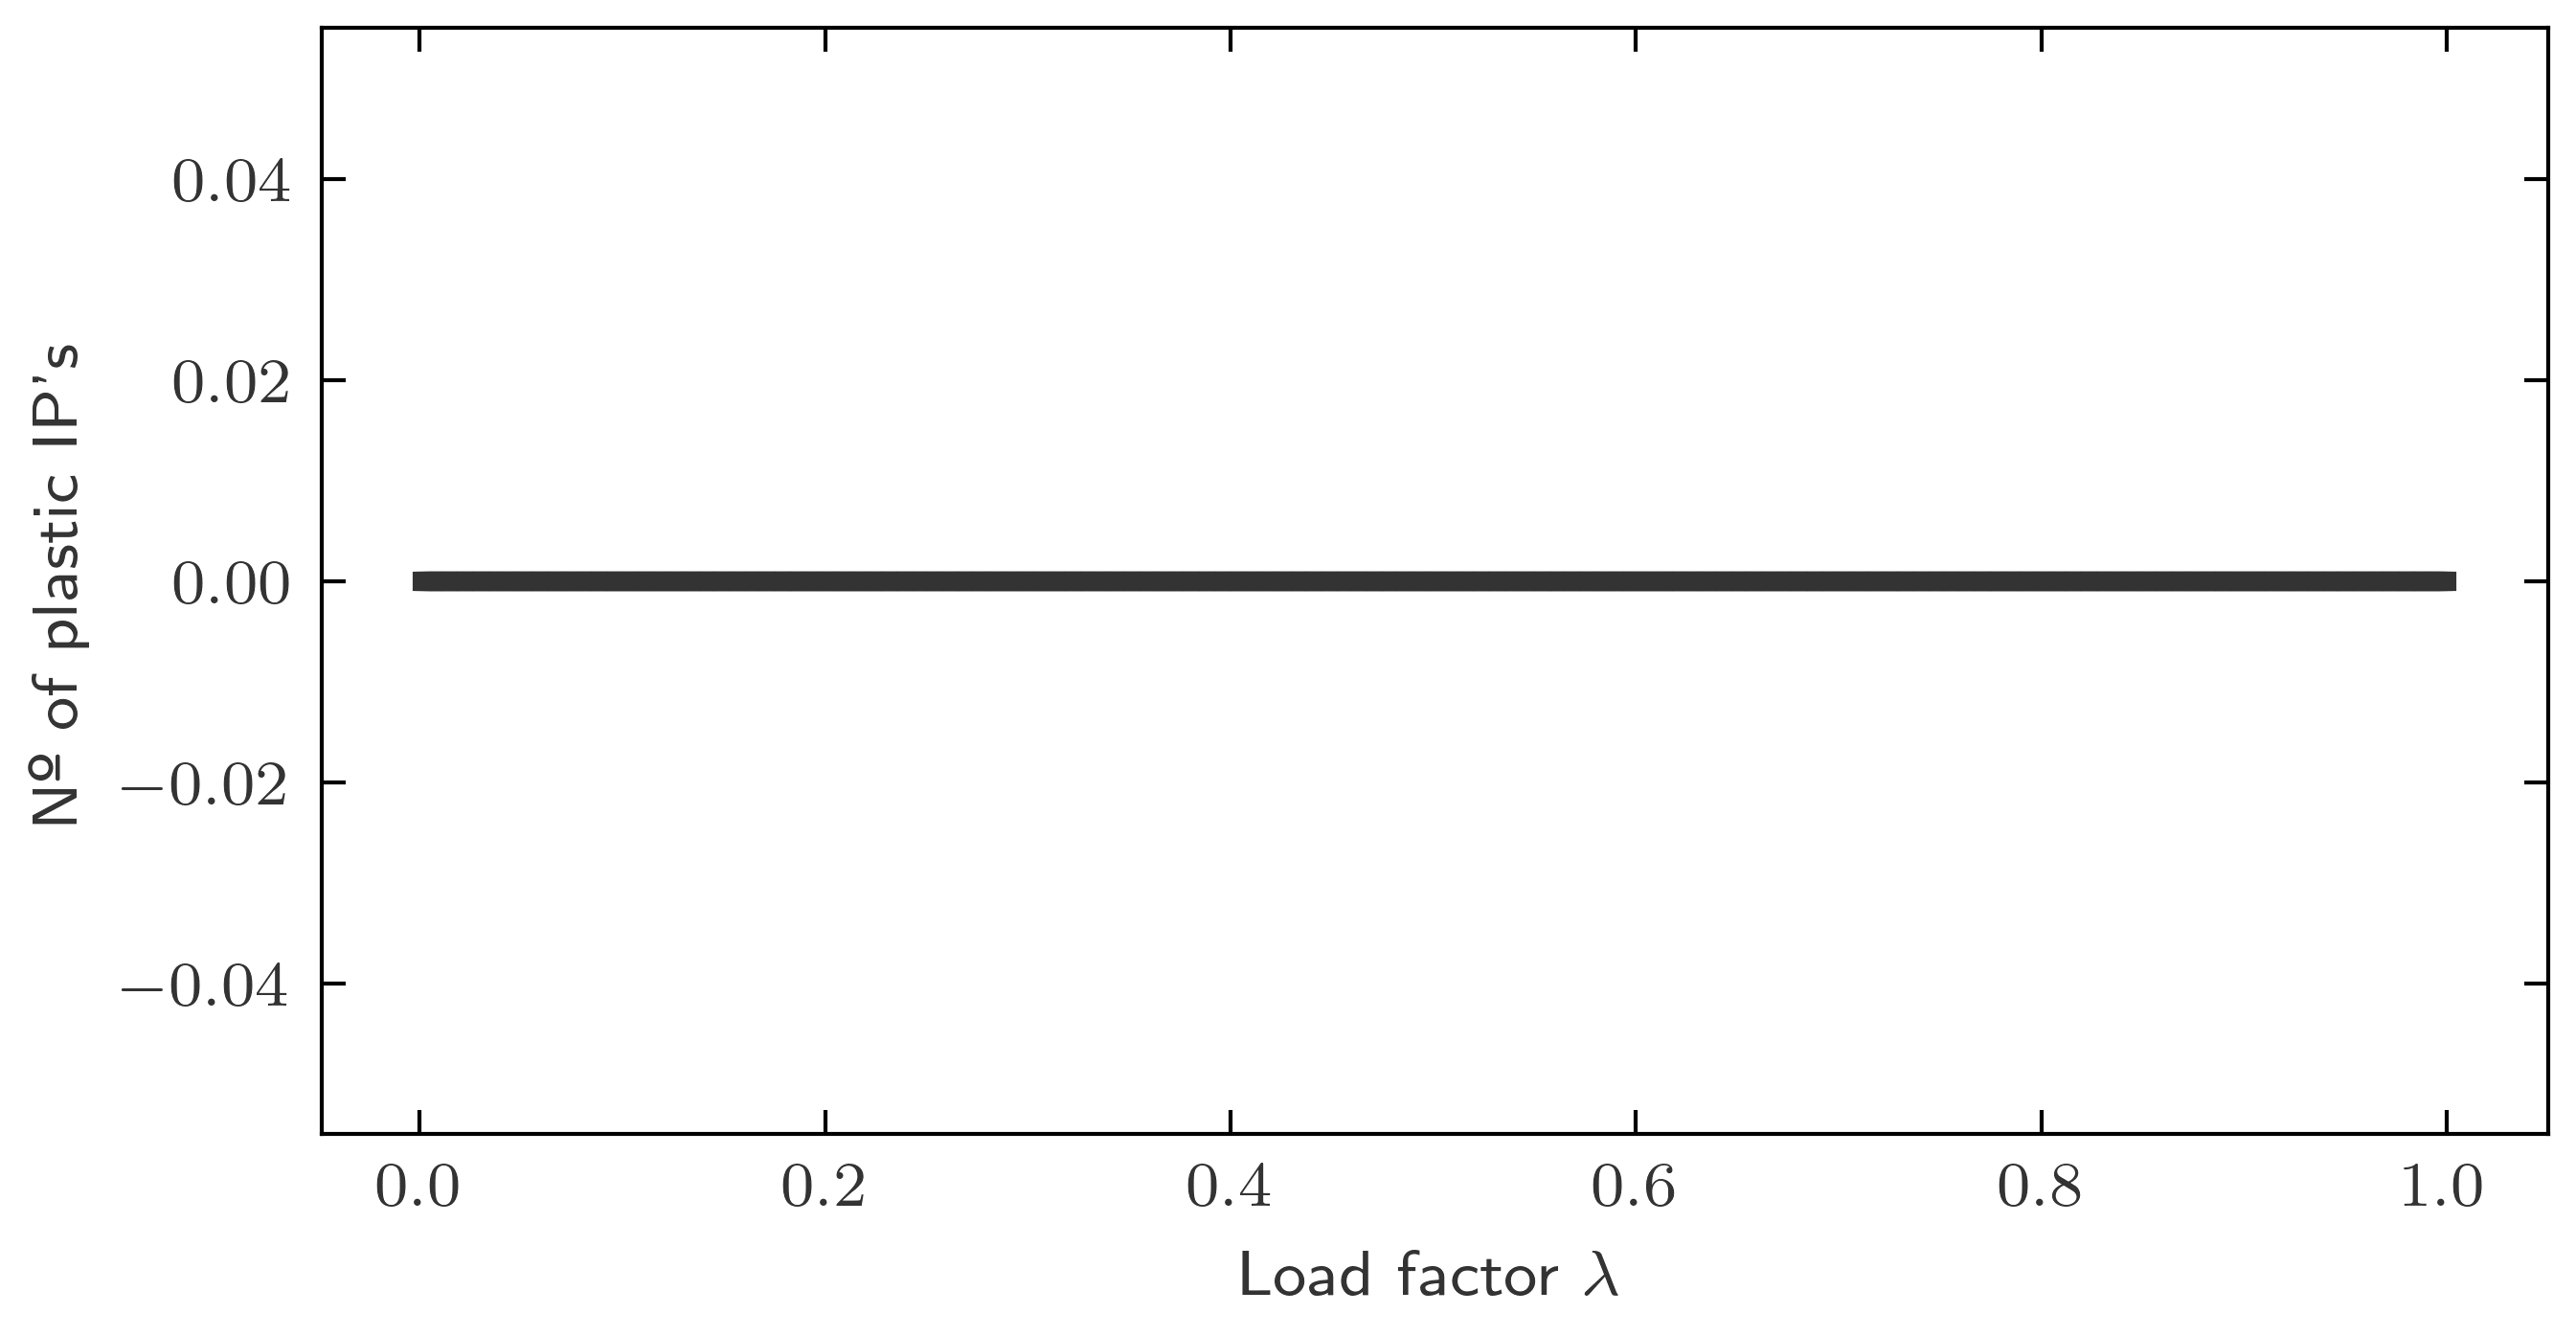

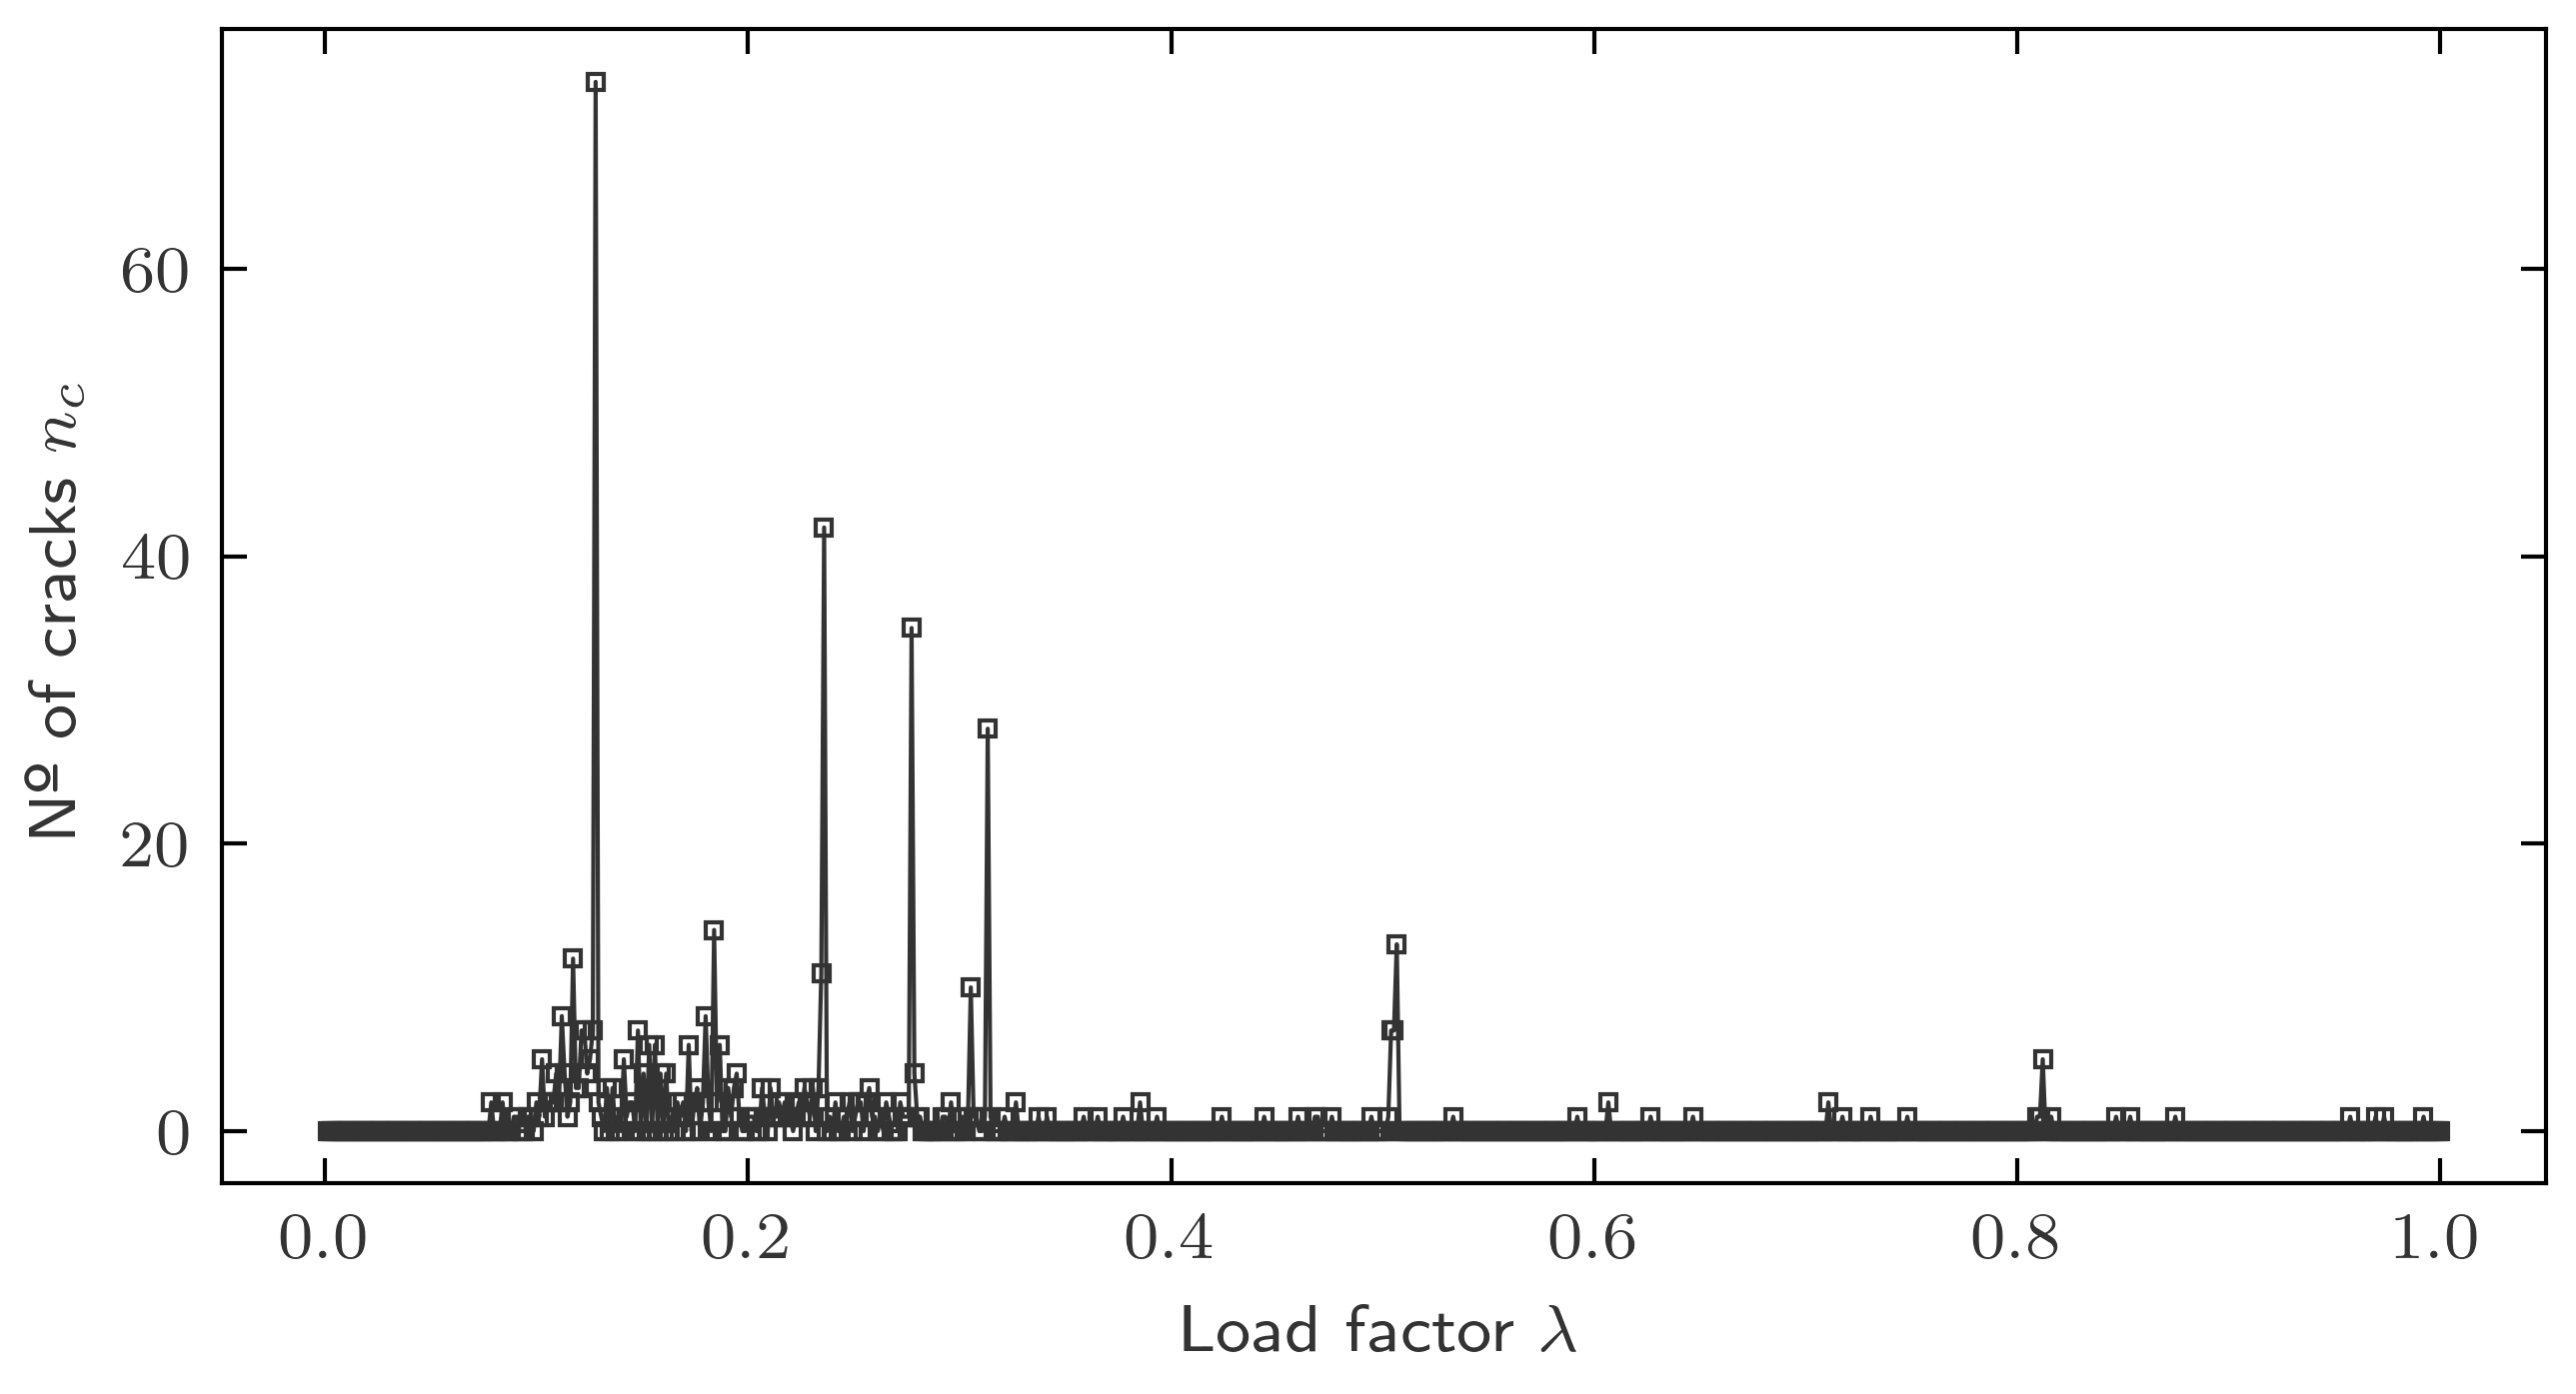

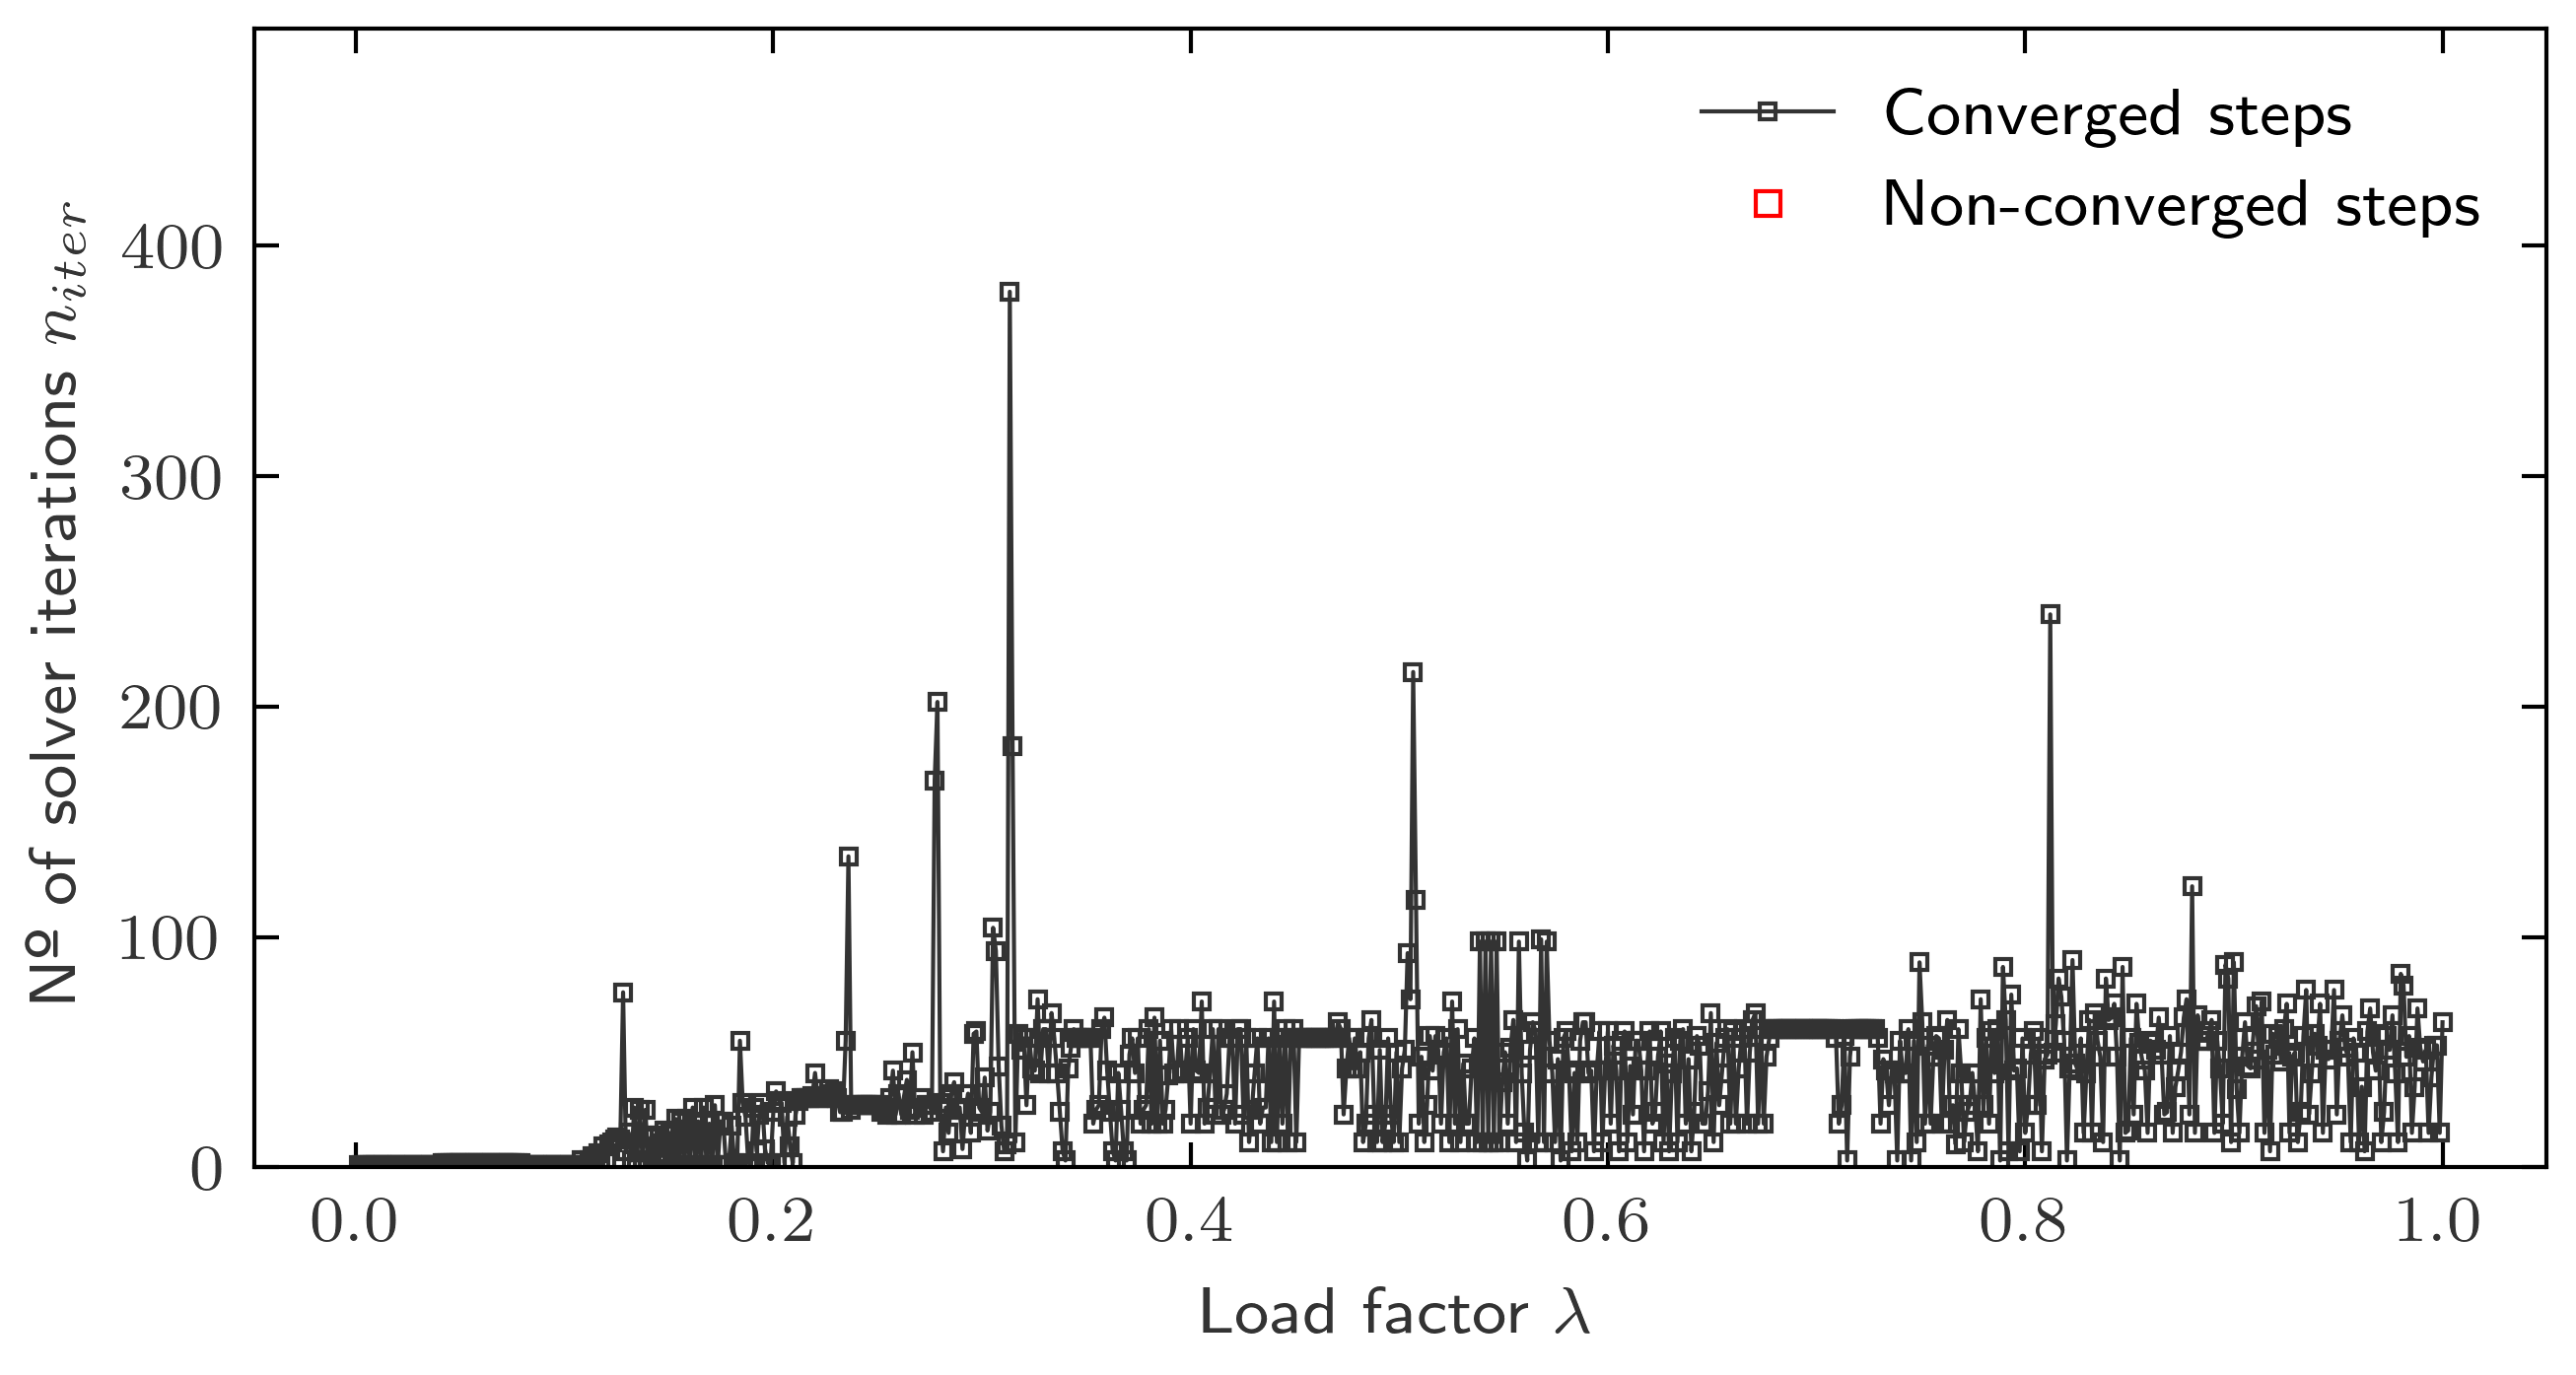

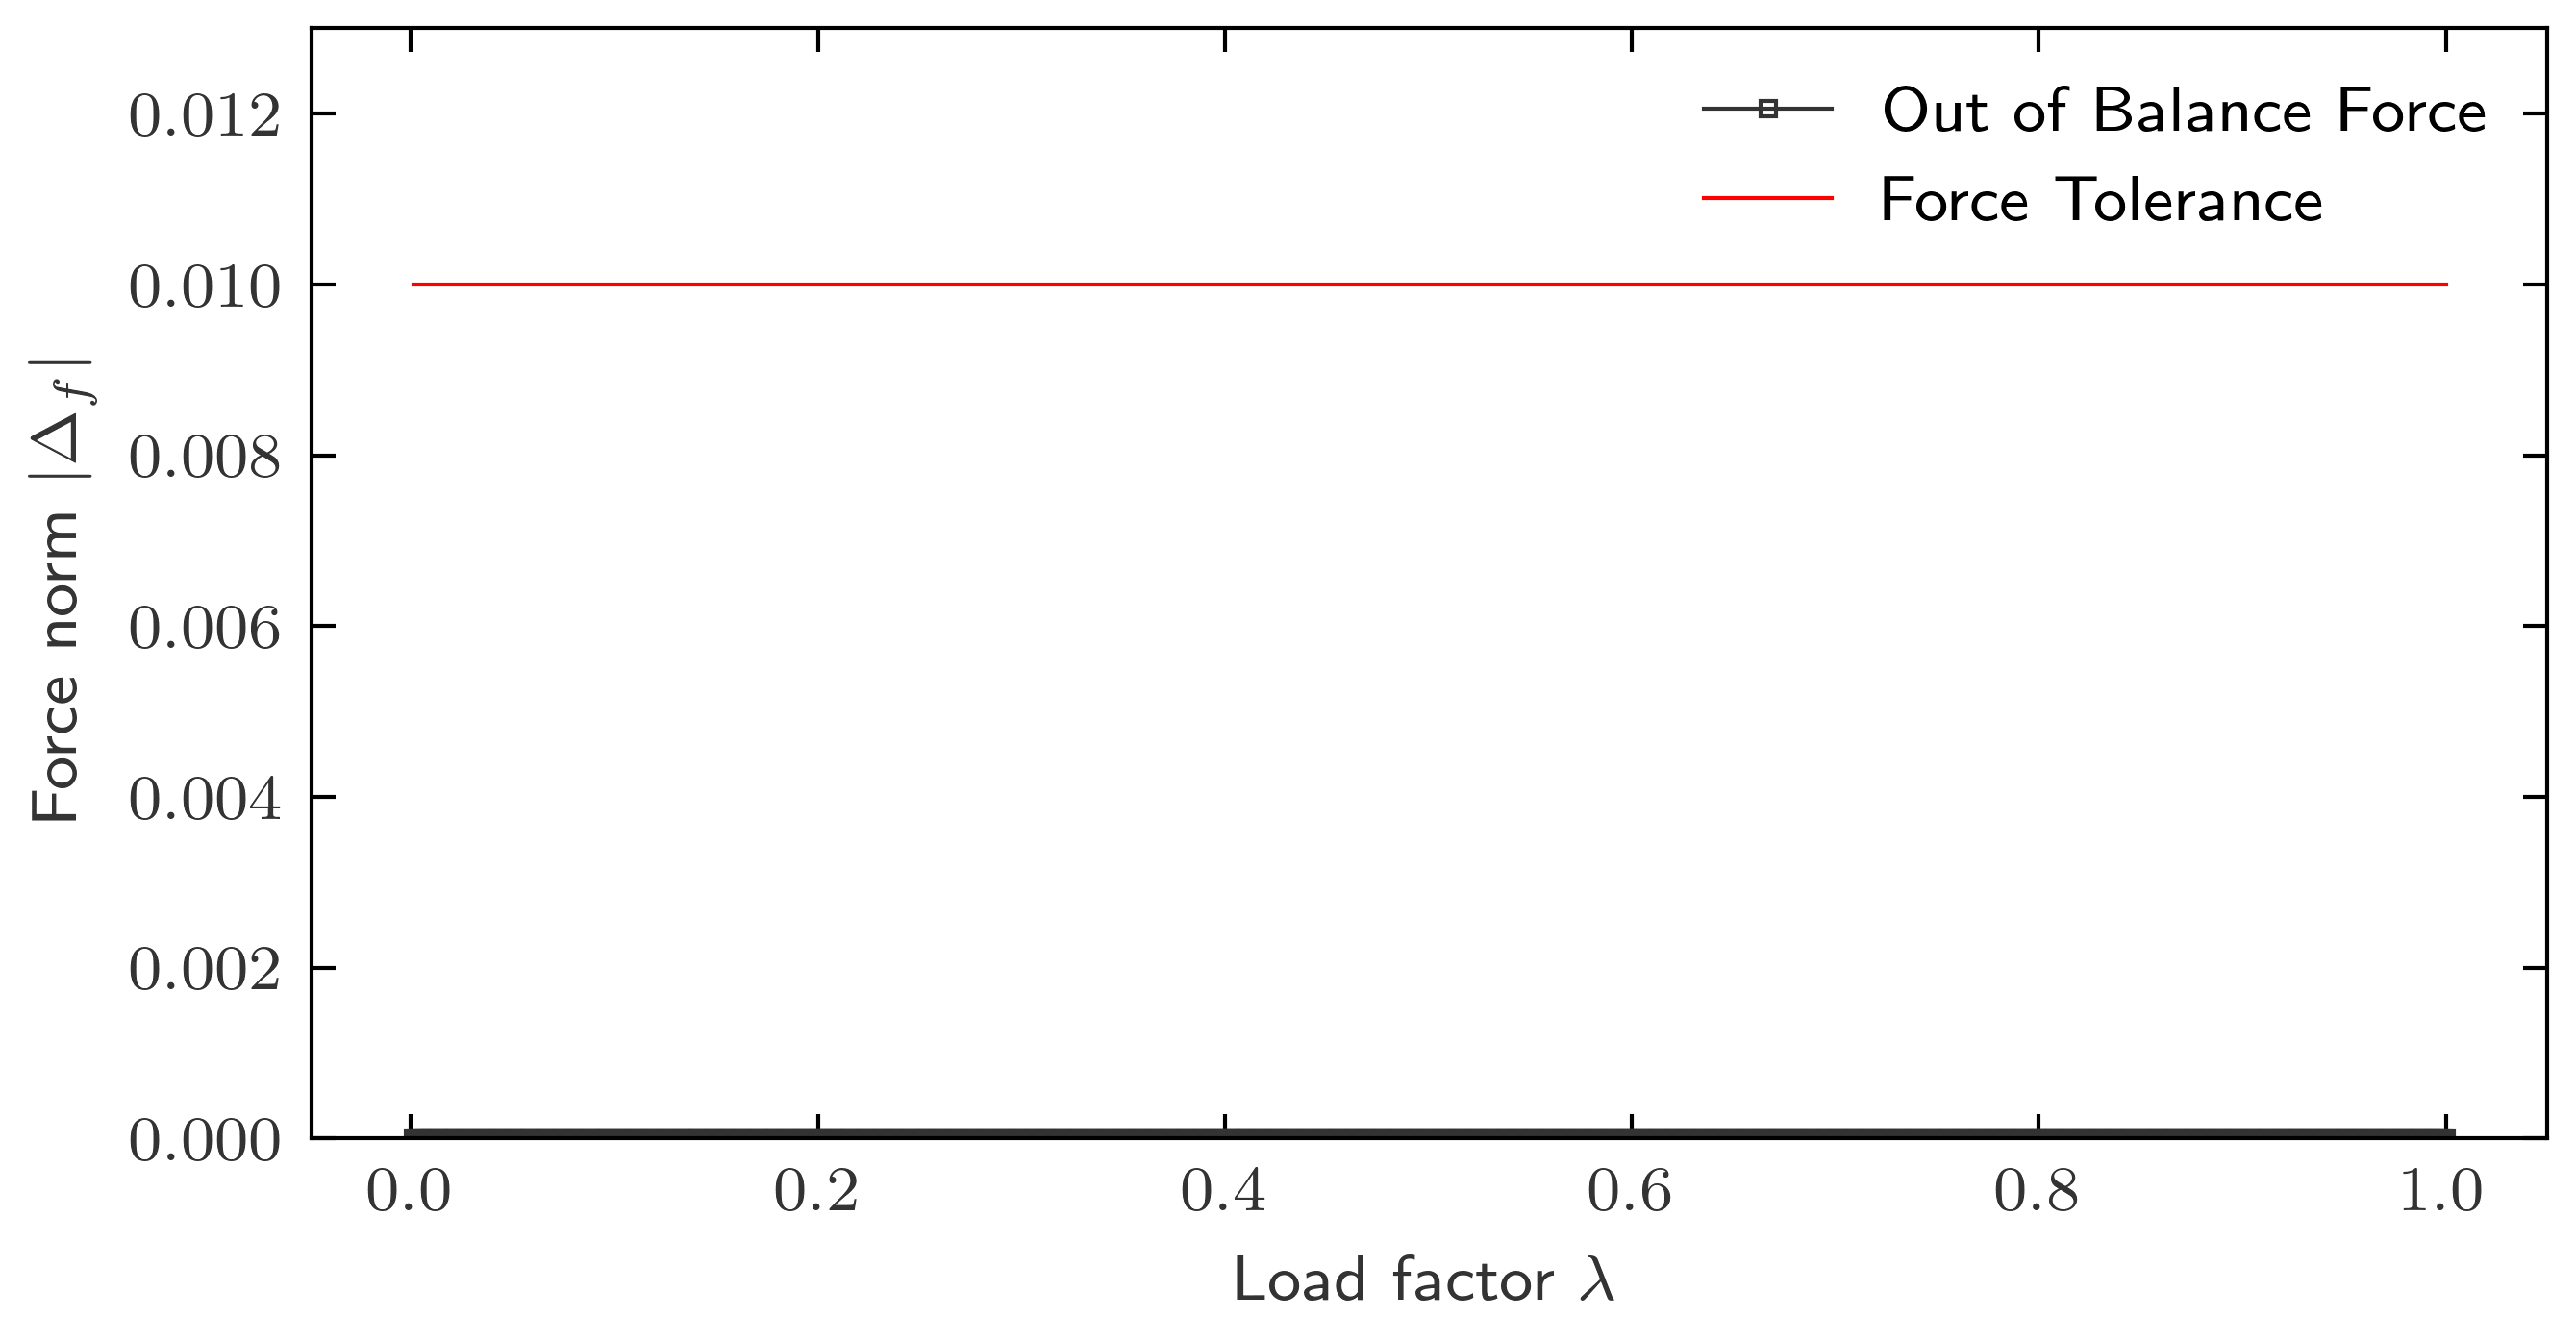

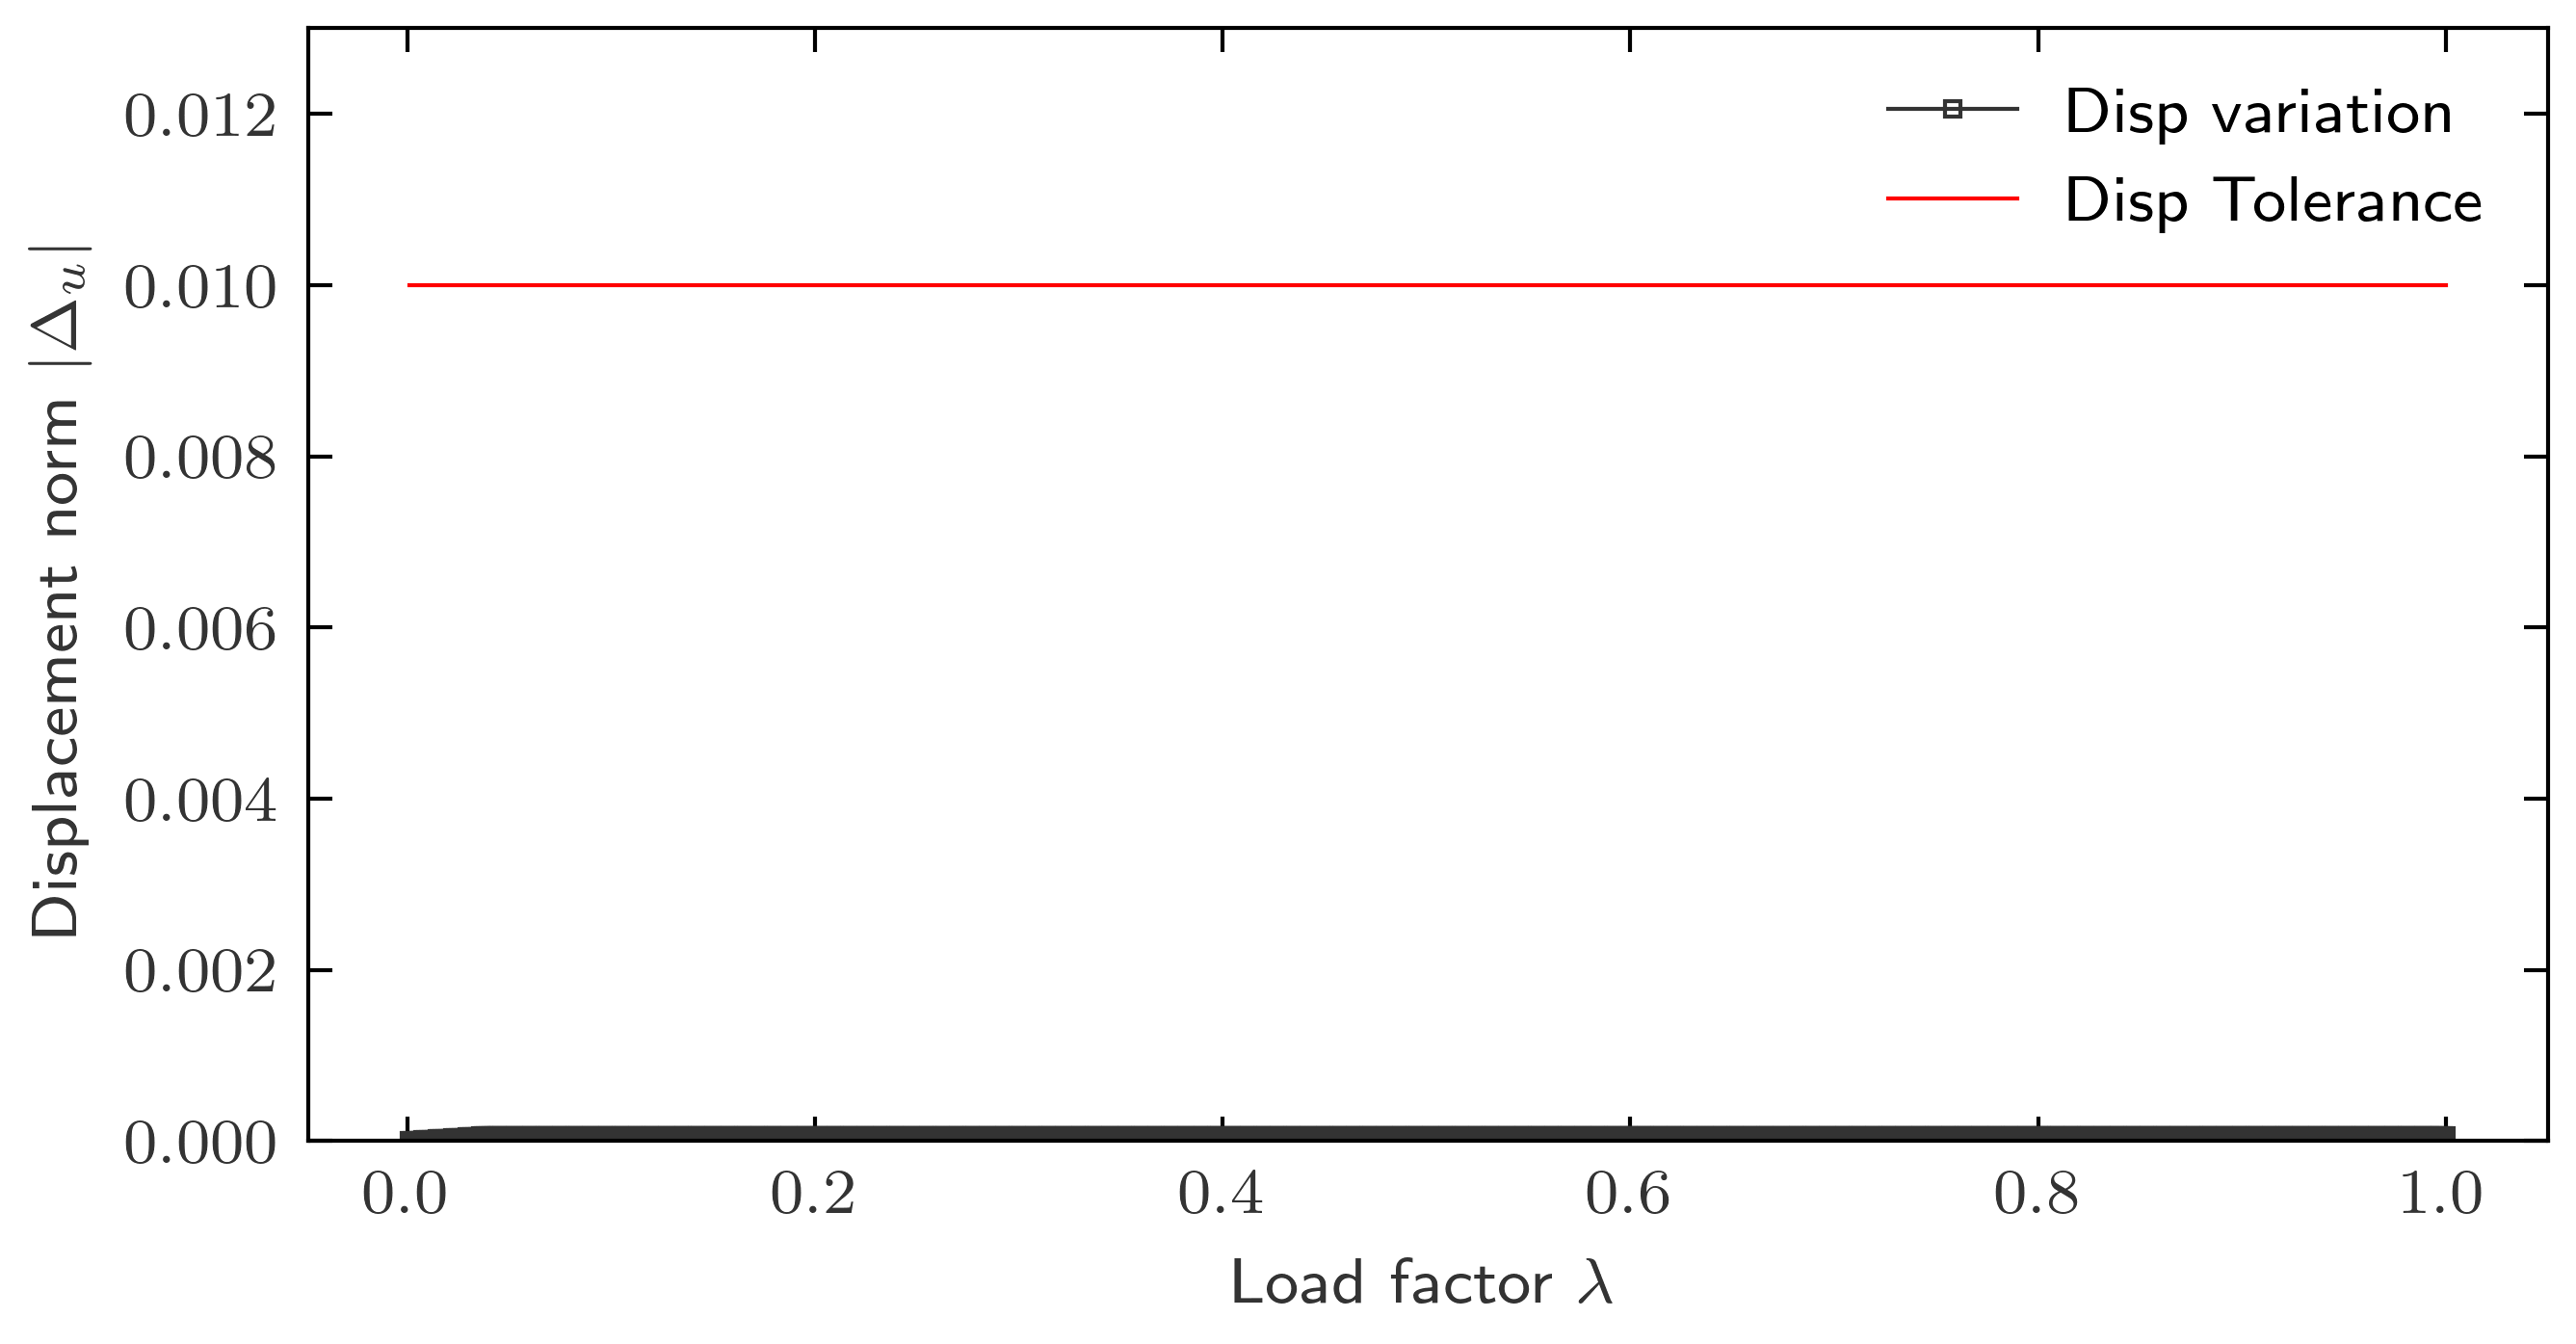

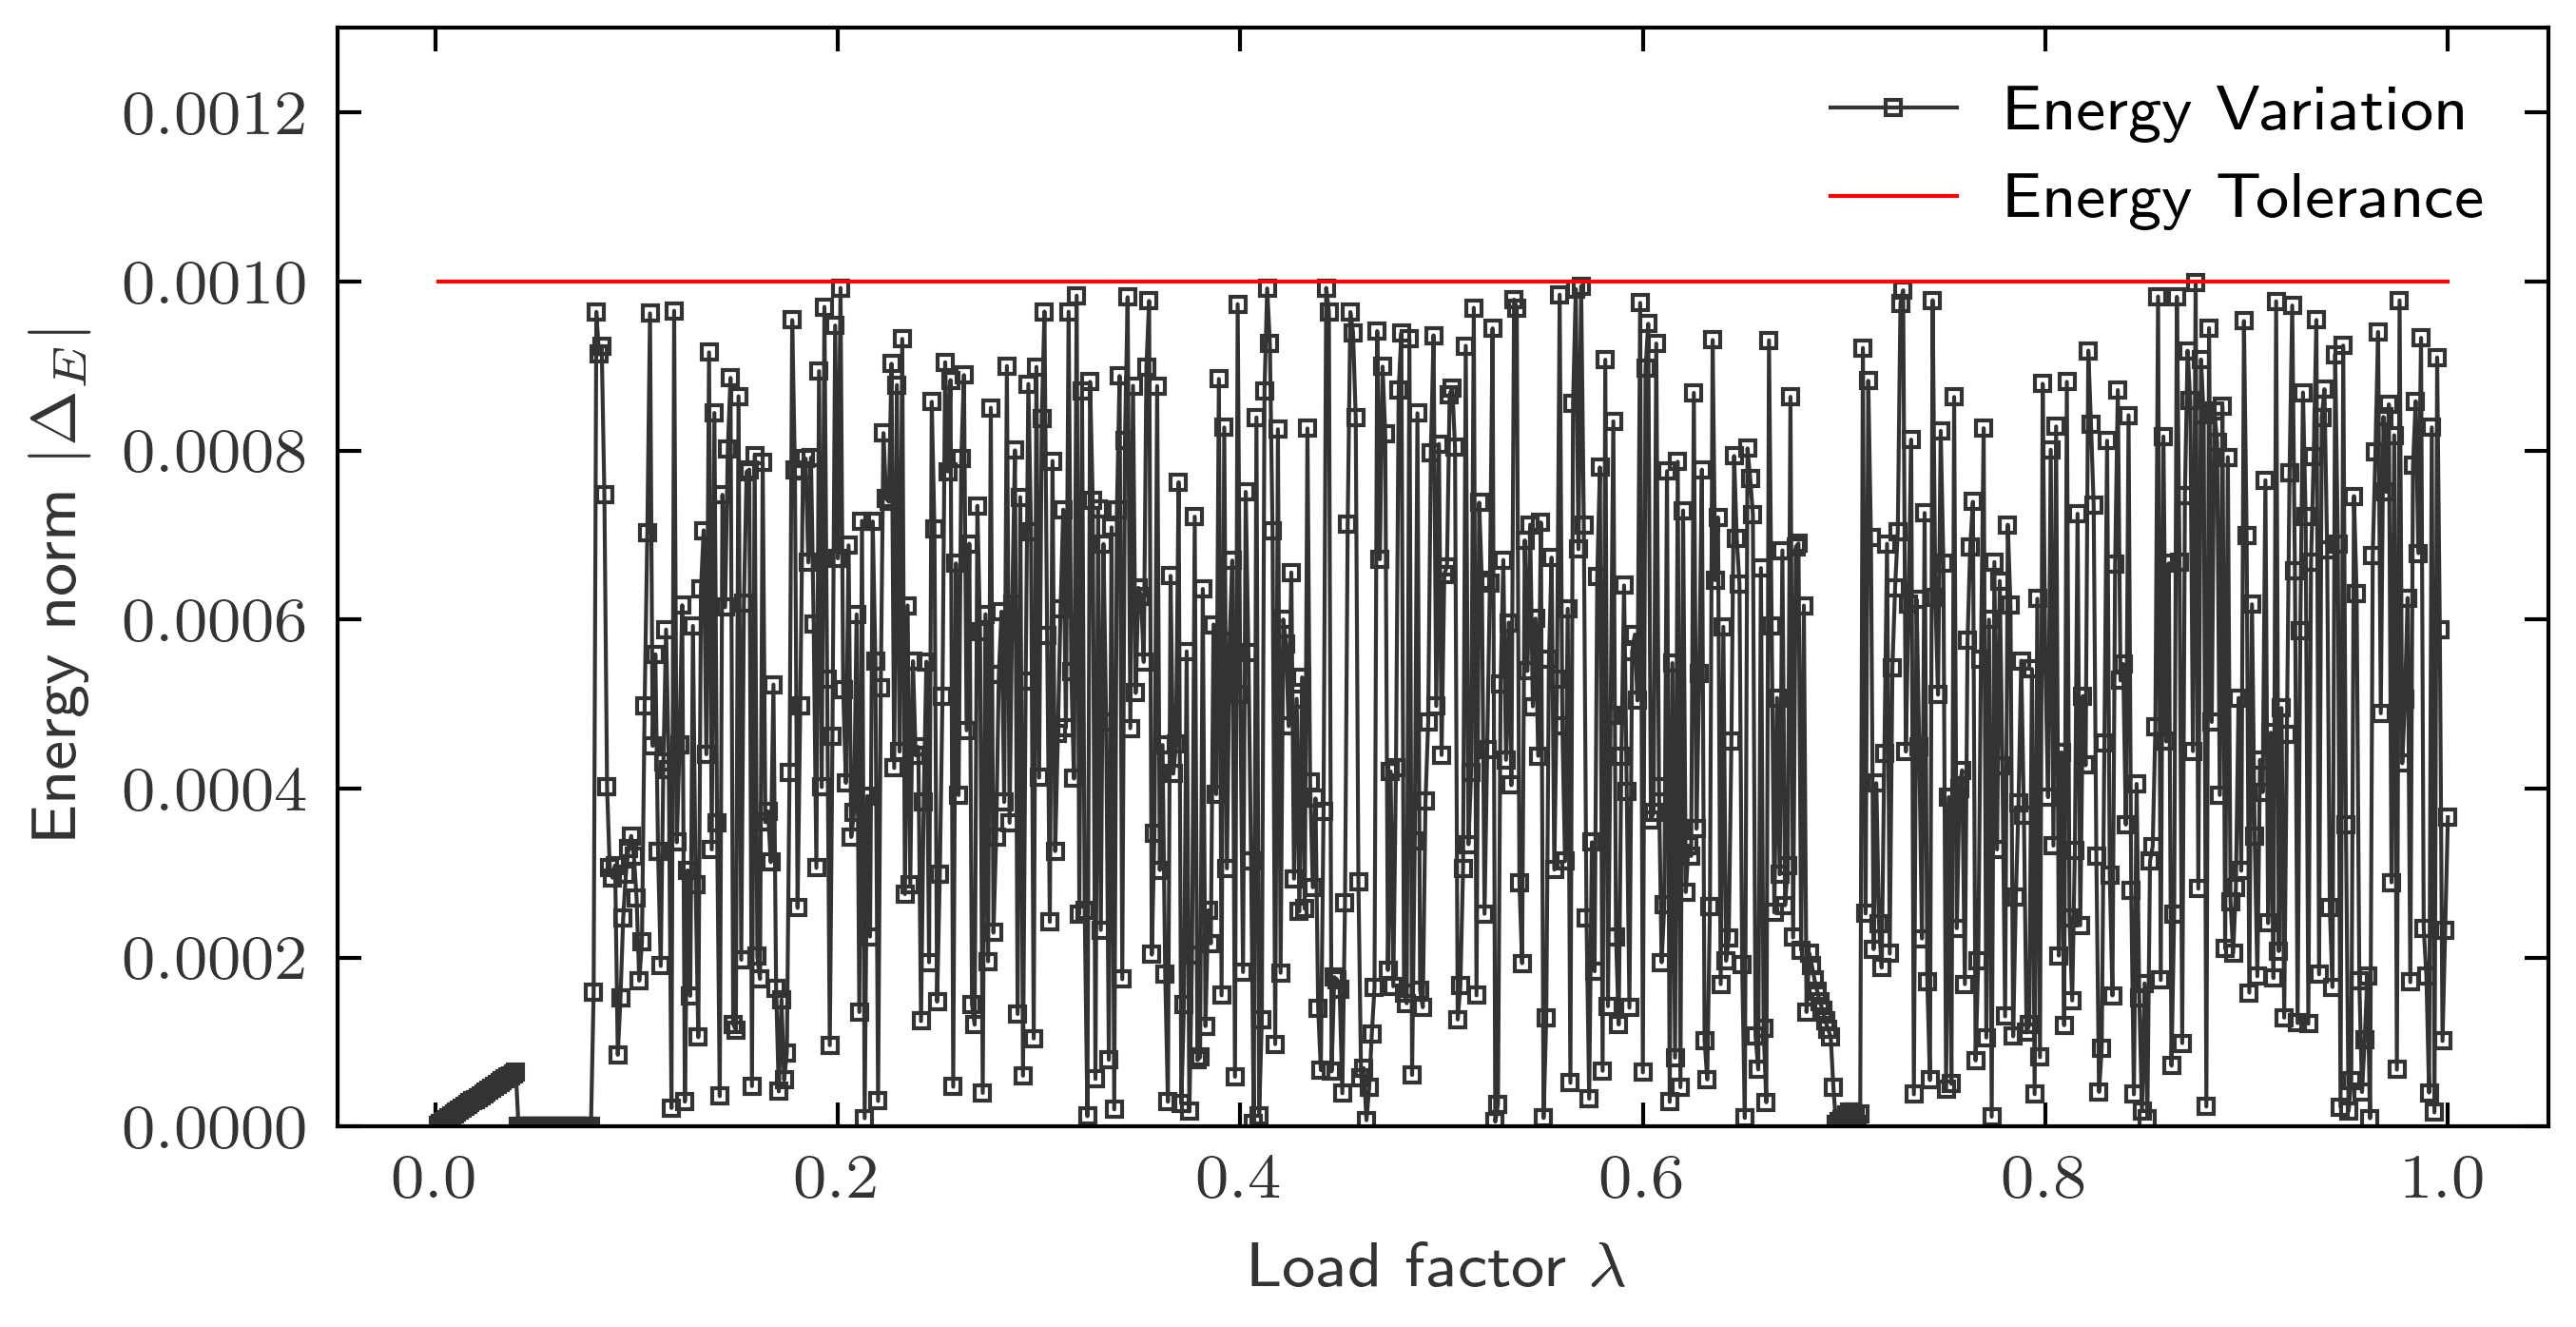

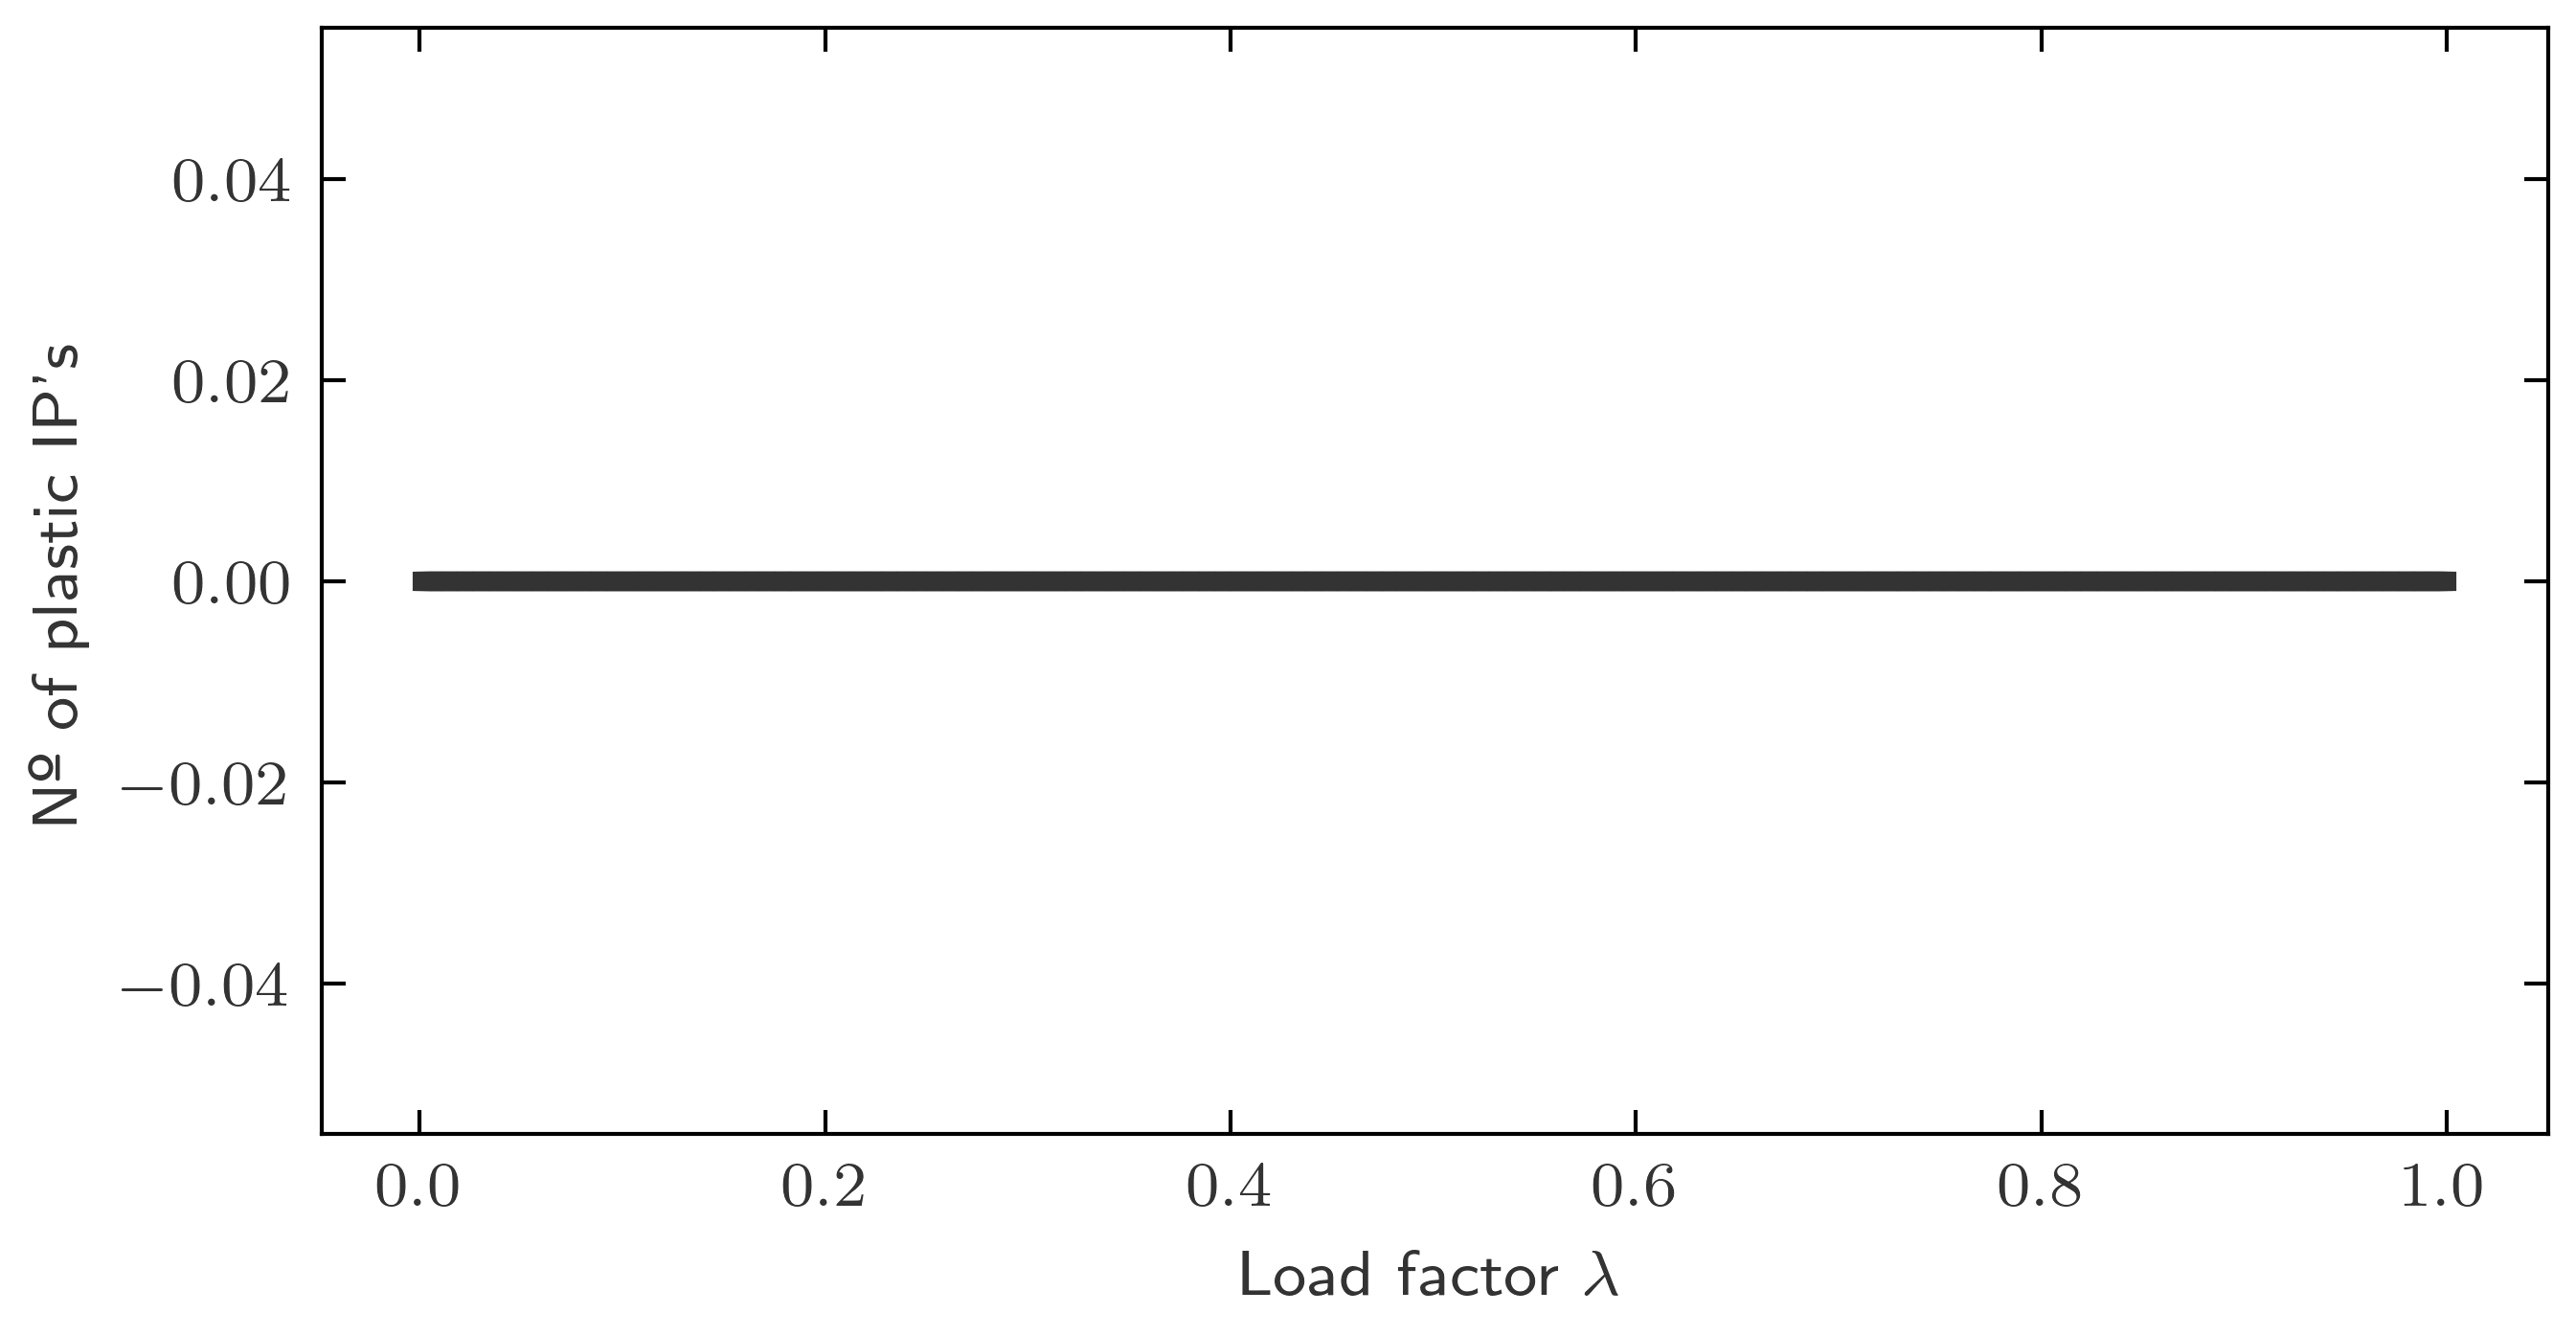

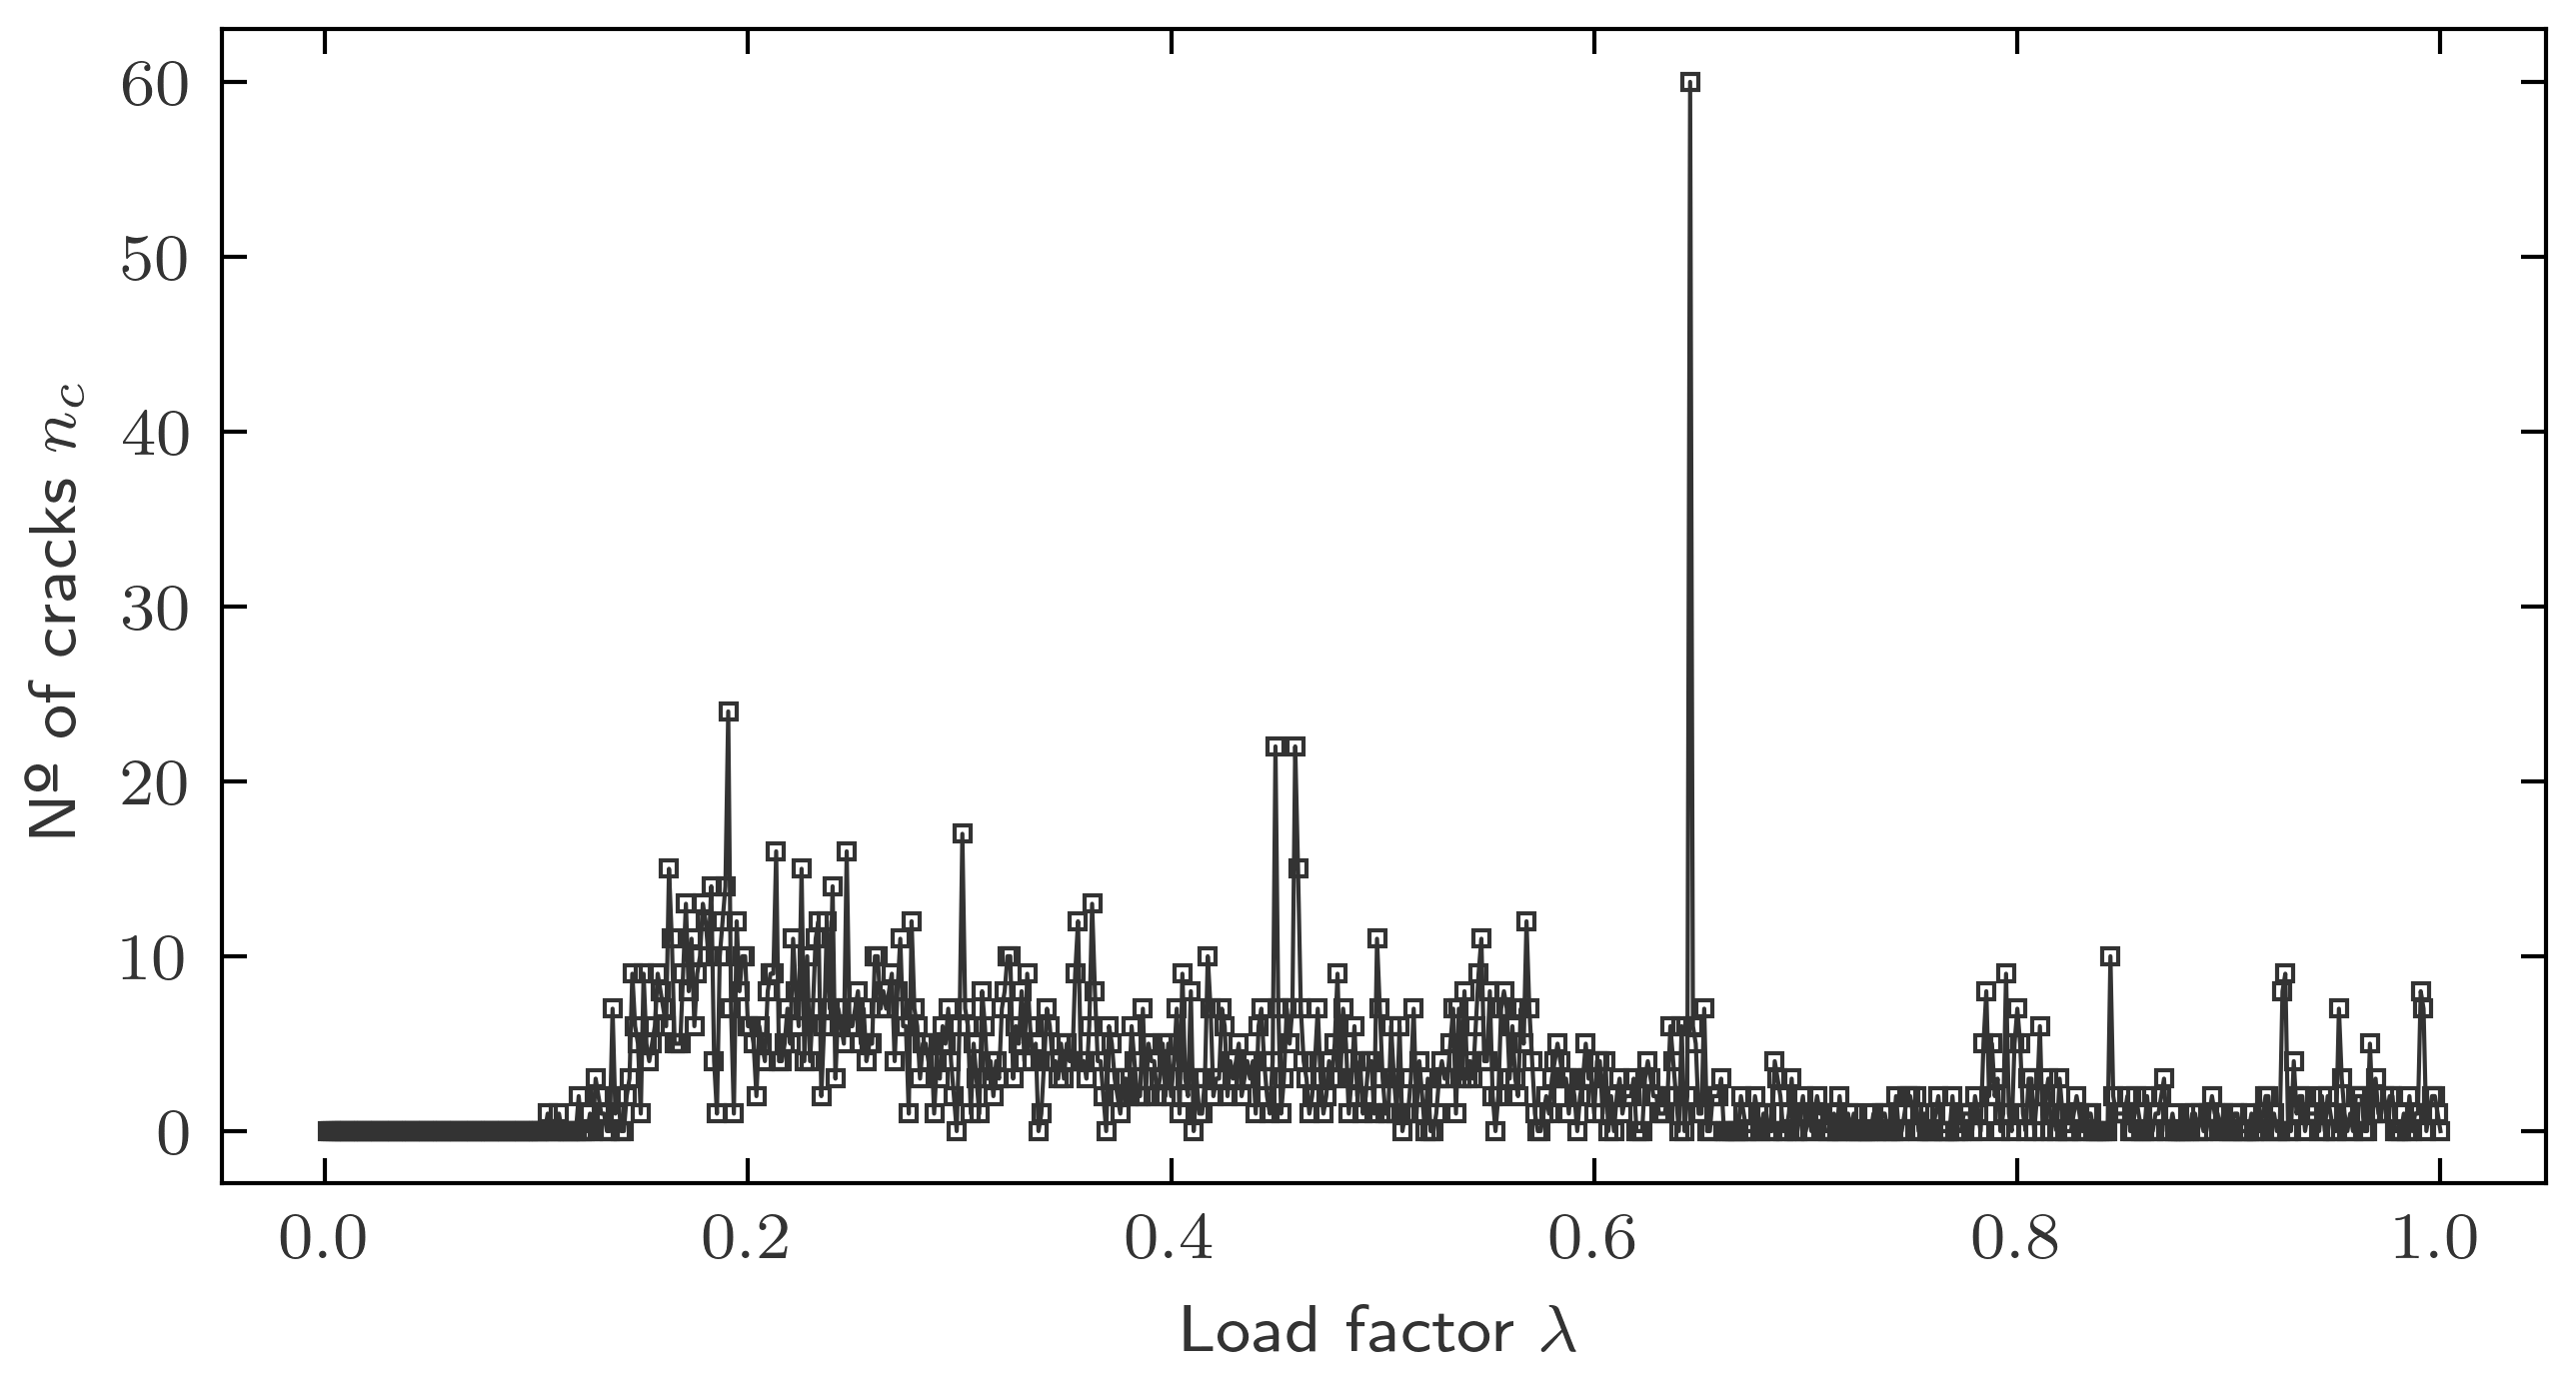

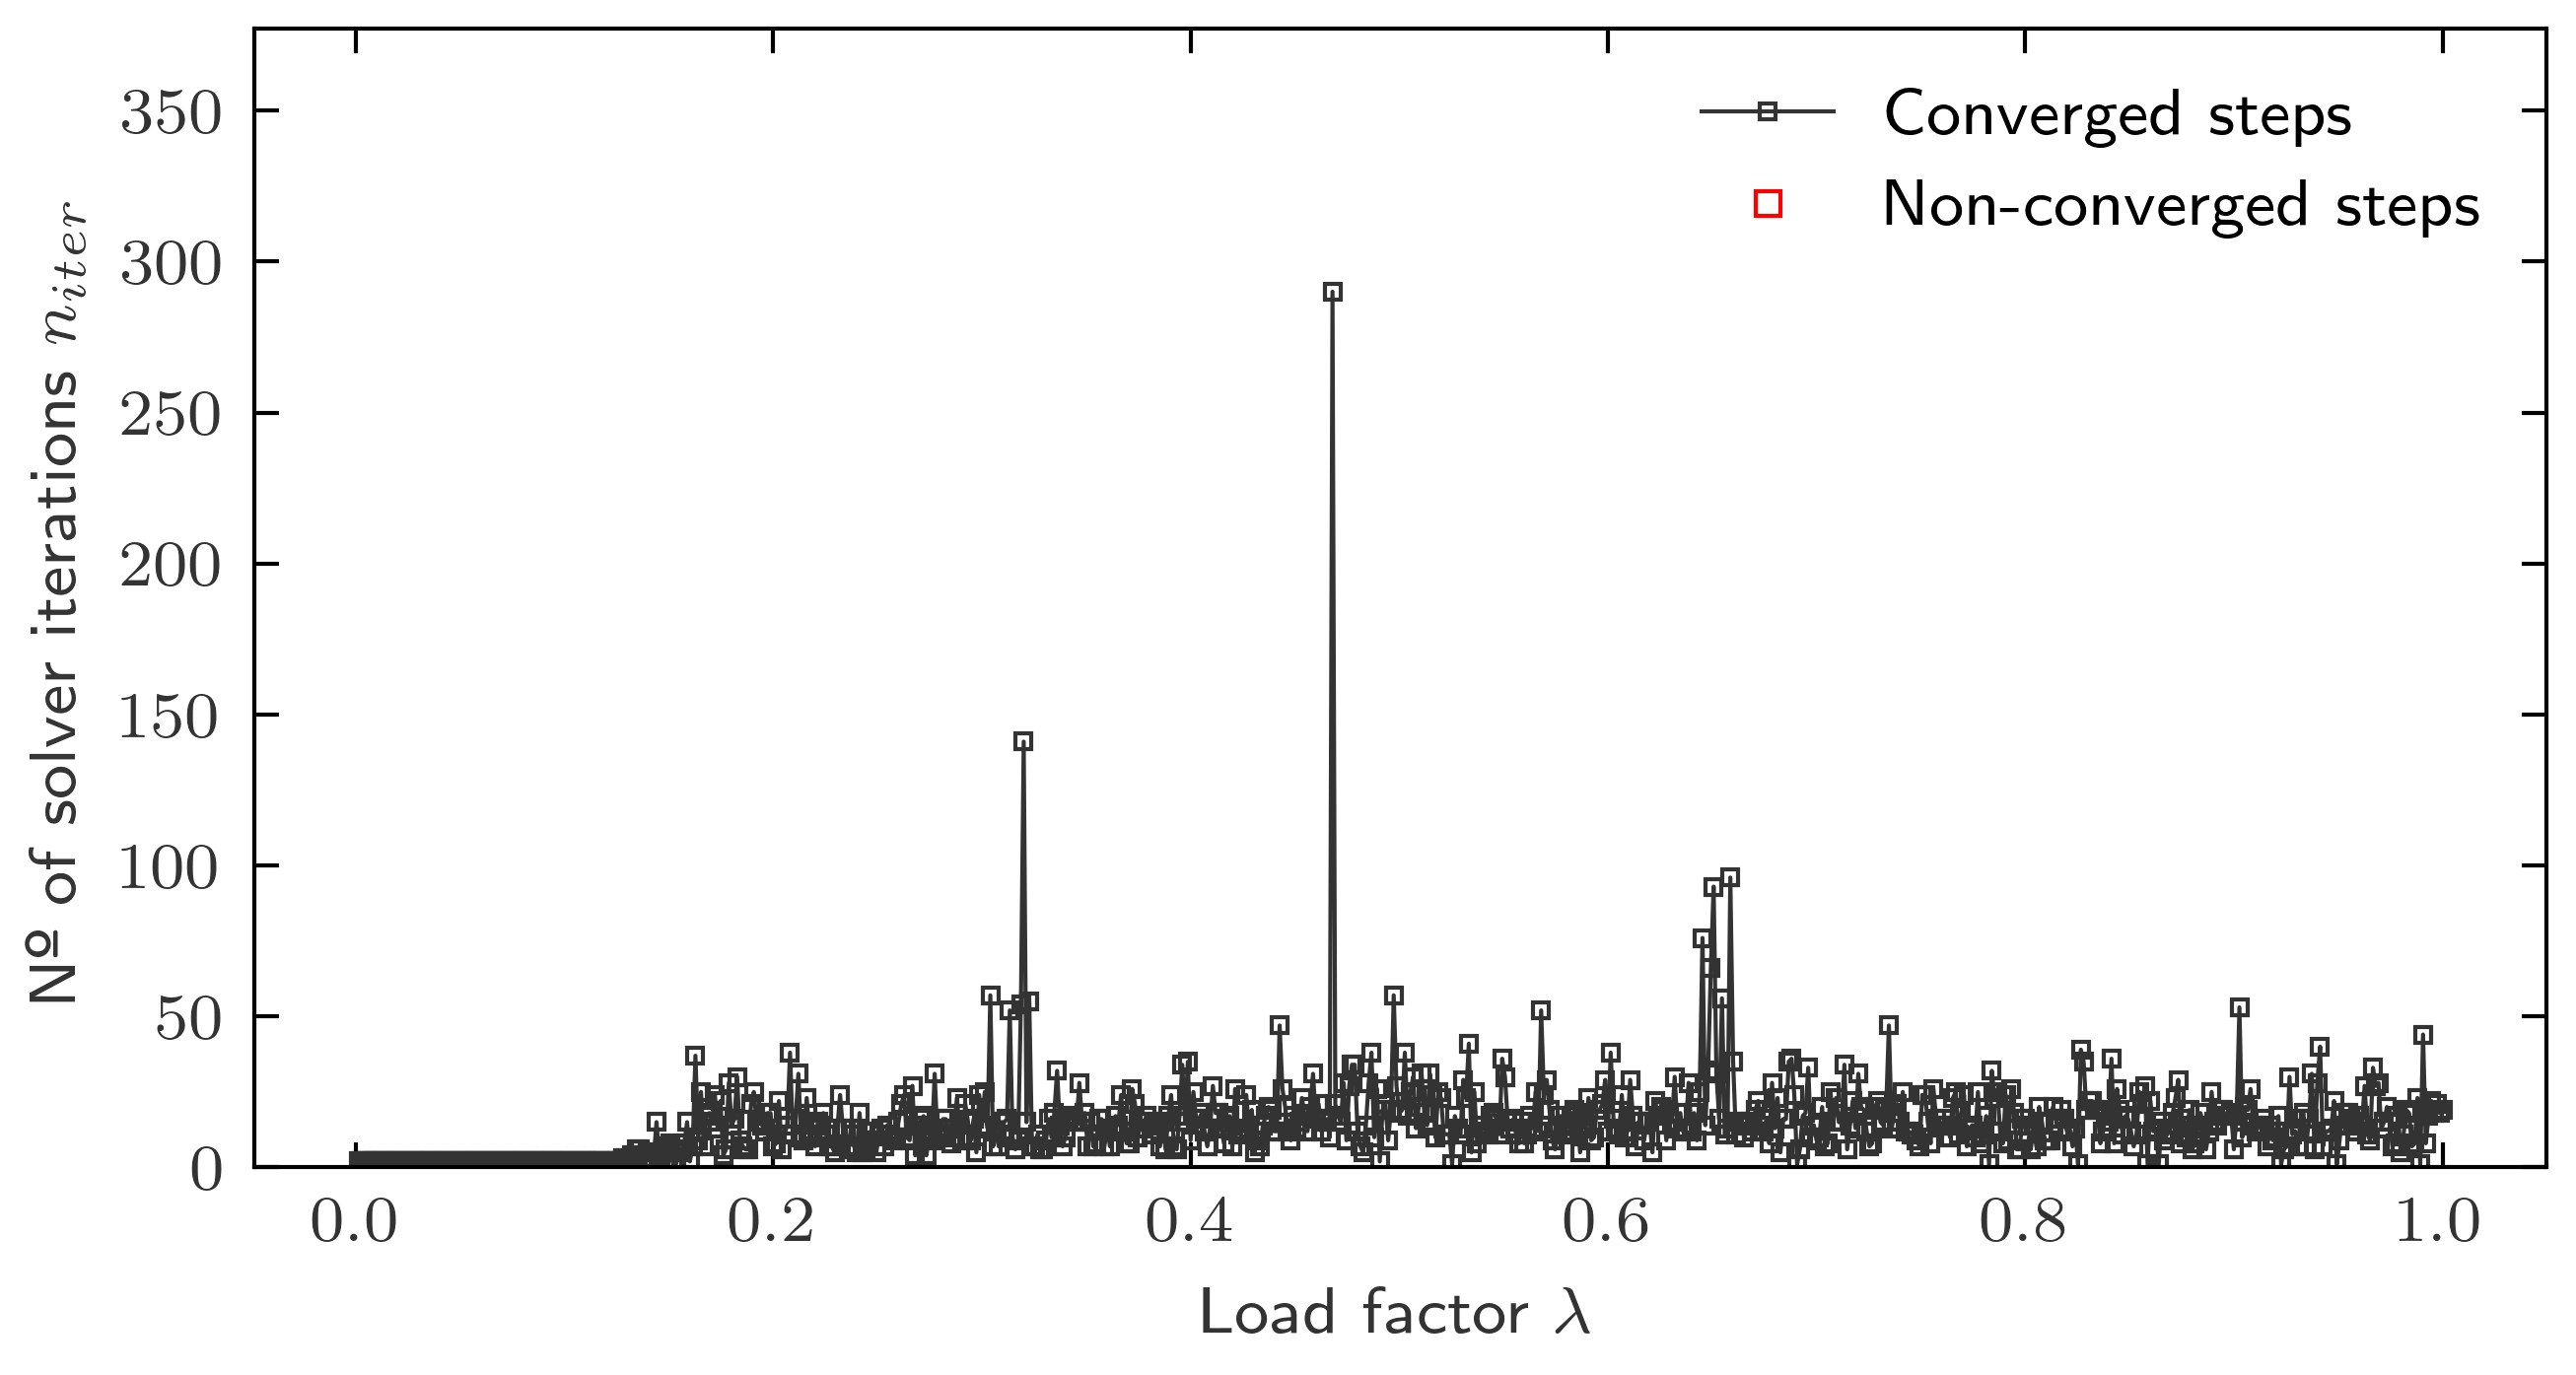

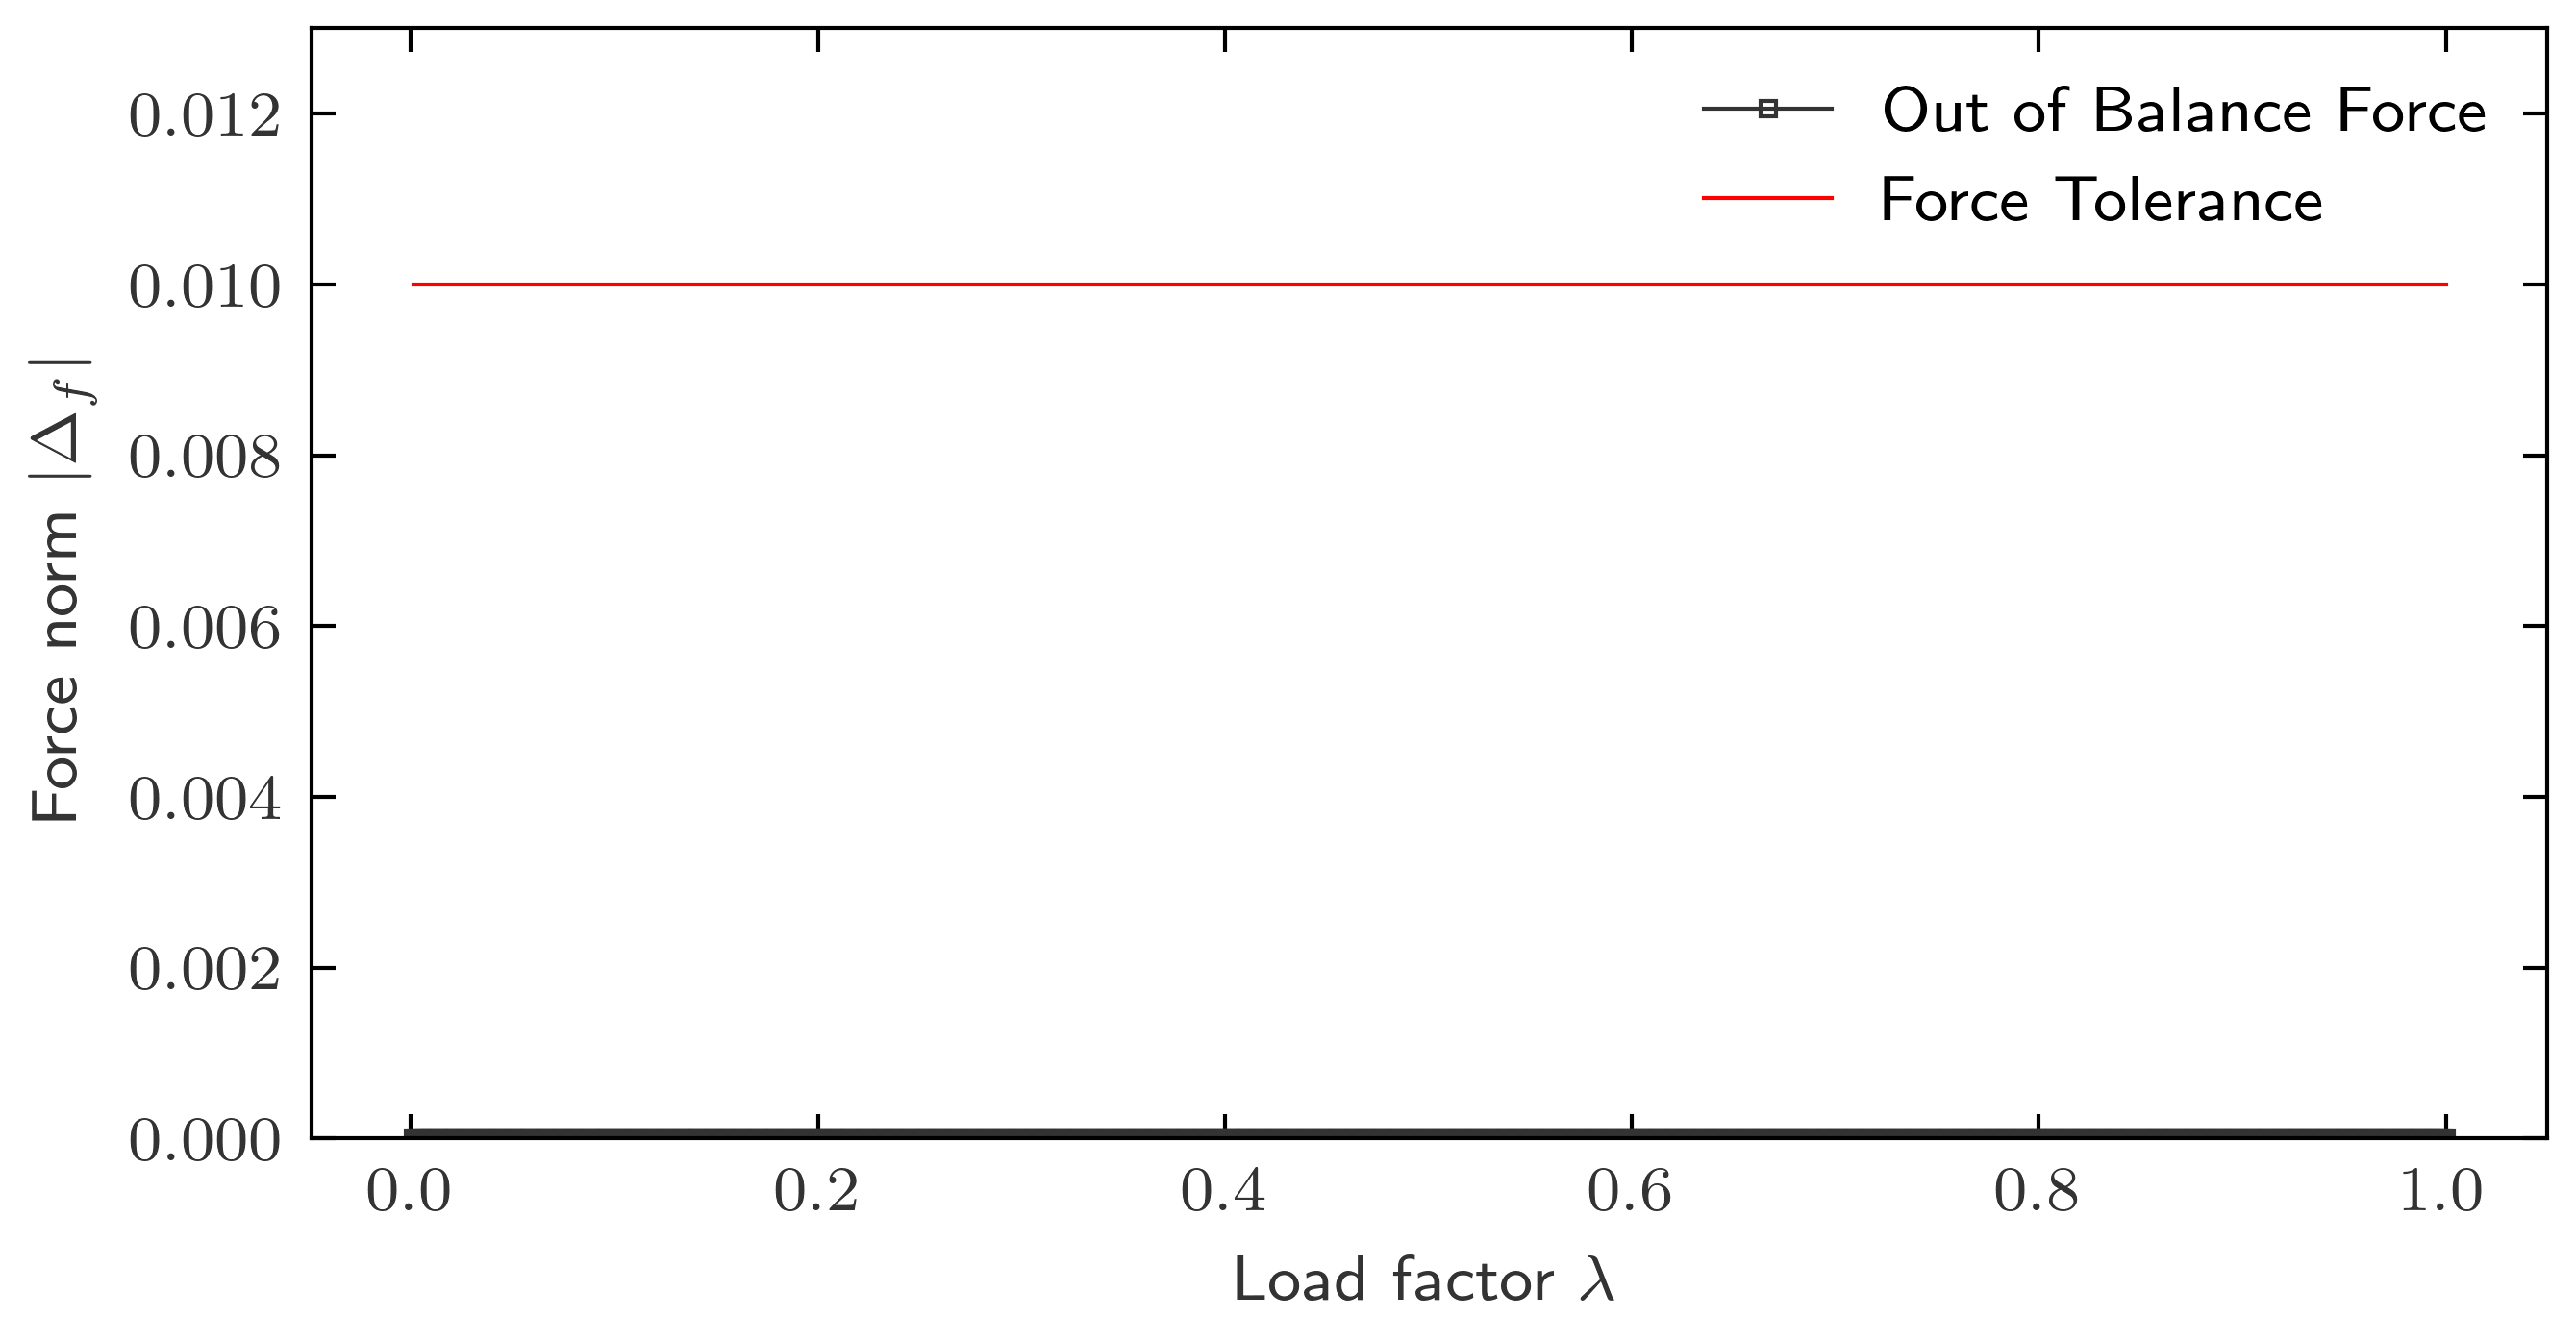

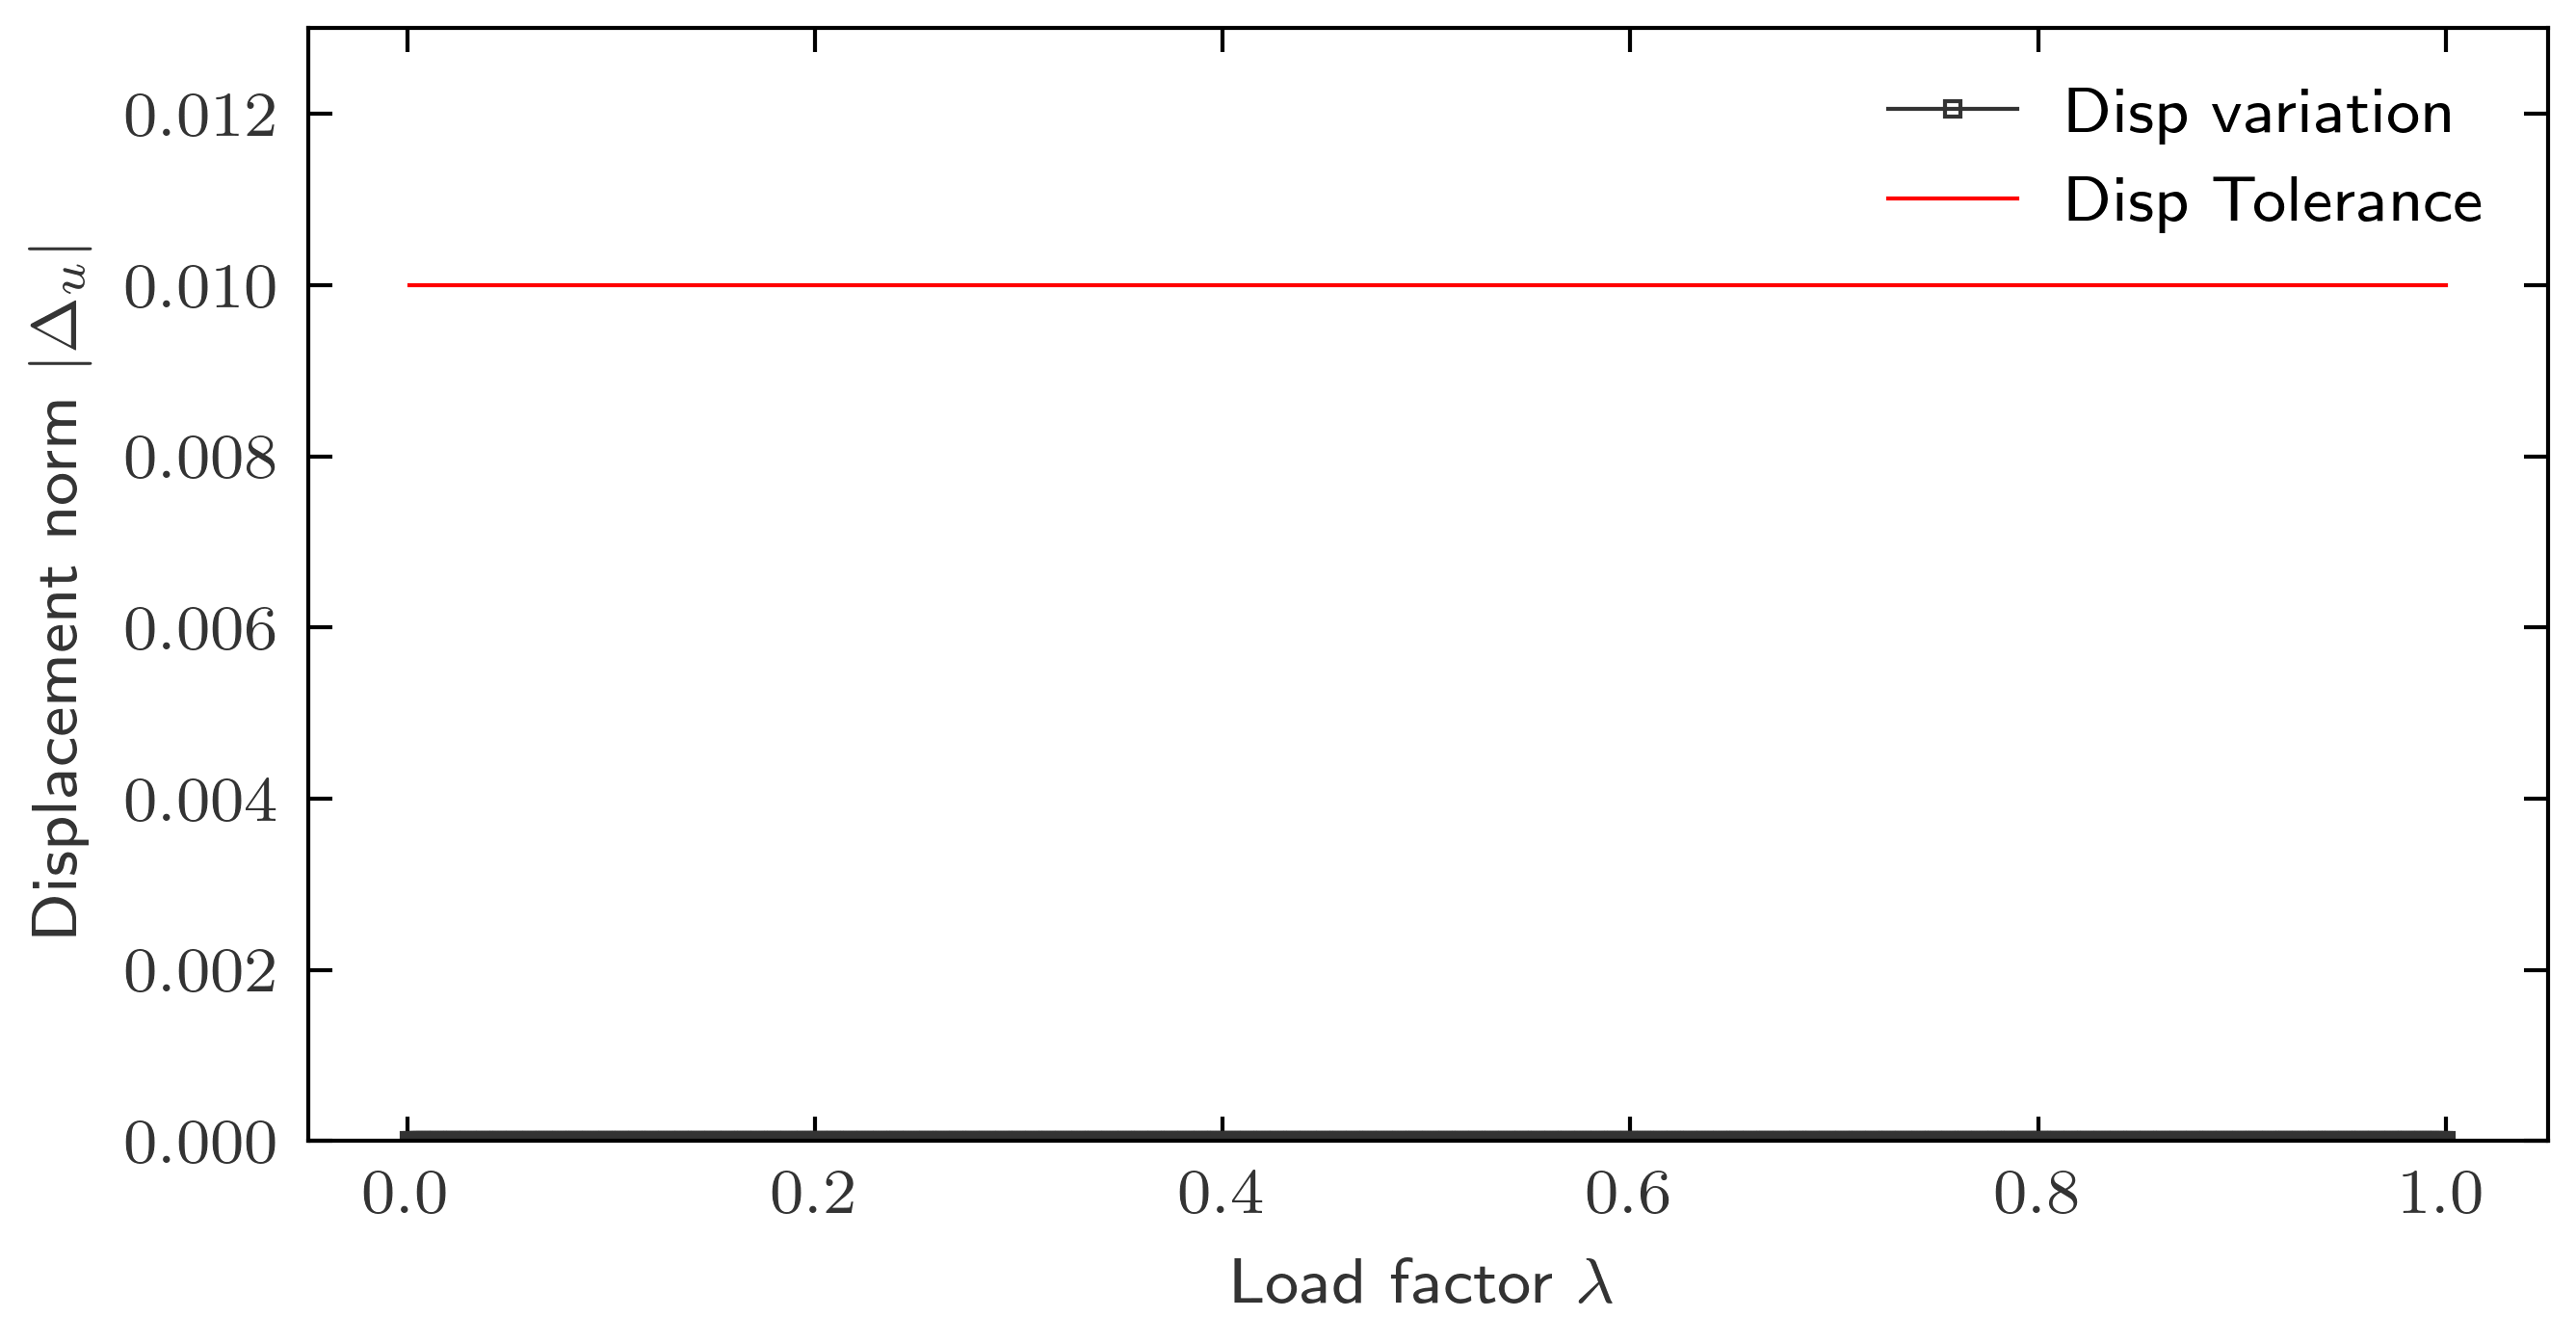

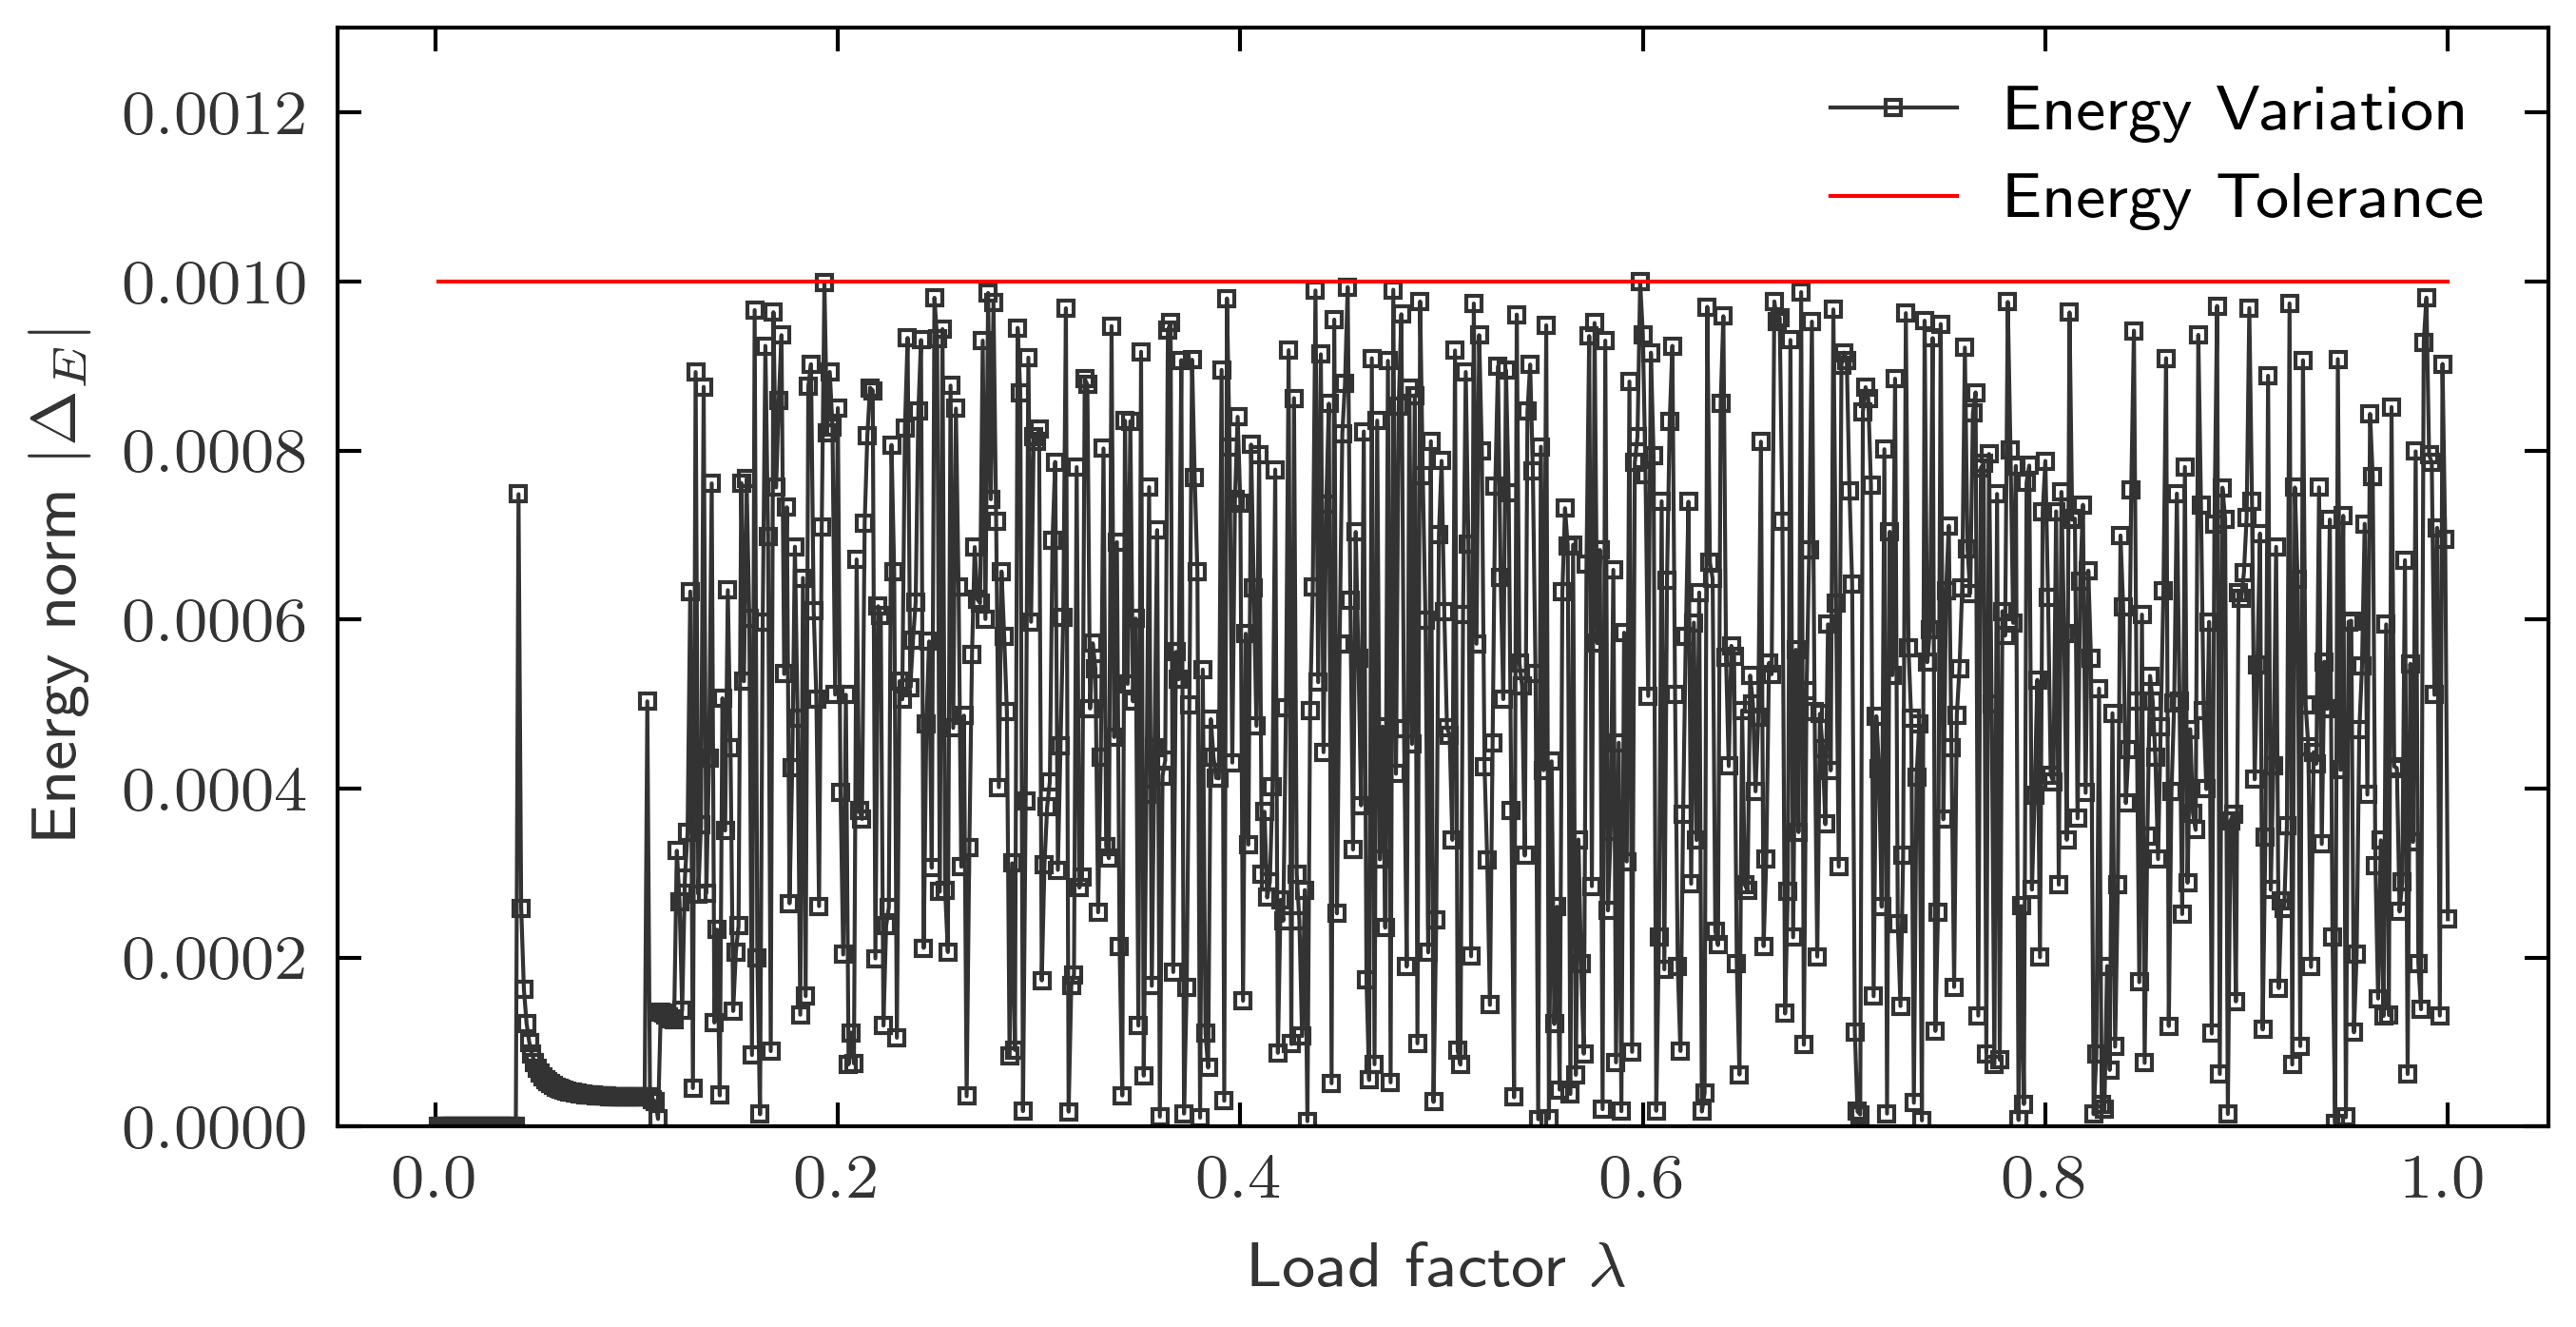

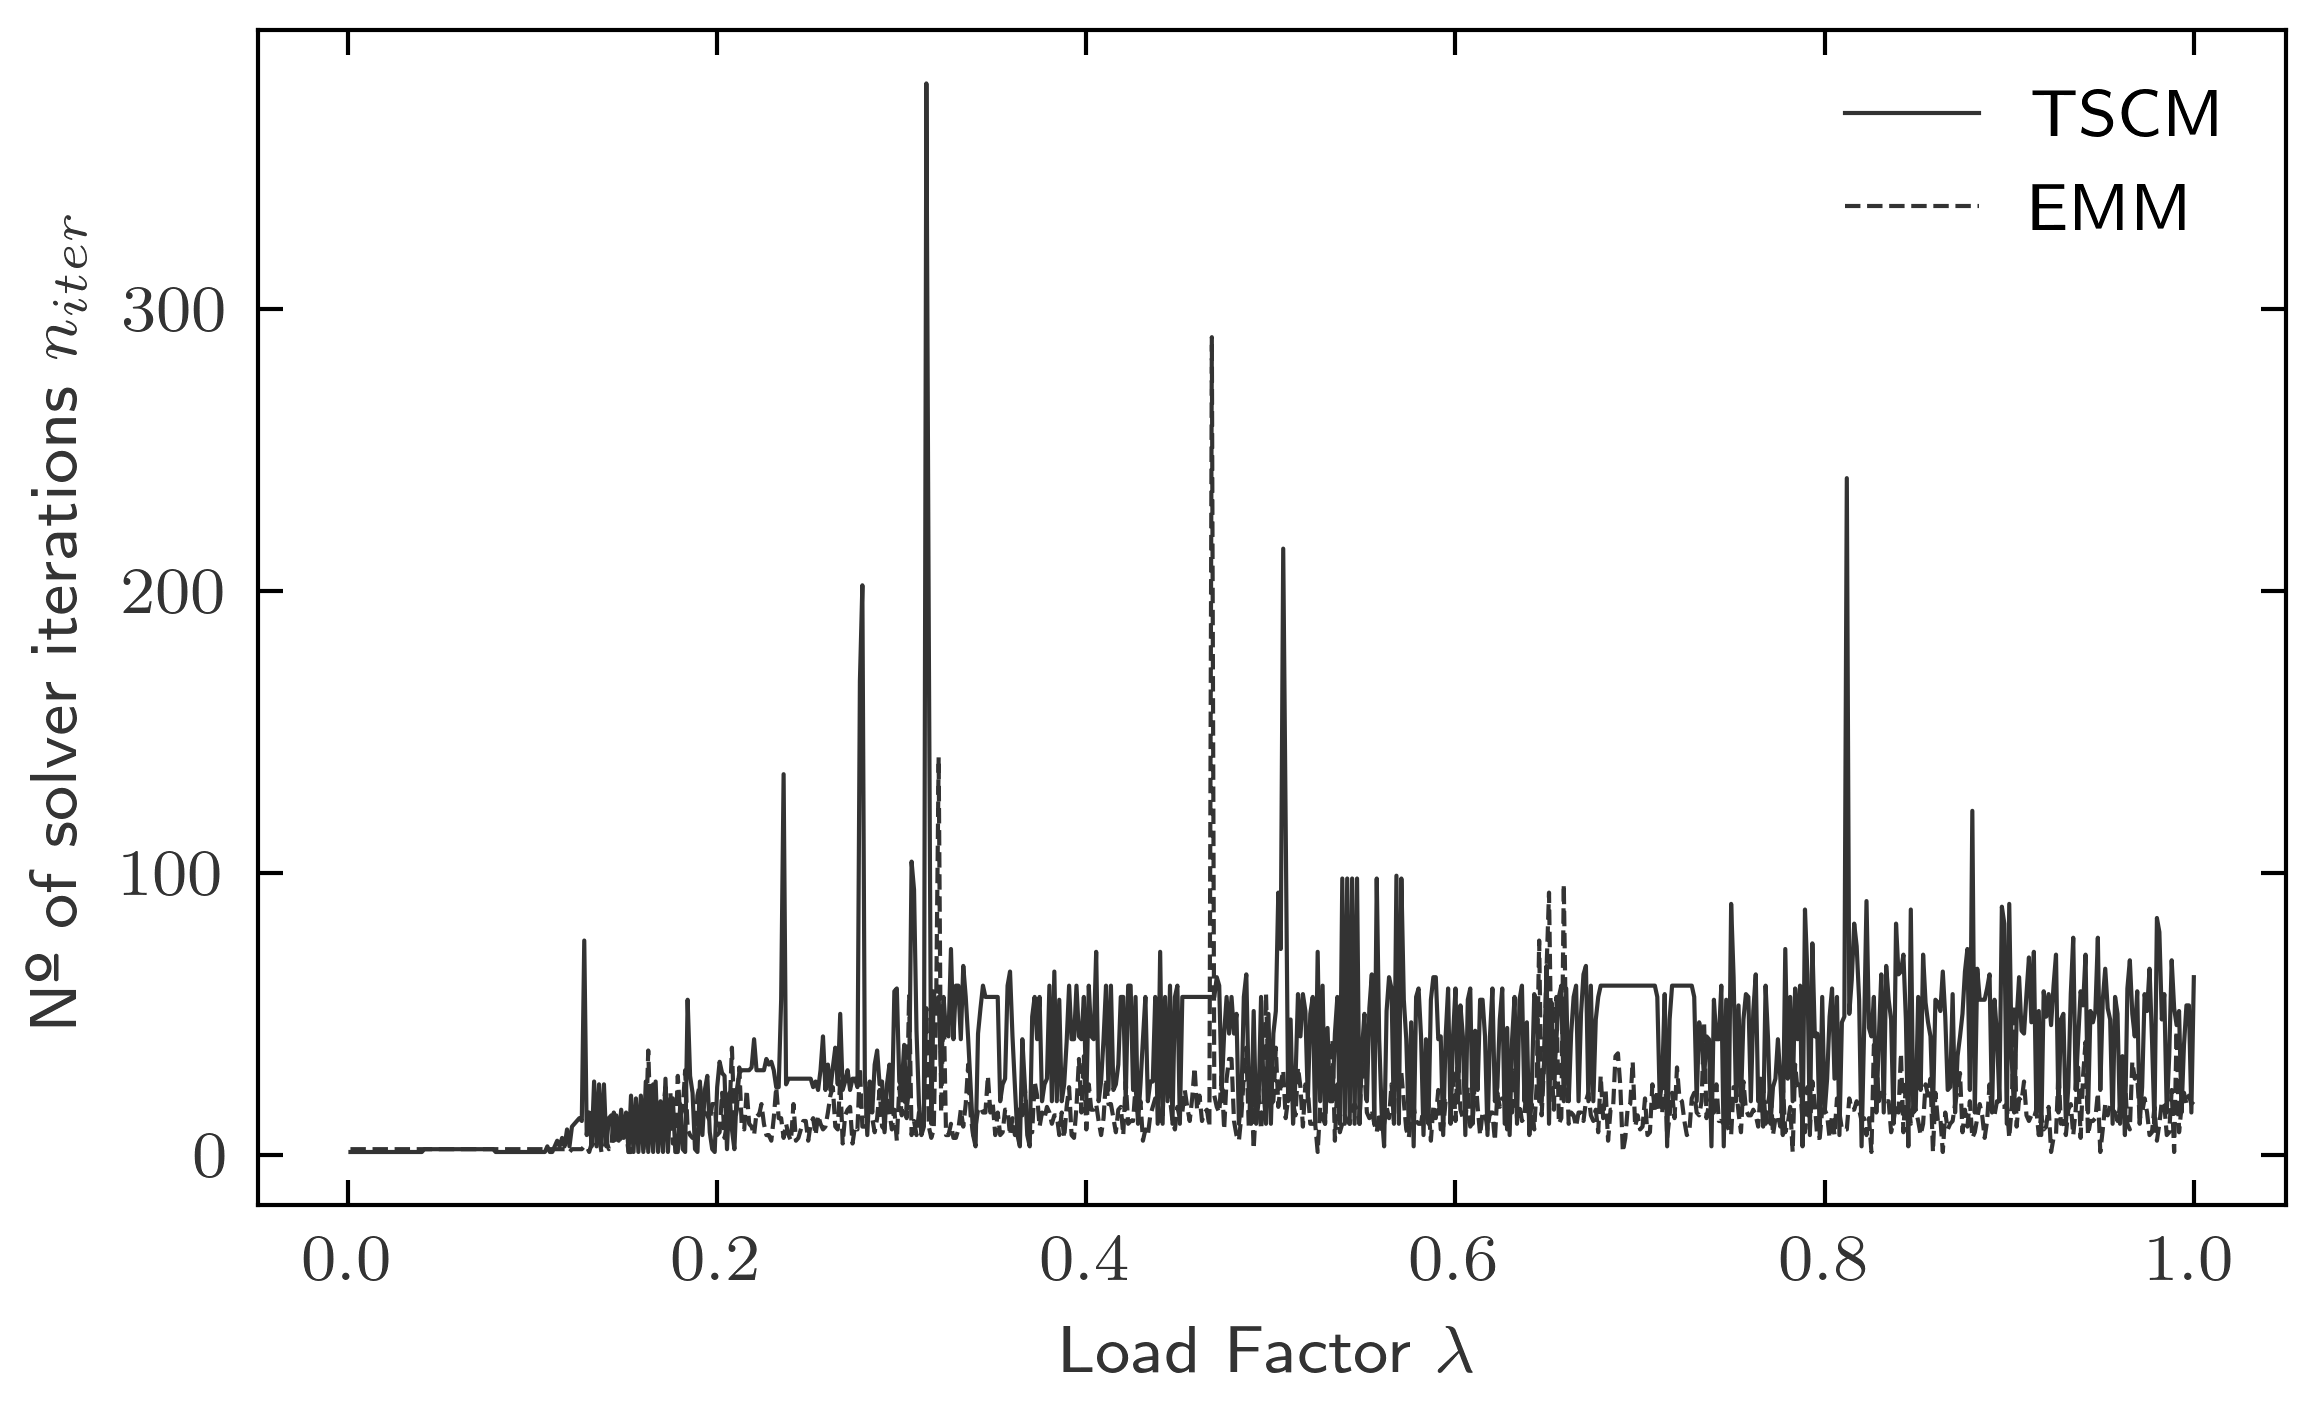

In [48]:
import matplotlib.pyplot as plt

# Read the first file and extract data
file_path_tscm = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS\2DW2I_-_TS_NLA.out'
lines_tscm = read_file(file_path_tscm)  
iter_tscm, ncsteps_tscm = parse_lines(lines_tscm)
figures_tscm, titles_tscm, ax_tscm = plotconvergence(iter_tscm, ncsteps_tscm)

# Read the second file and extract data
file_path_emm = r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2I - EMS\2DWI_-_EMS_NLA.out'
lines_emm = read_file(file_path_emm)
iter_emm, ncsteps_emm = parse_lines(lines_emm)
figures_emm, titles_emm, ax_emm = plotconvergence(iter_emm, ncsteps_emm)

# Find the index of the plot containing "Converged steps"
fig_index = 2  # Assuming it's the third figure based on your previous code

# Extract the specific axes for the "Converged steps" trace
ax_tscm_steps = figures_tscm[fig_index].axes[0]
ax_emm_steps = figures_emm[fig_index].axes[0]

# Extract data for "Converged steps" from TSCM
tscm_line = None
for line in ax_tscm_steps.get_lines():
    if line.get_label() == "Converged steps":
        tscm_line = line
        break

# Extract data for "Converged steps" from EMM
emm_line = None
for line in ax_emm_steps.get_lines():
    if line.get_label() == "Converged steps":
        emm_line = line
        break

# Create a new figure to combine the traces
fig, ax = plt.subplots(figsize=(4, 2.5))

# Plot TSCM trace
if tscm_line is not None:
    ax.plot(tscm_line.get_xdata(), tscm_line.get_ydata(), label='TSCM', linewidth=0.5)

# Plot EMM trace
if emm_line is not None:
    ax.plot(emm_line.get_xdata(), emm_line.get_ydata(), label='EMM', linewidth=0.5)

# Combine and plot non-converged steps as a single trace
non_converged_x = []
non_converged_y = []

# Add TSCM non-converged steps
if ncsteps_tscm is not None:
    non_converged_x.extend([tscm_line.get_xdata()[i - 1] for i in ncsteps_tscm])  # x-values
    non_converged_y.extend([tscm_line.get_ydata()[i - 1] for i in ncsteps_tscm])  # y-values

# Add EMM non-converged steps
if ncsteps_emm is not None:
    non_converged_x.extend([emm_line.get_xdata()[i - 1] for i in ncsteps_emm])  # x-values
    non_converged_y.extend([emm_line.get_ydata()[i - 1] for i in ncsteps_emm])  # y-values

# Plot combined non-converged steps with a single trace
if non_converged_x and non_converged_y:
    ax.scatter(non_converged_x, non_converged_y, color='red', linewidth=0.5, marker='s', facecolors='none', label='Non-Converged Steps', zorder=3)

# Set labels and title
ax.set_xlabel(r'Load Factor $\lambda$')
ax.set_ylabel(r"Nº of solver iterations $n_{iter}$")

# Show legend
ax.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()


### <strong> 1.3 | Script to take screenshots and videos of models</strong>

Creates a new directory in the models directory where it stores the contour plots for all the specified result components 

In [2]:
base_path = r''
config = {
    'results': [
        {
            'component': 'TDtY',
            'result': 'Displacements',
            'type': 'Node',
            'limits': [-35, -28, -24, -20, -16, -12, -8, -4, 0]
        },
        {
            'component': 'E1',
            'result': 'Total Strains',
            'type': 'Element',
            'location': 'mappedintpnt',
            'limits': [-0.004, -0.002, 0, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.08]
        },
        {
            'component': 'S1',
            'result': 'Cauchy Total Stresses',
            'type': 'Element',
            'location': 'mappedintpnt',
            'limits': [-3.5, -2, -1, -0.05, -0.01, 0, 0.01, 0.05, 1, 3, 61]
        },
        {
            'component': 'Ecw1',
            'result': 'Crack-widths',
            'type': 'Element',
            'location': 'mappedintpnt',
            'limits': [0, 1, 2, 3, 4, 5, 10, 15, 20]
        }
    ],
    'script': {
        'analysis': "NLA",
        'load_cases': ['Building', 'Sub Deformation'],
        'load_steps': [30, 720],
        'load_factors_init': [0.0330000, 0.00138800],
        'snapshots': 6,
        'view_settings': {
            'view_point': [0, 0, 25.0, 0, 1, 0, 5.2, 3.1, 5.5e-17, 19, 3.25],
            'title_font_size': 36,
            'legend_font_size': 34,
            'annotation_font_size': 28
        }
    }
}

setup_analysis(base_path, config)

### <strong> 1.4 | Sensitivity effects on damage study</strong>

From all models the following code the influence of the damage and time against mesh factors

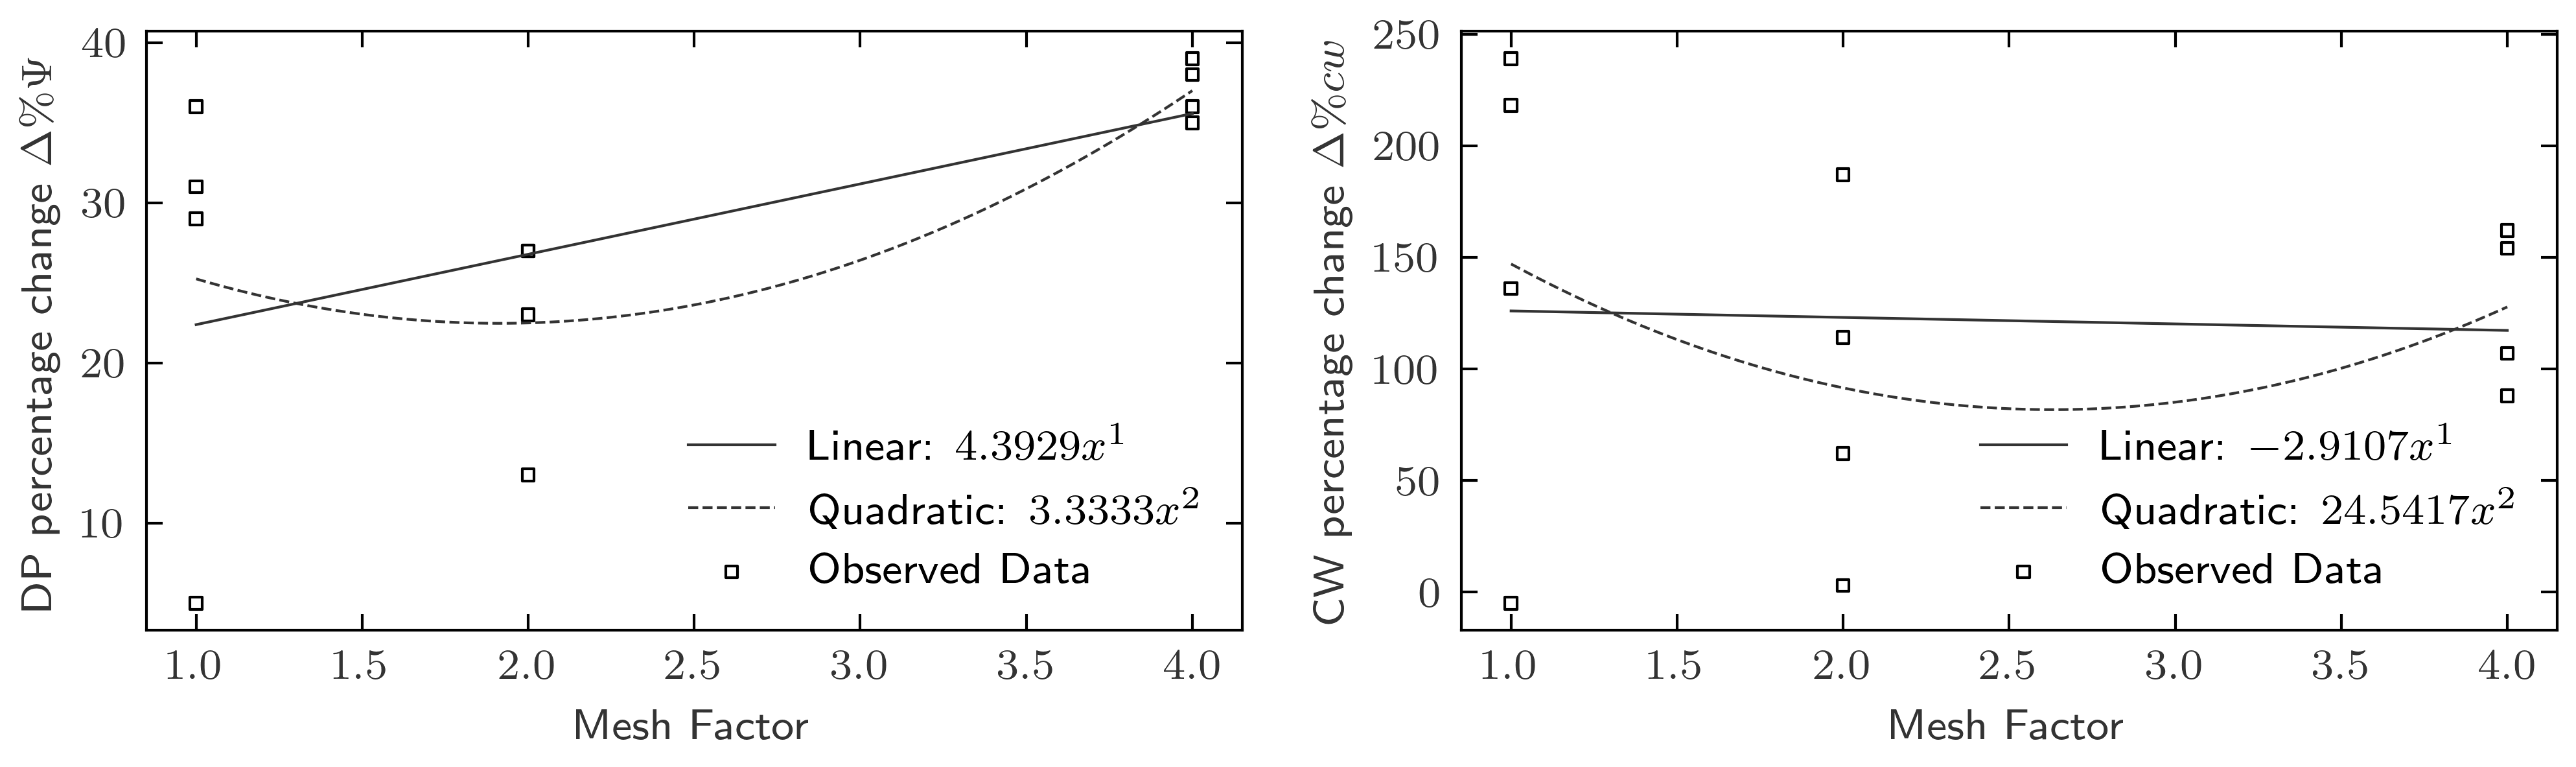

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Data initialization for the top plots (combined)
percentage_diffs_combined = {
    "Psi Mean": [29, 23, 39, 31, 27, 36, 5, 27, 38, 36, 13, 35],
    "Mean Crack Width": [136, 114, 154, 218, 187, 162, -5, 62, 107, 239, 3, 88]
}

# Mesh factors corresponding to the combined data (6 TSCM + 6 EMM)
mesh_factors_combined = [1, 2, 4, 1, 2, 4, 1, 2, 4, 1, 2, 4]  

# Data for the bottom plots (separated)
percentage_diffs_tscm = {
    "Psi Mean": [29, 23, 39, 31, 27, 36],
    "Mean Crack Width": [136, 114, 154, 218, 187, 162],
}
percentage_diffs_emm = {
    "Psi Mean": [5, 27, 38, 36, 13, 35],
    "Mean Crack Width": [-5, 62, 107, 239, 3, 88],
}

# Mesh factors corresponding to TSCM and EMM data
mesh_factors = [1, 2, 4, 1, 2, 4]  # Corresponds to the order of outer and inner leaf models

# Define the general models for trend fitting
models = [
    lambda x, a, b: a * x + b,  # Linear
    lambda x, a, b, c: a * x**2 + b * x + c,  # Quadratic
]

# Function to plot trend fits for percentage changes
def plot_fits(ax, x, y, models, labels, ylabel):
    vals = np.linspace(min(x), max(x), 100)
    for model, label in zip(models, labels):
        params, _ = curve_fit(model, x, y)
        ax.plot(vals, model(vals, *params), label=f"{label}: ${params[0]:.4f}x^{{{2 if label == 'Quadratic' else 1}}}$")
    ax.scatter(x, y, color='black', label='Observed Data', marker='s', facecolors='none', s=5, linewidths=0.5)
    ax.set_xlabel('Mesh Factor')
    ax.set_ylabel(ylabel)
    ax.legend()

# Create a 2x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(8, 2))  # Top 2 for combined, bottom 2 for separate TSCM and EMM

# Top left plot: Combined percentage change for Psi Mean
plot_fits(axs[0], mesh_factors_combined, percentage_diffs_combined["Psi Mean"], models, ['Linear', 'Quadratic'], ylabel=r'DP percentage change $\Delta\%\Psi$')

# Top right plot: Combined percentage change for Mean Crack Width
plot_fits(axs[1], mesh_factors_combined, percentage_diffs_combined["Mean Crack Width"], models, ['Linear', 'Quadratic'], ylabel=r'CW percentage change $\Delta\% cw$')

# # Bottom left plot: TSCM - Psi and Crack Width percentage changes (Inner and Outer)
# for key, values in percentage_diffs_tscm.items():
#     axs[1, 0].plot(mesh_factors[:3], values[:3], label=f'TSCM Outer - {key}', marker='o', linestyle='--')
#     axs[1, 0].plot(mesh_factors[3:], values[3:], label=f'TSCM Inner - {key}', marker='o', linestyle='-')
# axs[1, 0].set_xlabel('Mesh Factor')
# axs[1, 0].set_ylabel('$cw$ $\Delta\%$')
# axs[1, 0].set_title('TSCM Models')
# axs[1, 0].legend()

# # Bottom right plot: EMM - Psi and Crack Width percentage changes (Inner and Outer)
# for key, values in percentage_diffs_emm.items():
#     axs[1, 1].plot(mesh_factors[:3], values[:3], label=f'EMM Outer - {key}', marker='s', linestyle='--')
#     axs[1, 1].plot(mesh_factors[3:], values[3:], label=f'EMM Inner - {key}', marker='s', linestyle='-')
# axs[1, 1].set_xlabel('Mesh Factor')
# axs[1, 1].set_ylabel('$cw$ $\Delta\%$')
# axs[1, 1].set_title('EMM Models')
# axs[1, 1].legend()

# # Final layout adjustment and show the figure
# plt.tight_layout()
plt.show()


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Re-initialize data values
observed_values = np.array([132, 156, 0, 0, 528, 707, 161, 468, 1410, 2136, 1300, 1715])
mesh_factor = [1, 1, 1, 1, 2, 2, 2, 2, 4, 4, 4, 4]
percentage_diff_damage = np.array([64, 66, 50, 66, 53, 70, 72, 88, 64, 88, 91, 84])
percentage_diff_damage = np.array([42, 17, 17, 33, 25, 0, 13, 17, 17, 37, 0, 25])
mesh_factor_damage = [1, 2, 4] * 4

# Percentage difference for maximum crack widths (using the data from previous calculation)
percentage_diff_crack_width = np.array([438.0, 254.0, 378.75, 610.33, 661.0, 615.33, 113.5, 284.75, 425.5, 493.0, 208.0, 234.67])
mesh_factor_crack_width = [1, 1, 1, 1, 2, 2, 2, 2, 4, 4, 4, 4]

# Define models
models = [
    lambda x, a, b: a * x + b,  # Linear
    lambda x, a, b, c: a * x**2 + b * x + c,  # Quadratic
]

# Function to plot the fits
def plot_fits(ax, x, y, models, labels, ylabel):
    vals = np.linspace(min(x), max(x), 100)
    for model, label in zip(models, labels):
        params, _ = curve_fit(model, x, y)
        # Plot the fitted line
        ax.plot(vals, model(vals, *params), label=f"{label}: ${params[0]:.4f}x^{{{2 if label == 'Quadratic' else 1}}}$")
    # Scatter plot of observed data
    ax.scatter(x, y, color='black', label='Observed Data', marker='s', facecolors='none', s=5, linewidths=0.5)
    ax.set_xlabel('Mesh Factor')
    ax.set_ylabel(ylabel)
    ax.legend()

# Create a new figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(7.5, 2.5))

# Plot percentage change for damage parameter
plot_fits(axs[0], mesh_factor_damage, percentage_diff_damage, models, ['Linear', 'Quadratic', 'Power Law'], ylabel=r'DP percentage change $\Delta \% \Psi$')

# # Plot percentage change for analysis time
# plot_fits(axs[1], mesh_factor, observed_values, models, ['Linear', 'Quadratic', 'Power Law'], ylabel=r'Analysis time percentage change $\Delta \% t$')

# Plot percentage change for crack width
plot_fits(axs[1], mesh_factor_crack_width, percentage_diff_crack_width, models, ['Linear', 'Quadratic', 'Power Law'], ylabel=r'Crack width percentage change $\Delta \% W$')

plt.tight_layout()
plt.show()


## <strong> 2 | Calibration</strong>

### <strong> 2.1 | Feature Importance scores</strong>
From all the analysis the features are compared against the targets through a random forest to obtain the feature importance scores

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from math import pi
import pickle
import pandas as pd

def load_and_prepare_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    df = data["monitor_df"]
    targets_expanded = pd.DataFrame(df['Targets'].to_list(), columns=[f'Feature {i+1}' for i in range(len(df['Targets'][0]))])
    psi_expanded = pd.DataFrame(df['Psi'].to_list(), columns=['Psi'])
    df = pd.concat([df.drop(columns=['Targets', 'Psi', "Time", "Convergence"]), targets_expanded, psi_expanded], axis=1)
    
    return df

file_path_1 = r"C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Calibration\TSCM Single\!Results\Run_2024-08-29_20-07-43\wall_instance_latest.pkl"
features_1 = ["Young's Modulus $E_{y}$ [MPa]", "Tensile Strength $f_{t}$ [MPa]", "Mode I, Fracture Energy $G_{f-I}$ [N/mm]"]

file_path_2 = r"C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Calibration\EMM Single\!Results\Run_2024-09-01_09-41-38\wall_instance_latest.pkl"
features_2 = ["Vertical Young's Modulus $E_{y}$ [MPa]","Horizontal Young's Modulus $E_{x}$ [MPa]","Shear Modulus $G$ [MPa]", 
              "Tensile Strength $f_{t}$ [MPa]", "Mode I, Fracture Energy $G_{f-I}$ [N/mm]","Mode II, Fracture Energy $G_{f-II}$ [N/mm]"]

df1 = load_and_prepare_data(file_path_1)
df2 = load_and_prepare_data(file_path_2)

X1 = df1.drop(columns=['Total Loss', 'Psi'])
y1 = df1['Total Loss']

X2 = df2.drop(columns=['Total Loss', 'Psi', 'Y_init', 'X_init'])
y2 = df2['Total Loss']

model1 = RandomForestRegressor()
model2 = RandomForestRegressor()

model1.fit(X1, y1)
model2.fit(X2, y2)

importance1 = model1.feature_importances_
importance2 = model2.feature_importances_

print("Feature Importances for df1:")
for feature, importance in zip(X1.columns, importance1):
    print(f'{feature}: {importance}')

print("\nFeature Importances for df2:")
for feature, importance in zip(X2.columns, importance2):
    print(f'{feature}: {importance}')

### <strong> 2.2 | Sensitivity Analysis</strong>

#### <strong> 2.2.1 | Plotting the GP solution space</strong>

In [ ]:
import pickle
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior
from gpytorch.constraints import Interval
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter

pickle_file_path = '/content/drive/MyDrive/CALIBRATION/wall_instance_latest_TSCM.pkl'
with open(pickle_file_path, 'rb') as f:
    saved_data_tscm = pickle.load(f)

material_params = MaterialParameters()
confidence_level = 95
Ey_bounds = material_params.get_bounds('Emy', confidence_level)
fw_bounds = material_params.get_bounds('fw', confidence_level)
tensile_strength_bounds = tuple([material_params.tensile_strength(value) for value in fw_bounds])
tensile_fracture_energy_bounds = tuple([material_params.tensile_fracture_energy(value, 'mortar') for value in fw_bounds])
bounds = [Ey_bounds, tensile_strength_bounds, tensile_fracture_energy_bounds]

filtered_df_tscm = saved_data_tscm["monitor_df"][saved_data_tscm["monitor_df"]["Psi"].apply(lambda x: x[0] < 7)]

X_reco = np.vstack(filtered_df_tscm["Targets"])
X_scaler = MinMaxScaler()
X_init_single_scaled = X_scaler.fit_transform(X_reco)

Y_psi = np.array([i[0] for i in filtered_df_tscm["Psi"].values]).reshape(-1, 1)
Y_scaler = MinMaxScaler()
Y_psi_scaled = Y_scaler.fit_transform(Y_psi)

min_psi_index = np.argmin(Y_psi)
optimal_params = X_reco[min_psi_index]

likelihood = GaussianLikelihood(noise_constraint=Interval(1e-5, 6.8e-3))  # Regularize
kernel = ScaleKernel(
    RBFKernel(ard_num_dims=len(bounds), lengthscale_prior=GammaPrior(3.0, 0.5)) +
    MaternKernel(nu=2.5, ard_num_dims=len(bounds), lengthscale_prior=GammaPrior(3.0, 0.5))
)

gp_model_tscm = SingleTaskGP(
    train_X=torch.tensor(X_init_single_scaled, dtype=torch.float64),
    train_Y=torch.tensor(Y_psi_scaled, dtype=torch.float64),
    covar_module=kernel,
    likelihood=likelihood
)

mll = ExactMarginalLogLikelihood(gp_model_tscm.likelihood, gp_model_tscm)
fit_gpytorch_mll(mll)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_vars = X_init_single_scaled.shape[1]
grid_size = 50  # Adjust based on computational resources

# Create linspace values for each parameter based on its bounds
linspace_values = [
    np.linspace(bounds[i][0], bounds[i][1], grid_size)
    for i in range(num_vars)
]

In [ ]:
# ---------------------------------------------------------------------------- #
#                               Plotting the Mean                              #
# ---------------------------------------------------------------------------- #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
from sklearn.preprocessing import StandardScaler

num_vars = 3
fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = ["Young's Modulus $E$ [MPa]", "Tensile Strength $f_{t}$ [MPa]", "Mode I, Fracture Energy $G_{f-I}$ [N/mm]"]

global_min, global_max = float('inf'), float('-inf')

for i in range(num_vars):
    for j in range(i + 1, num_vars):
        X1, X2 = np.meshgrid(linspace_values[i], linspace_values[j])
        input_grid = np.zeros((X1.size, num_vars))
        input_grid[:, i] = X1.ravel()
        input_grid[:, j] = X2.ravel()
        for k in range(num_vars):
            if k != i and k != j:
                input_grid[:, k] = optimal_params[k]

        input_grid_normalized = X_scaler.transform(input_grid)
        input_grid_normalized = torch.tensor(input_grid_normalized, device=device, dtype=torch.double)
        with torch.no_grad():
            posterior = gp_model_tscm.posterior(input_grid_normalized)
            mean_scaled = posterior.mean.cpu().numpy().reshape(X1.shape)

        mean_unscaled = Y_scaler.inverse_transform(mean_scaled.reshape(-1, 1)).reshape(X1.shape)
        global_min = min(global_min, mean_unscaled.min())
        global_max = max(global_max, mean_unscaled.max())

global_min = np.floor(global_min * 100) / 100
global_max = np.ceil(global_max * 100) / 100

levels = np.linspace(global_min, global_max, 10)  # Change the number of levels as needed
levels = np.round(levels, 2)  # Round levels to two decimal places
cmap = plt.get_cmap('plasma', len(levels)-1)  # Get a colormap with enough colors for your levels
norm = colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]
        if i == j:
            X1 = linspace_values[i]
            input_grid = np.tile(optimal_params, (len(X1), 1))
            input_grid[:, i] = X1

            input_grid_normalized = X_scaler.transform(input_grid)
            input_grid_normalized = torch.tensor(input_grid_normalized, device=device, dtype=torch.double)
            with torch.no_grad():
                posterior = gp_model_tscm.posterior(input_grid_normalized)
                mean_scaled = posterior.mean.cpu().numpy()
                std_scaled = posterior.variance.sqrt().cpu().numpy()

            mean_unscaled = Y_scaler.inverse_transform(mean_scaled.reshape(-1, 1)).reshape(-1)

            ax.plot(X1, mean_unscaled, color='black')
            ax.set_xlabel(labels[i], labelpad=5)
            ax.set_ylabel('Damage Parameter ($\psi$)', labelpad=5)
        else:
            X1, X2 = np.meshgrid(linspace_values[i], linspace_values[j])
            input_grid = np.zeros((X1.size, num_vars))
            input_grid[:, i] = X1.ravel()
            input_grid[:, j] = X2.ravel()
            for k in range(num_vars):
                if k != i and k != j:
                    input_grid[:, k] = optimal_params[k]

            input_grid_normalized = X_scaler.transform(input_grid)
            input_grid_normalized = torch.tensor(input_grid_normalized, device=device, dtype=torch.double)
            with torch.no_grad():
                posterior = gp_model_tscm.posterior(input_grid_normalized)
                mean_scaled = posterior.mean.cpu().numpy().reshape(X1.shape)

            mean_unscaled = Y_scaler.inverse_transform(mean_scaled.reshape(-1, 1)).reshape(X1.shape)
            cont = ax.contourf(X2, X1, mean_unscaled, levels=levels, cmap=cmap, norm=norm, extend='both')
            ax.set_xlabel(labels[j], labelpad=5)
            ax.set_ylabel(labels[i], labelpad=5)

cbar = fig.colorbar(cont, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8, aspect=20, extend='both', pad=0.025)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cbar.set_label('Expected Damage Parameter ($\psi$) \n **in region close to the optimal solution', rotation=270, labelpad=20)

plt.show()
# ---------------------------------------------------------------------------- #
#                             Plotting the variance                            #
# ---------------------------------------------------------------------------- #
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler

# Assuming other necessary setups like model, linspace_values, optimal_params, device are defined above.

num_vars = 3
fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = ["Young's Modulus $E$ [MPa]", "Tensile Strength $f_{t}$ [MPa]", "Mode I, Fracture Energy $G_{f-I}$ [N/mm]"]

# Loop through each pair of variables to simulate and find the standard deviation
for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]
        if i == j:
            # Plot the diagonal terms: mean and uncertainty bounds
            X1 = linspace_values[i]
            input_grid = np.tile(optimal_params, (len(X1), 1))
            input_grid[:, i] = X1

            input_grid_normalized = X_scaler.transform(input_grid)
            input_grid_normalized = torch.tensor(input_grid_normalized, device=device, dtype=torch.double)
            with torch.no_grad():
                posterior = gp_model_tscm.posterior(input_grid_normalized)
                variance = posterior.variance.cpu().numpy().reshape(X1.shape)  # Use raw variance data

                # Calculate standard deviation in the scaled space
                std_scaled = np.sqrt(variance)

                # Inverse transform the standard deviation to the original scale
                std_unscaled = Y_scaler.inverse_transform(std_scaled.reshape(-1, 1)).reshape(X1.shape)

            ax.plot(X1, std_unscaled, color='black')
            ax.set_xlabel(labels[i], labelpad=5)
            ax.set_ylabel('Damage Parameter ($\psi$)', labelpad=5)
        else:
            X1, X2 = np.meshgrid(linspace_values[i], linspace_values[j])
            input_grid = np.zeros((X1.size, num_vars))
            input_grid[:, i] = X1.ravel()
            input_grid[:, j] = X2.ravel()
            for k in range(num_vars):
                if k != i and k != j:
                    input_grid[:, k] = optimal_params[k]

            input_grid_normalized = X_scaler.transform(input_grid)
            input_grid_normalized = torch.tensor(input_grid_normalized, device=device, dtype=torch.double)
            with torch.no_grad():
                posterior = gp_model_tscm.posterior(input_grid_normalized)
                variance = posterior.variance.cpu().numpy().reshape(X1.shape)  # Use raw variance data

                # Calculate standard deviation in the scaled space
                std_scaled = np.sqrt(variance)

                # Inverse transform the standard deviation to the original scale
                std_unscaled = Y_scaler.inverse_transform(std_scaled.reshape(-1, 1)).reshape(X1.shape)

            # Plot the unscaled standard deviation
            cont = ax.contourf(X2, X1, std_unscaled, cmap='coolwarm', extend='both')
            ax.set_xlabel(labels[j], labelpad=5)
            ax.set_ylabel(labels[i], labelpad=5)

# Create the colorbar
cbar = fig.colorbar(cont, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8, aspect=20, extend='both', pad=0.025)
# Set the colorbar to display values with two decimal points
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cbar.set_label('Damage Parameter ($\psi$) Standard Deviation \n **in region close to the optimal solution', rotation=270, labelpad=20)
plt.show()

#### <strong> 2.2.2 | Plotting the Kernel, Covariance between variables</strong>

In [ ]:
grid_size = 20
colormap = 'coolwarm'
figsize = (10, 8)
num_vars = len(bounds)
labels = ["Young's Modulus $E$ [MPa]", "Tensile Strength $f_{t}$ [MPa]", "Mode I, Fracture Energy $G_{f-I}$ [N/mm]"]
gp_model = gp_model_tscm

fig, axes = plt.subplots(num_vars, num_vars, figsize=figsize)
fig.subplots_adjust(wspace=0.35, hspace=0.3)

def compute_covariance(i, j):
    X1 = np.linspace(bounds[i][0], bounds[i][1], grid_size)
    X2 = np.linspace(bounds[j][0], bounds[j][1], grid_size)

    set1 = np.tile(optimal_params, (grid_size, 1))
    set2 = np.tile(optimal_params, (grid_size, 1))

    set1[:, i] = X1  
    set2[:, j] = X2  

    # Normalize the arrays
    set1_normalized = X_scaler.transform(set1)
    set2_normalized = X_scaler.transform(set2)

    set1_normalized = torch.tensor(set1_normalized, device=device, dtype=torch.double)
    set2_normalized = torch.tensor(set2_normalized, device=device, dtype=torch.double)

    with torch.no_grad():
        cov_matrix = gp_model.covar_module(set1_normalized, set2_normalized).evaluate().cpu().numpy()

    cov_matrix = cov_matrix.reshape(grid_size, grid_size)
    cov_matrix = Y_scaler.inverse_transform(cov_matrix.reshape(-1, 1)).reshape(grid_size, grid_size)

    return X1, X2, cov_matrix

all_covariances = []
for i in range(num_vars):
    for j in range(num_vars):
        X1, X2, cov_matrix = compute_covariance(i, j)
        all_covariances.append(cov_matrix)

all_covariances_flat = np.concatenate([cov.flatten() for cov in all_covariances])
mean_covariance = np.mean(all_covariances_flat)

vmin = np.min(all_covariances_flat - mean_covariance)
vmax = np.max(all_covariances_flat - mean_covariance)

for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]
        X1, X2, cov_matrix = compute_covariance(i, j)

        cov_matrix_deviation = cov_matrix - mean_covariance

        cont = ax.contourf(X2, X1, cov_matrix_deviation, cmap=colormap, vmin=vmin, vmax=vmax, levels=10, extend='both')

        ax.set_xlabel(labels[j], labelpad=5)
        ax.set_ylabel(labels[i], labelpad=5)

cbar = fig.colorbar(cont, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.8, aspect=20, extend='both', pad=0.025)

cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
cbar.set_label(f'Model parameters covariance ($\\mu$ = {mean_covariance:.3f})\n**in region close to the optimal solution', rotation=270, labelpad=20)

plt.show()

In [ ]:
analysis_info_TSRCM = {
    'Damage level': { 
        'parameters': {'auto': True,
                       'mesh': 200     
    },
    
}}

plot_settings_TSRCM = {
    'Damage level': {
        'traces': ['$\psi$ TSCM'],
        'labels': ['Load factor $\lambda$', 'Damage Parameter $\psi$'],
        'titles': 'Damage level progression',
        'scientific': True
    }
}

merge_info = {
    'Titles': ['Force norm', 'Displacement norm'],
    'x_label': 'Load factor $\lambda$',
    'y_label': 'Disp \& Force Norm $|\Delta_f| |\Delta_u|$',
    'title': 'Combined Force and Displacement Norms'
}

directories = [
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS - 0.1m',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2O - TS - 0.05m',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS - 0.1m',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\Continuum\Standard\W2I - TS - 0.05m',

    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2I - EMS',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2I - EMS - 0.1m',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2I - EMS - 0.05m',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2O - EMHJ',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2O - EMS',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2O - EMS - 0.1m',
    r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q3 & Q4\CIEM0500 - MS Thesis Project\!content\Experimentation\Modelling\Models\EMM\W2O - EMS - 0.05m'
]
sizes = [200, 100, 50, 200, 100, 50, 200, 100, 50, 200, 200, 100, 50]
data = []
for model_dir, size in zip(directories, sizes):
    print(f'Analysing model in directory: {model_dir} with mesh size: {size}')
    analysis_info_TSRCM['Damage level']['parameters']['mesh'] = size
    data_l = analyse_models(model_dir, analysis_info_TSRCM, plot_settings_TSRCM, merge=merge_info)
    data.append(data_l)